In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import lymanAbs as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [4]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    return -2.5 * np.log10(flux) - ABref

# Load data... 

In [103]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
rootPath = '/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/27Aug15-3Mpc-output/' # Home computer dir... 
filePat = 'haloFluxes_z_*_.txt'
files   = glob.glob(rootPath+filePat)  # All the files in the dir... should be one!
fileListz = []
for file in files:
    start = file.index('z_') + 2
    end = file.index('.txt') - 1
    fileListz.append(file[start:end])
fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
# Access fluxes as: fluxes[z][filter] to get a list of fluxes for the halos... 
# Also possible are indx, <Z>/Z_sun, <Z_P>/Z_sun, M/M_sun

In [104]:
for z in fileListz:
    print(z,len(fluxes[float(z)]['f444w'])) 
thezs= [float(i) for i in fileListz]


10.0 124
11.0 96
12.0 62
13.0 40
14.0 23
15.0 15
16.0 8
6.0 337
6.5 380
7.0 390
7.5 20
8.0 369
8.5 275
9.0 199
9.5 137


In [27]:
jwstFilters   = lf.loadJWSTFilters(suppress=True)
hubbleFilters = lf.loadHubbleFilters(suppress=True)
jhkFilters    = lf.loadJHKFilters(suppress=True)

In [28]:
print([aFilt for aFilt in hubbleFilters],[aFilt for aFilt in jwstFilters])

['F336W_WFC3', 'F850LP_ACS', 'F125W_WFC3', 'F435W_ACS', 'F606W_ACS', 'F160W_WFC3', 'F105W_WFC3', 'F225W_WFC3', 'F275W_WFC3', 'F098M_WFC3', 'F775W_ACS'] ['f070w', 'f300m', 'f410m', 'f182m', 'f200w', 'f360m', 'f335m', 'f090w', 'f140m', 'f480m', 'f150w', 'f356w', 'f430m', 'f460m', 'f210m', 'f115w', 'f250m', 'f444w', 'f277w', 'f162m']


In [29]:
fluxes[6]['f444w'].min(),fluxes[6]['f444w'].max(),fluxes[6]['f444w_P3'].min(),fluxes[6]['f444w_P3'].max()

(6.3385999999999996e-40, 1.6869e-31, 0.0, 3.6936e-37)

In [30]:
print(fluxes[6].dtype.names)

('indx', 'ZZ_sun', 'Z_PZ_sun', 'MM_sun', 'F098M_WFC3', 'F105W_WFC3', 'F125W_WFC3', 'F160W_WFC3', 'F225W_WFC3', 'F275W_WFC3', 'F336W_WFC3', 'F435W_ACS', 'F606W_ACS', 'F775W_ACS', 'F850LP_ACS', 'H', 'J', 'Ks', 'f070w', 'f090w', 'f115w', 'f140m', 'f150w', 'f162m', 'f182m', 'f200w', 'f210m', 'f250m', 'f277w', 'f300m', 'f335m', 'f356w', 'f360m', 'f410m', 'f430m', 'f444w', 'f460m', 'f480m', 'F098M_WFC3_P3', 'F105W_WFC3_P3', 'F125W_WFC3_P3', 'F160W_WFC3_P3', 'F225W_WFC3_P3', 'F275W_WFC3_P3', 'F336W_WFC3_P3', 'F435W_ACS_P3', 'F606W_ACS_P3', 'F775W_ACS_P3', 'F850LP_ACS_P3', 'H_P3', 'J_P3', 'Ks_P3', 'f070w_P3', 'f090w_P3', 'f115w_P3', 'f140m_P3', 'f150w_P3', 'f162m_P3', 'f182m_P3', 'f200w_P3', 'f210m_P3', 'f250m_P3', 'f277w_P3', 'f300m_P3', 'f335m_P3', 'f356w_P3', 'f360m_P3', 'f410m_P3', 'f430m_P3', 'f444w_P3', 'f460m_P3', 'f480m_P3', 'F098M_WFC3_NM', 'F105W_WFC3_NM', 'F125W_WFC3_NM', 'F160W_WFC3_NM', 'F225W_WFC3_NM', 'F275W_WFC3_NM', 'F336W_WFC3_NM', 'F435W_ACS_NM', 'F606W_ACS_NM', 'F775W_ACS_N

/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


13026

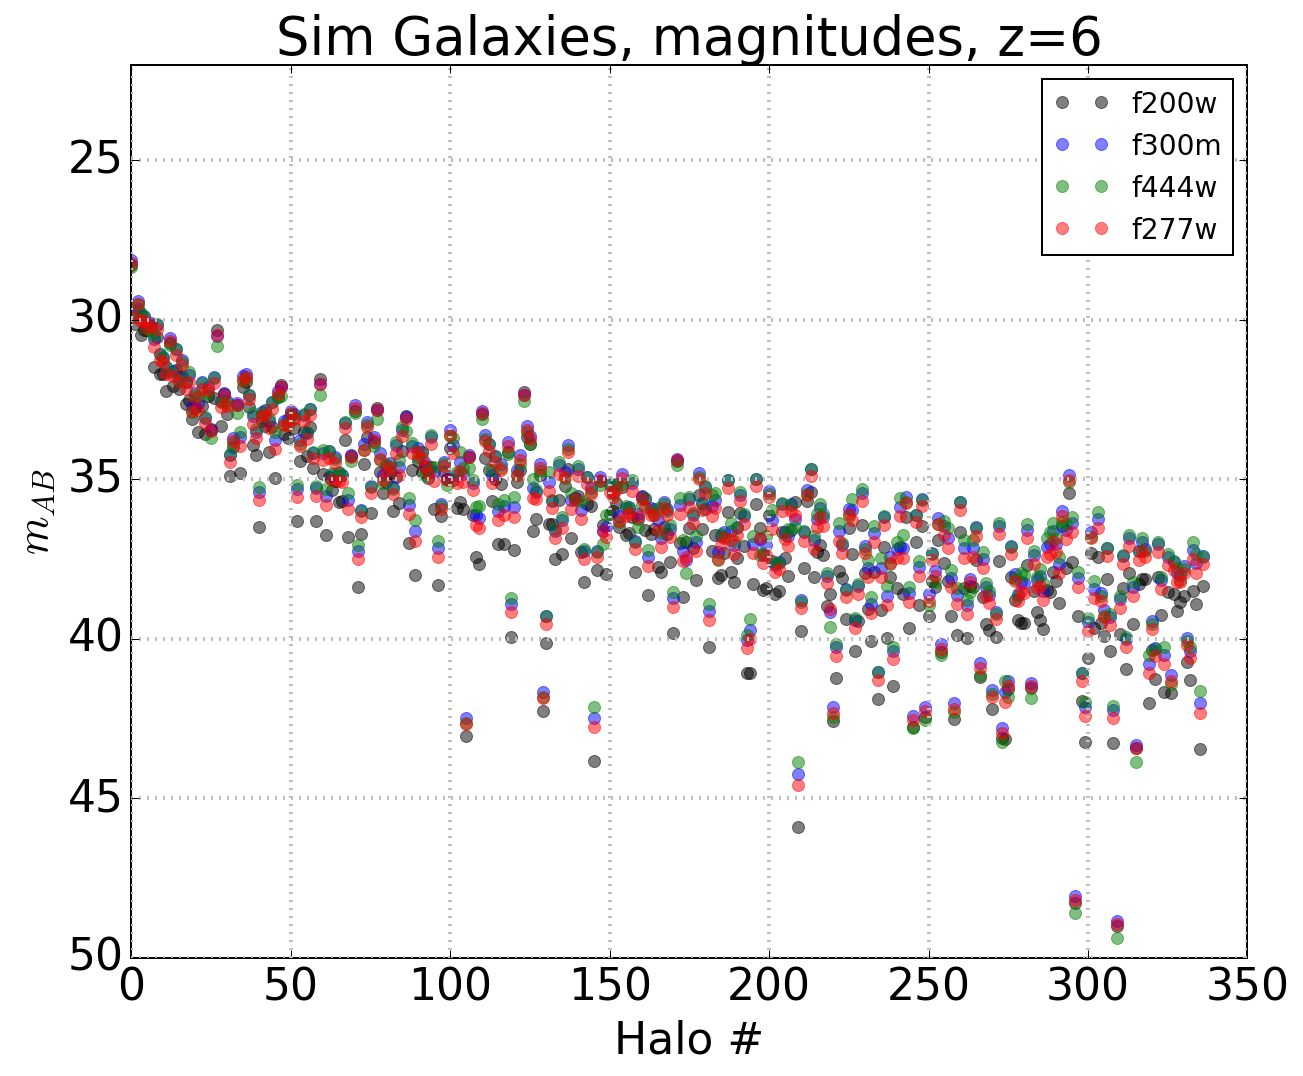

In [89]:
z=6
f200diff = mag(fluxes[z]['f200w_P3']) - mag(fluxes[z]['f200w'])
f300diff = mag(fluxes[z]['f300m_P3']) - mag(fluxes[z]['f300m'])
f444diff = mag(fluxes[z]['f444w_P3']) - mag(fluxes[z]['f444w'])
f277diff = mag(fluxes[z]['f277w_P3']) - mag(fluxes[z]['f277w'])
f200wErr = [-f200diff,np.array([0.0 for i in range(len(f200diff))])]
f300wErr = [-f300diff,np.array([0.0 for i in range(len(f200diff))])]
f444wErr = [-f444diff,np.array([0.0 for i in range(len(f200diff))])]
f277wErr = [-f277diff,np.array([0.0 for i in range(len(f200diff))])]

haloNums = range(len(fluxes[z]['f200w']))

fig = plt.figure(figsize=(10,8))
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('linear')

ax.set_title('Sim Galaxies, magnitudes, z={}'.format(z))
# ax.errorbar(haloNums,mag(fluxes[z]['f200w']),yerr=f200wErr,fmt='k.',markersize=22,alpha=0.5)
# ax.errorbar(haloNums,mag(fluxes[z]['f300m']),yerr=f300wErr,fmt='b.',markersize=22,alpha=0.5)
# ax.errorbar(haloNums,mag(fluxes[z]['f444w']),yerr=f444wErr,fmt='g.',markersize=22,alpha=0.5)
# ax.errorbar(haloNums,mag(fluxes[z]['f277w']),yerr=f277wErr,fmt='r.',markersize=22,alpha=0.5)
ax.plot(mag(fluxes[z]['f200w']),'k.',markersize=12,alpha=0.5)
ax.plot(mag(fluxes[z]['f300m']),'b.',markersize=12,alpha=0.5)
ax.plot(mag(fluxes[z]['f444w']),'g.',markersize=12,alpha=0.5)
ax.plot(mag(fluxes[z]['f277w']),'r.',markersize=12,alpha=0.5)

ax.set_ylim([22,50])
ax.set_xlabel('Halo #')
ax.set_ylabel(r'$m_{AB}$')
ax.grid(color='0.75', linestyle=':', linewidth=2)

ax.legend(['f200w','f300m','f444w','f277w'], 
          loc='upper right', fontsize=14 )
# ax.annotate('Large dots indicate PopIII only magnitude', xycoords='axes fraction',
#             textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.95),size=14)

# ax.plot(mag(fluxes[z]['f200w_P3']),'o',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='k')
# ax.plot(mag(fluxes[z]['f300m_P3']),'o',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='b')
# ax.plot(mag(fluxes[z]['f444w_P3']),'o',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='g')
# ax.plot(mag(fluxes[z]['f277w_P3']),'o',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='r')

# ax.plot(mag(fluxes[z]['f200w_NM']),'d',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='k')
# ax.plot(mag(fluxes[z]['f300m_NM']),'d',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='b')
# ax.plot(mag(fluxes[z]['f444w_NM']),'d',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='g')
# ax.plot(mag(fluxes[z]['f277w_NM']),'d',markersize=10, markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='r')

plt.gca().invert_yaxis()
plt.savefig("haloMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


0

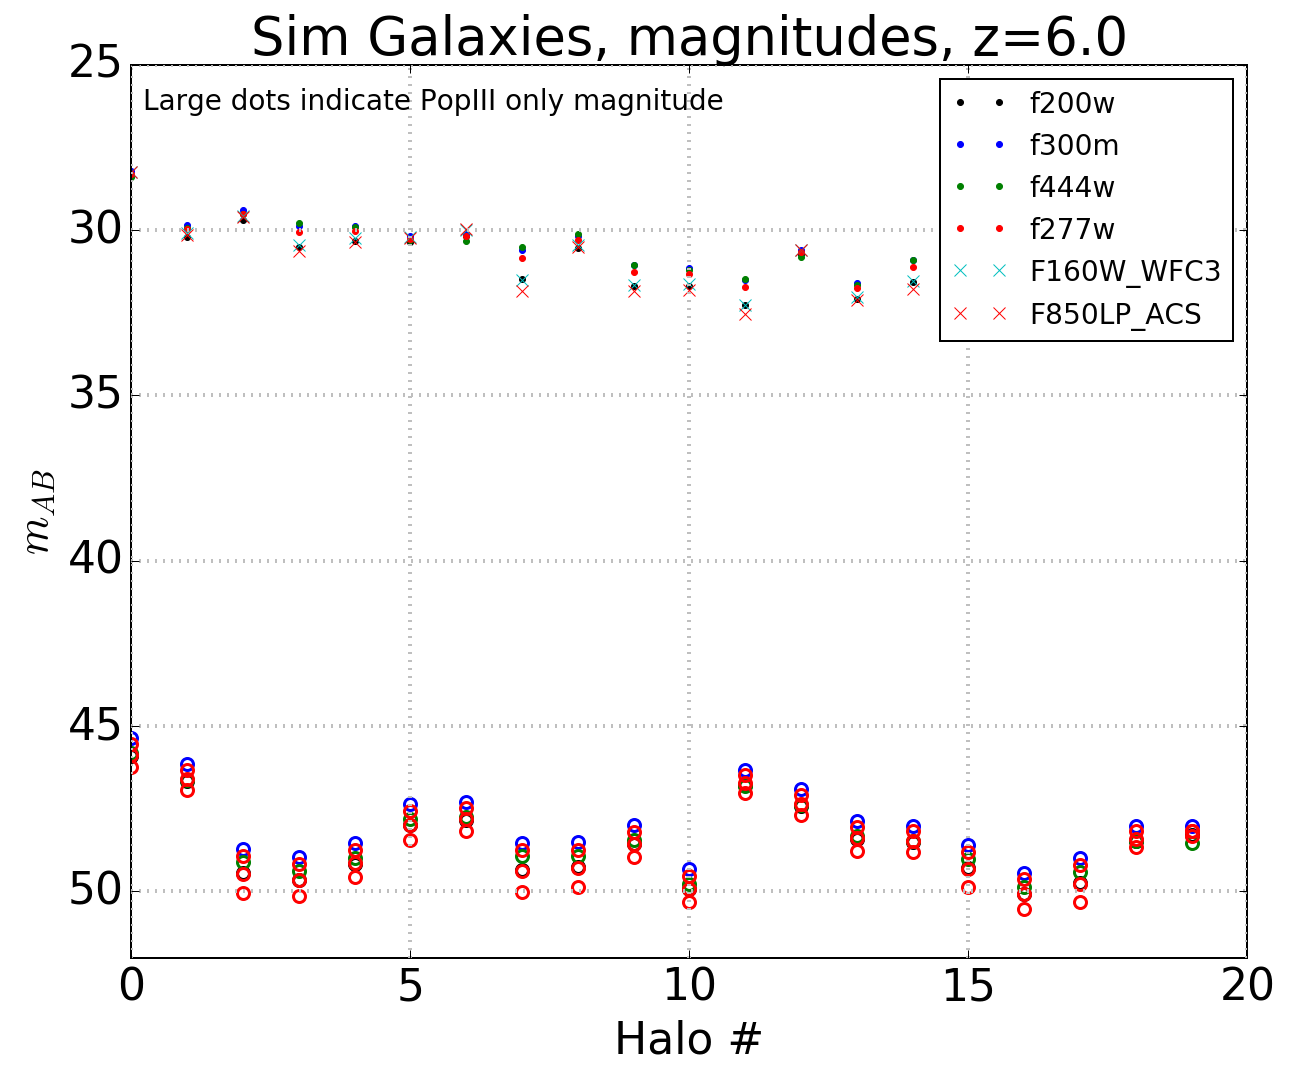

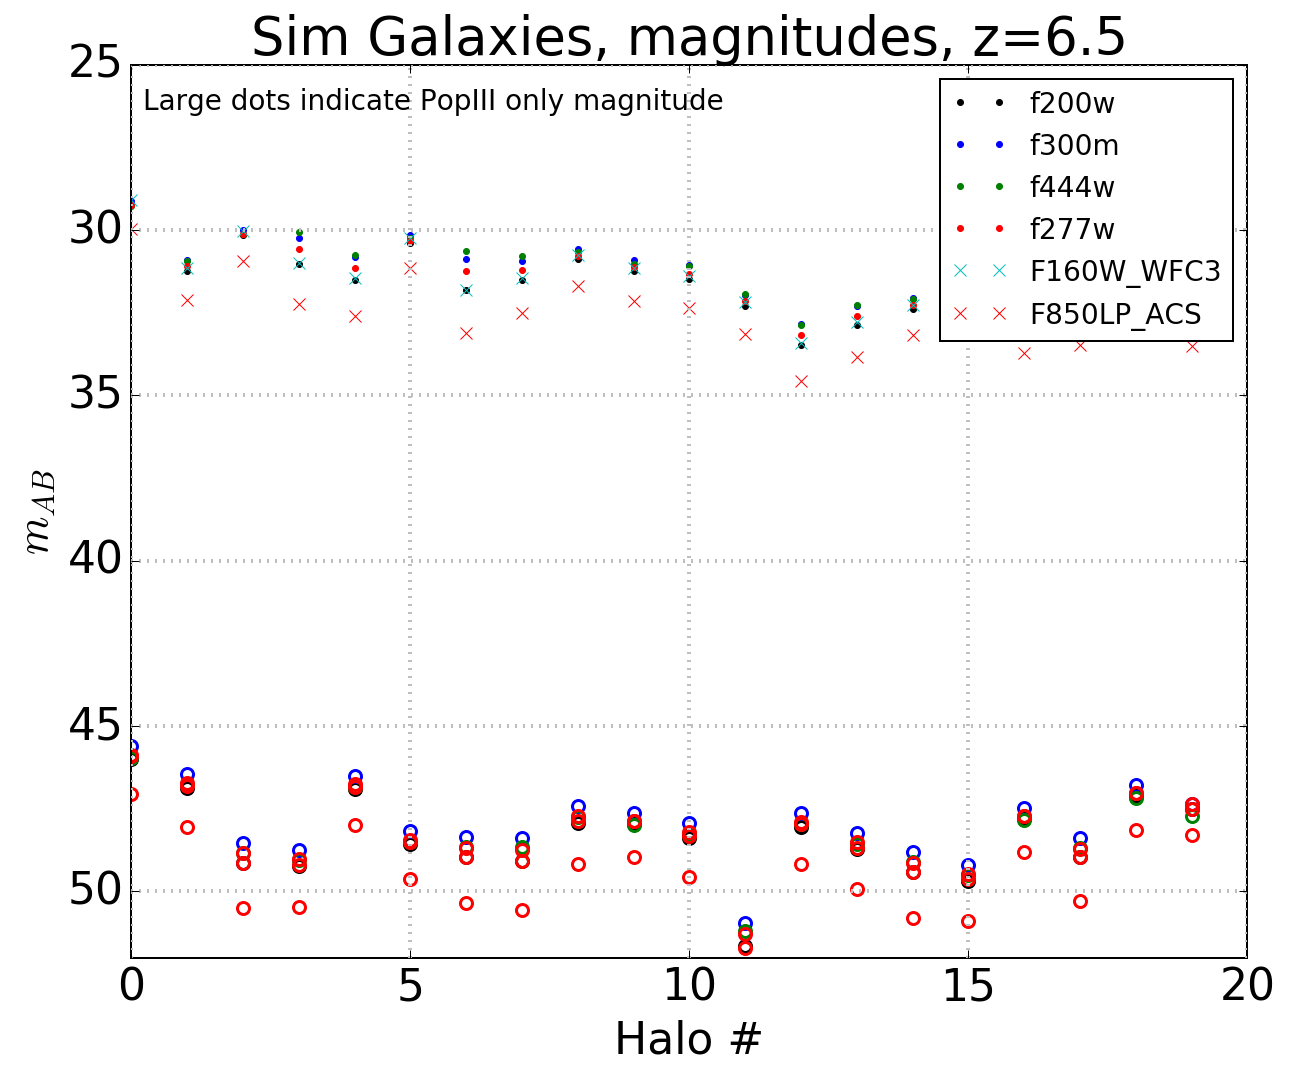

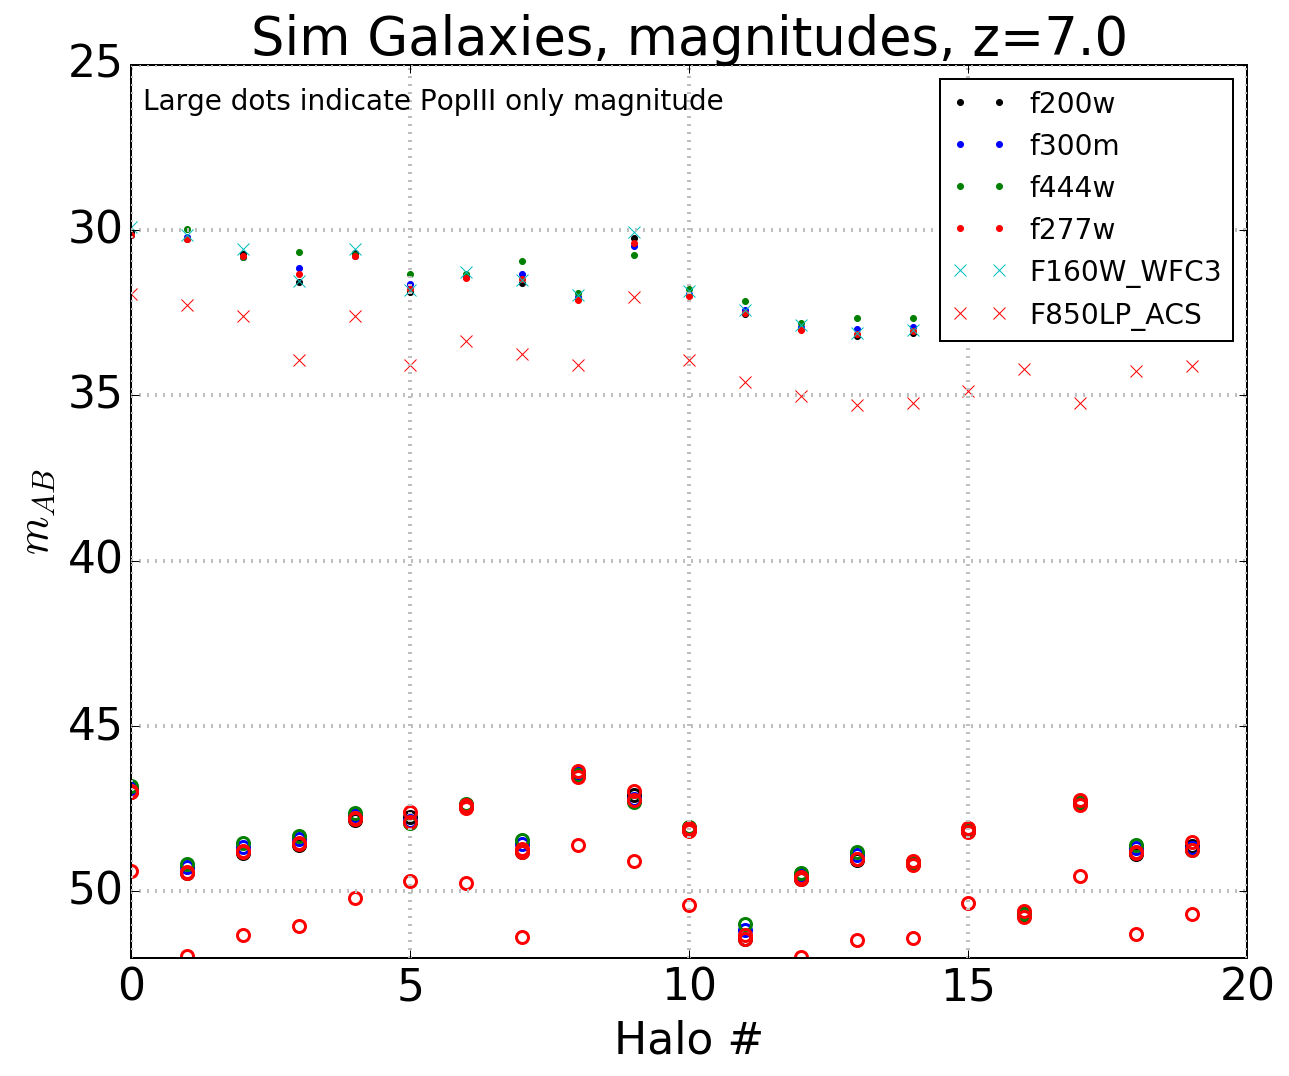

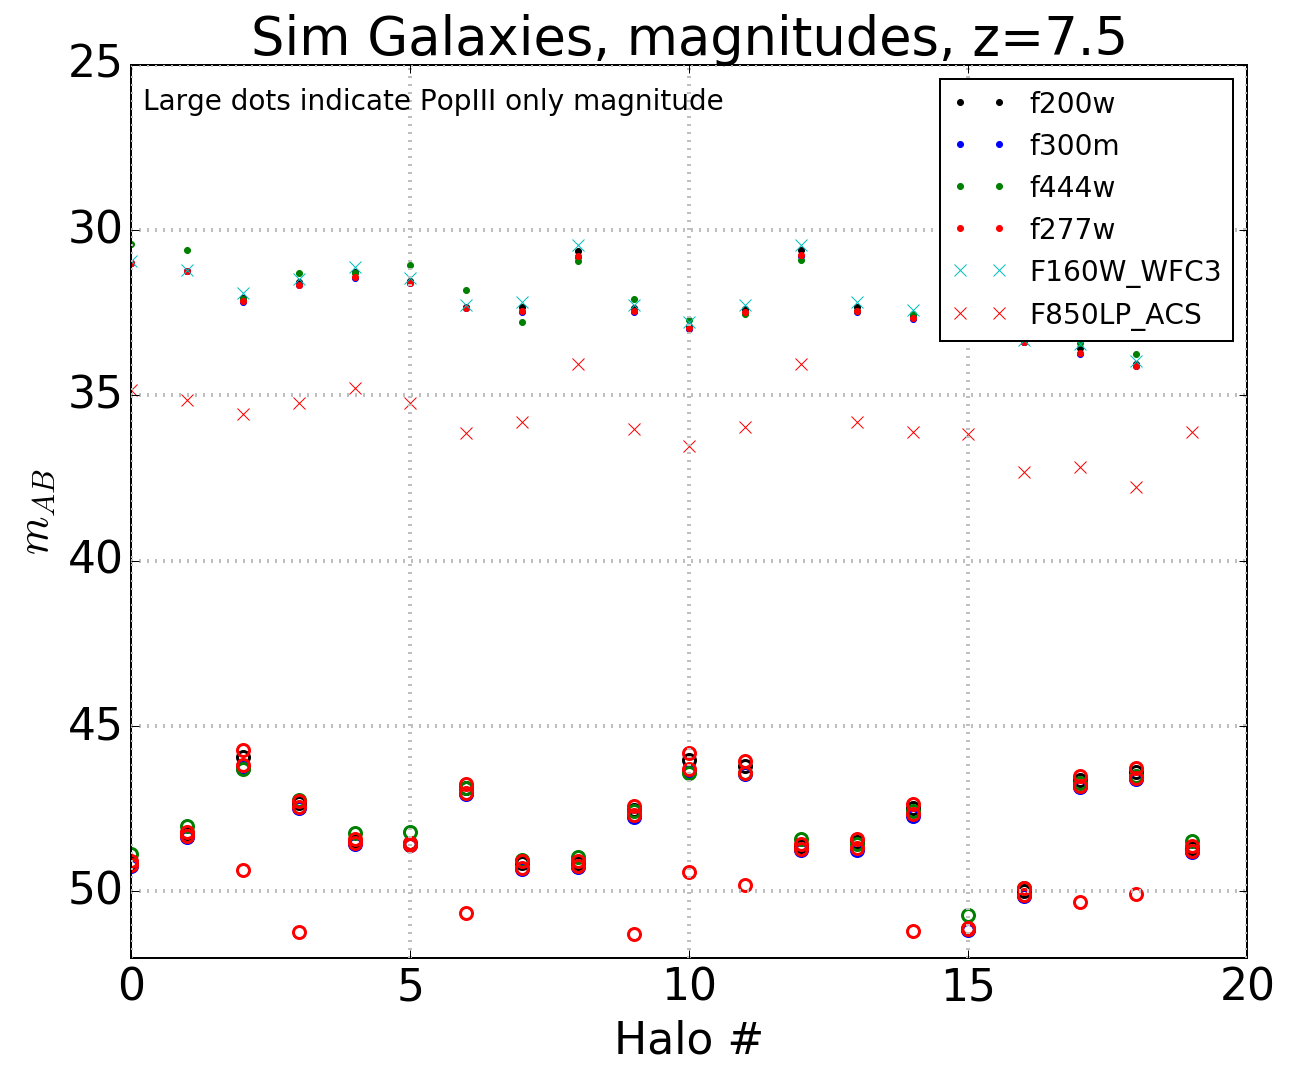

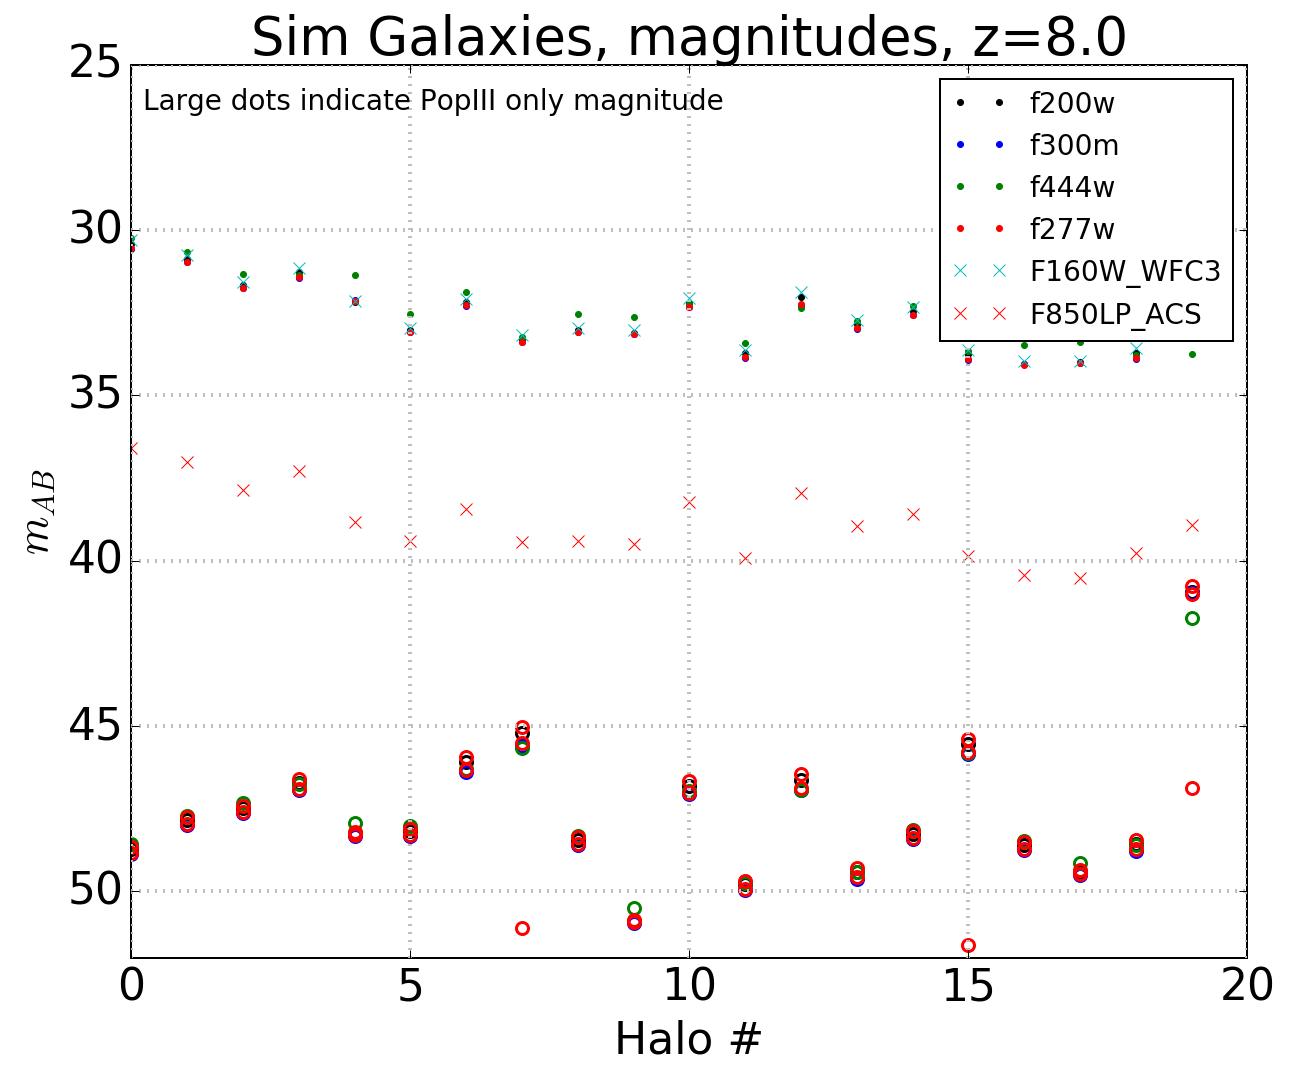

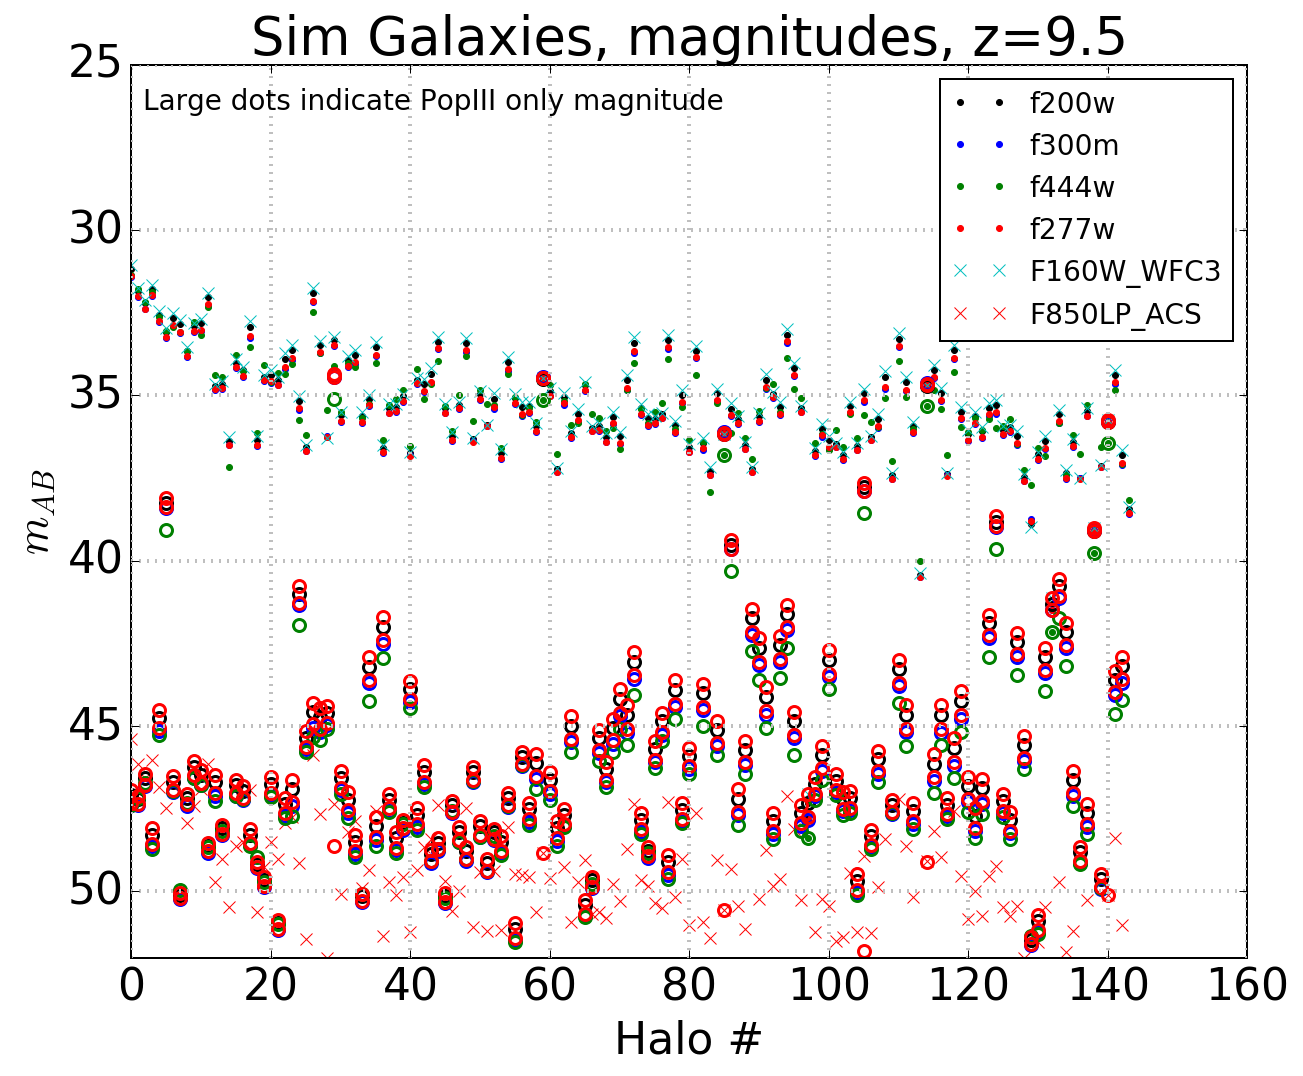

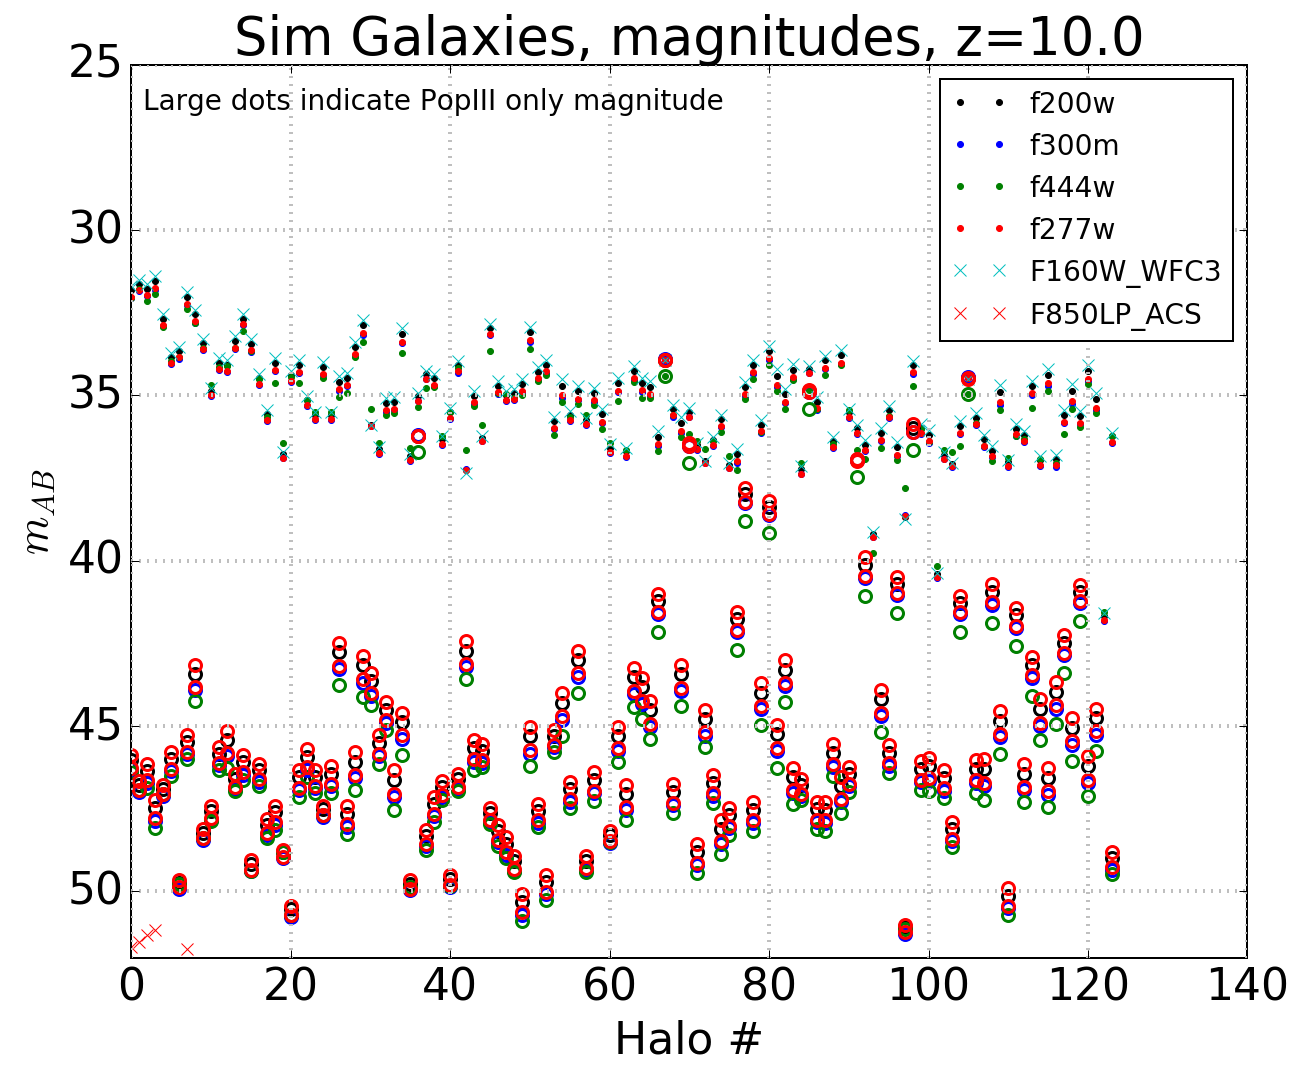

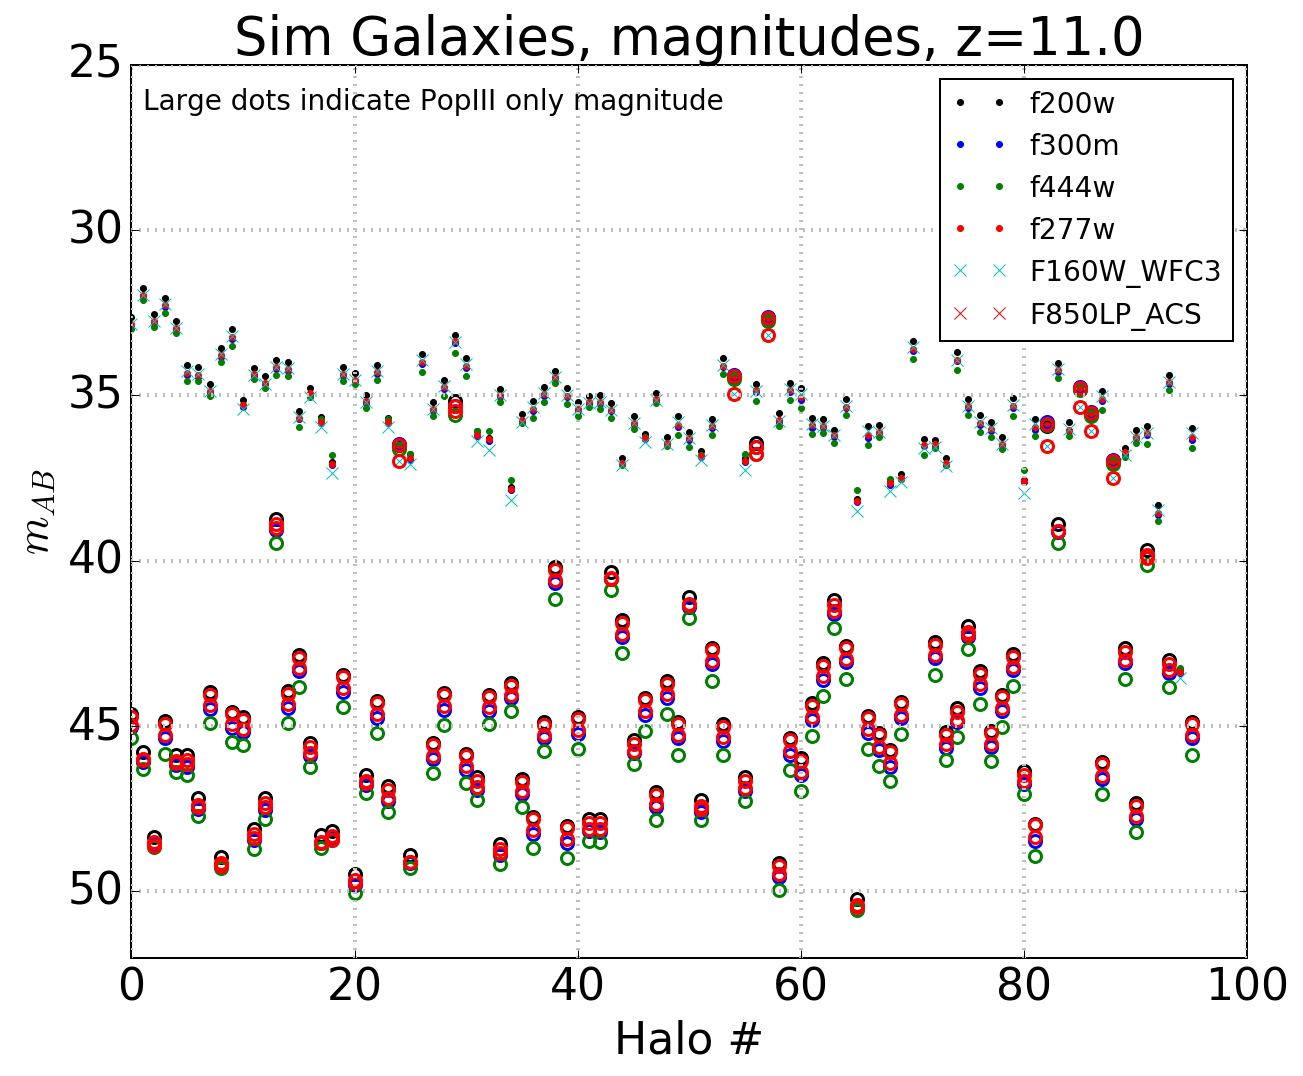

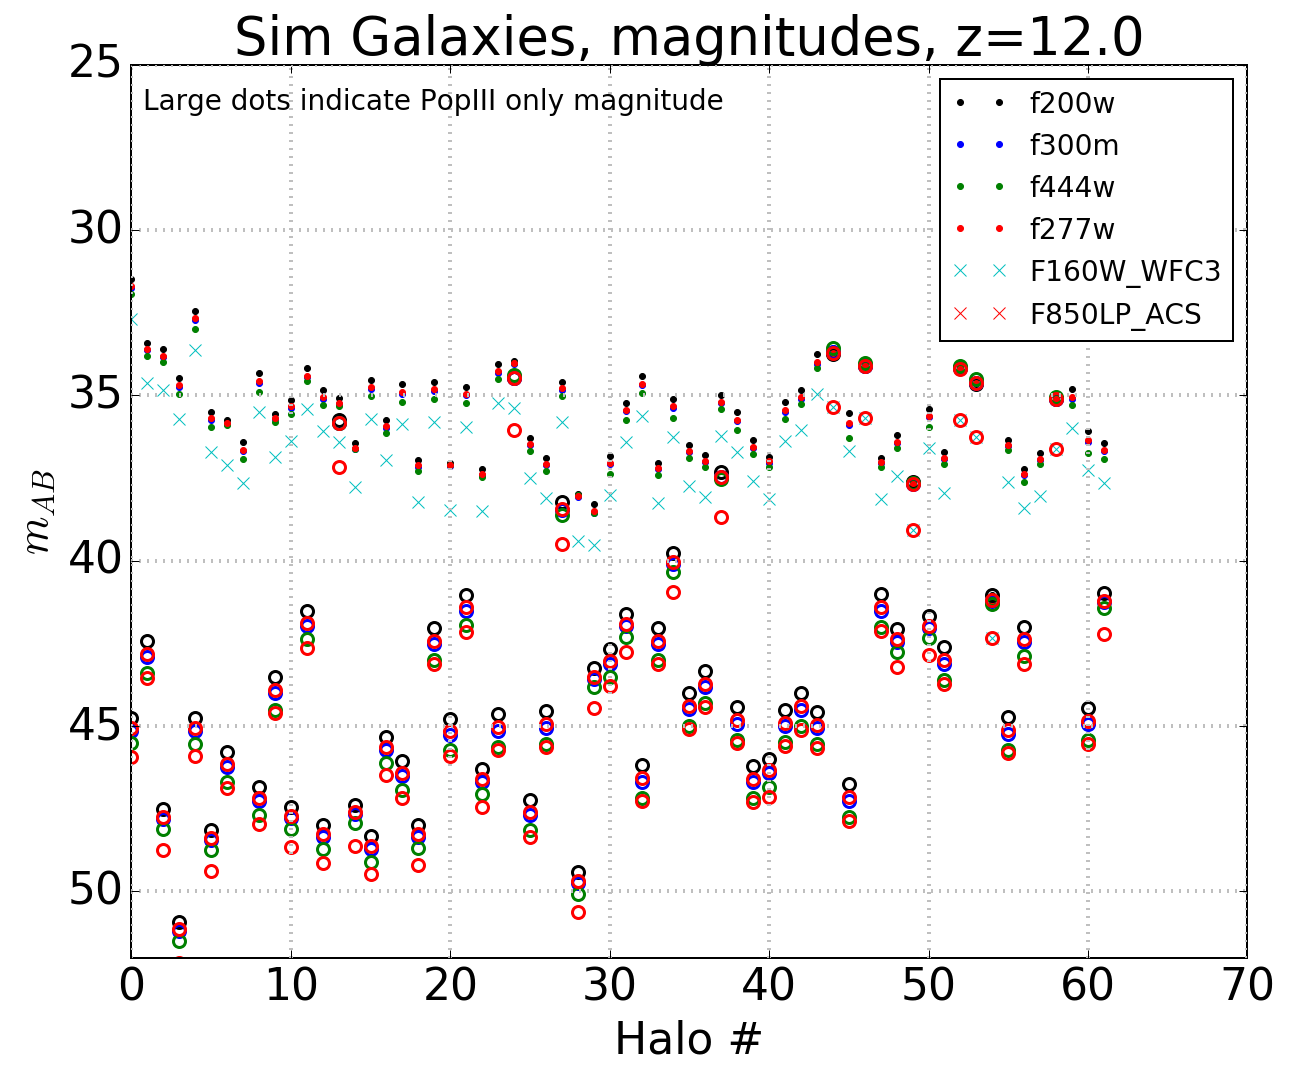

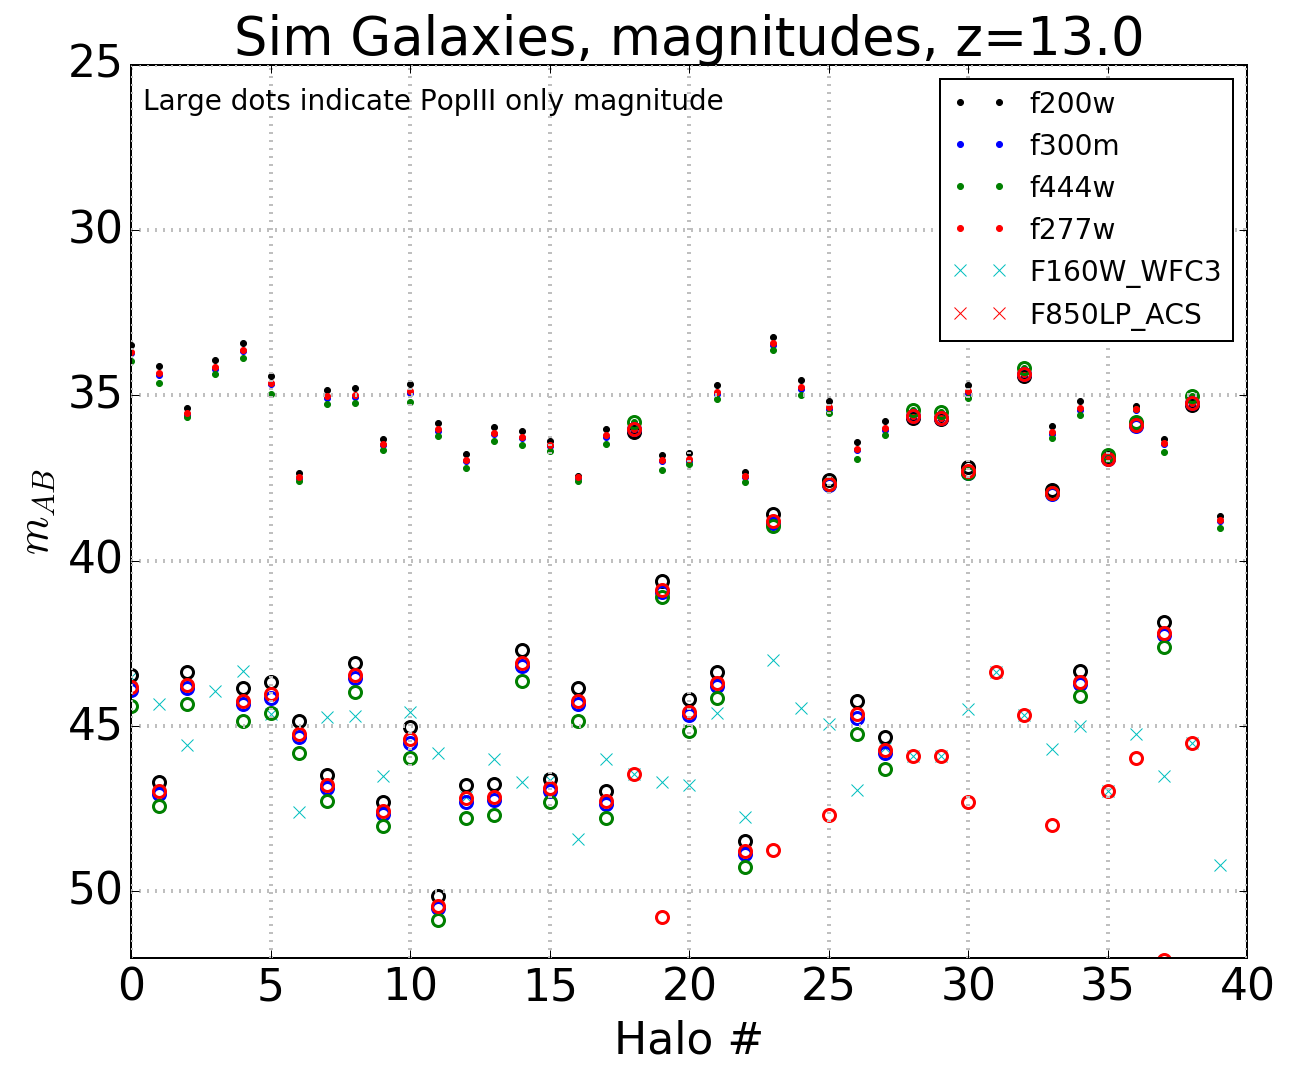

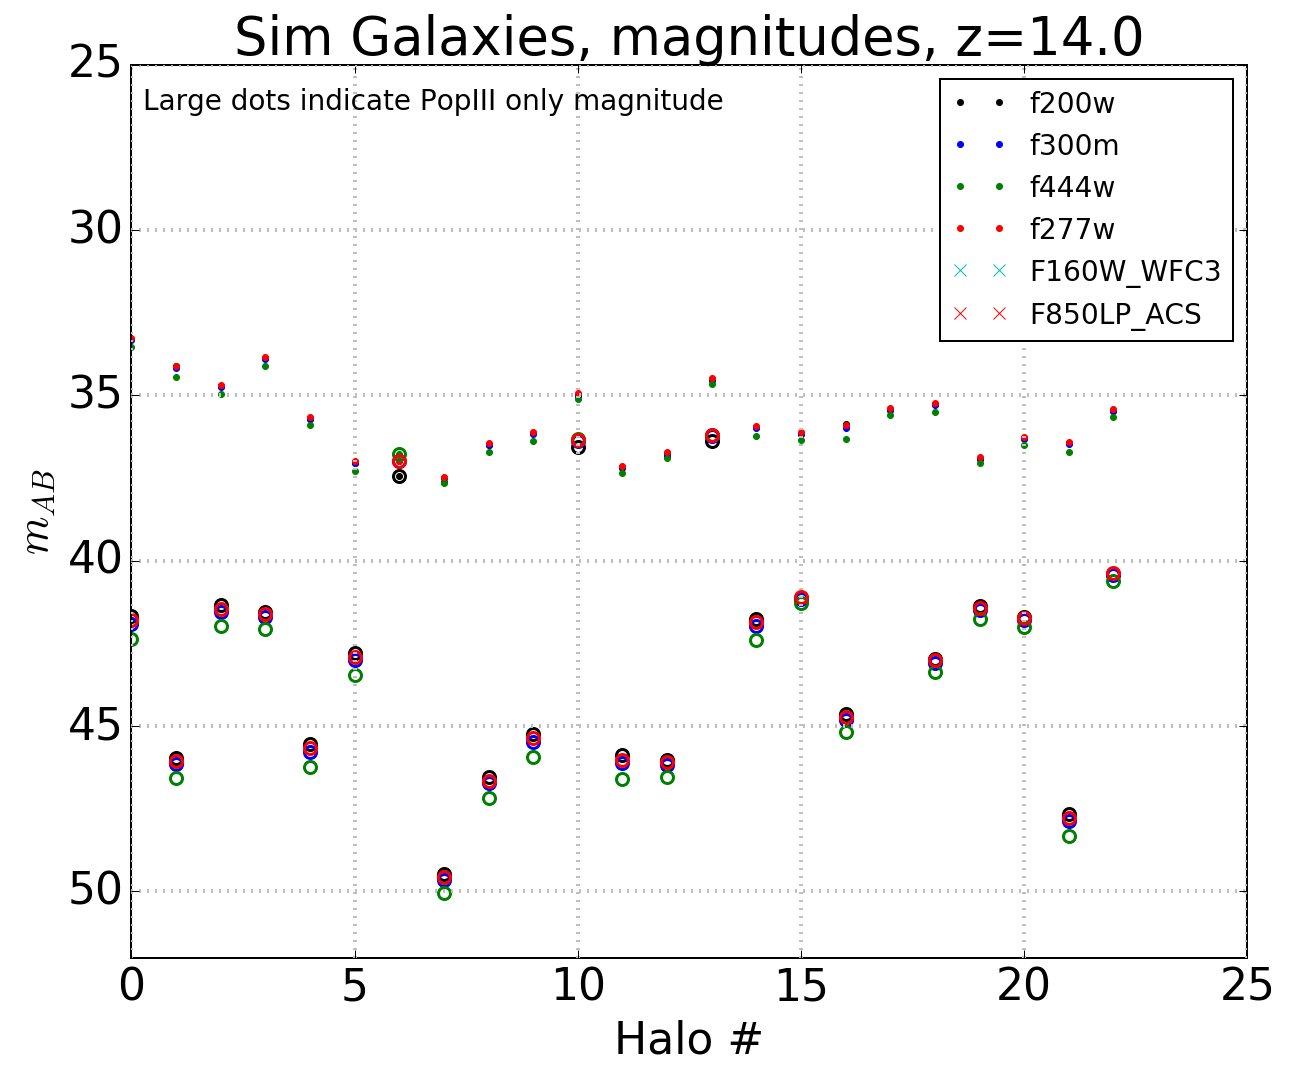

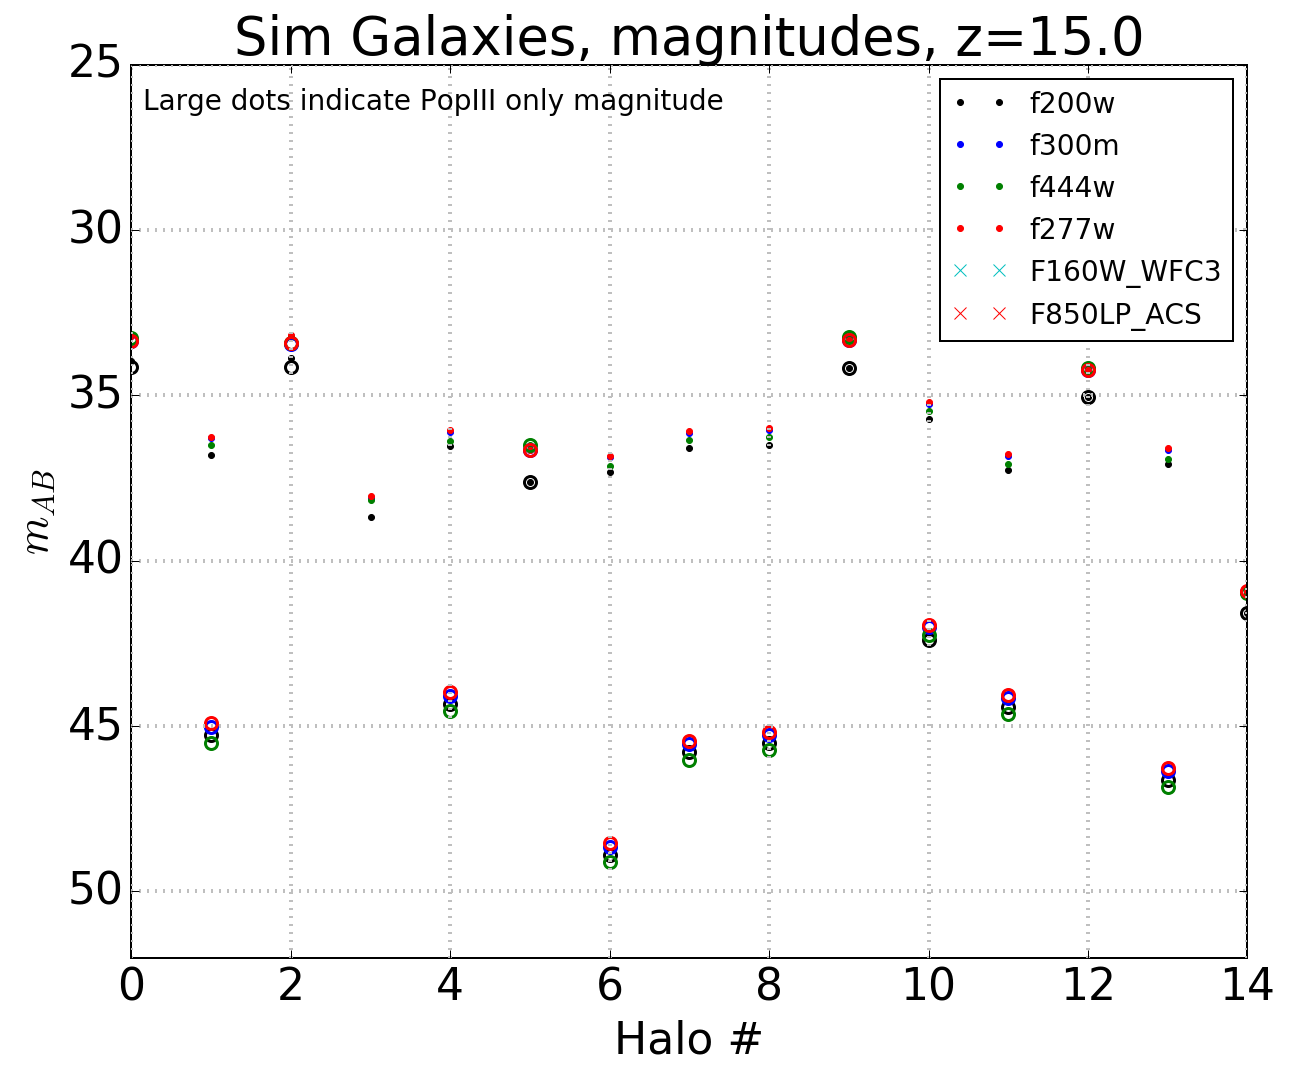

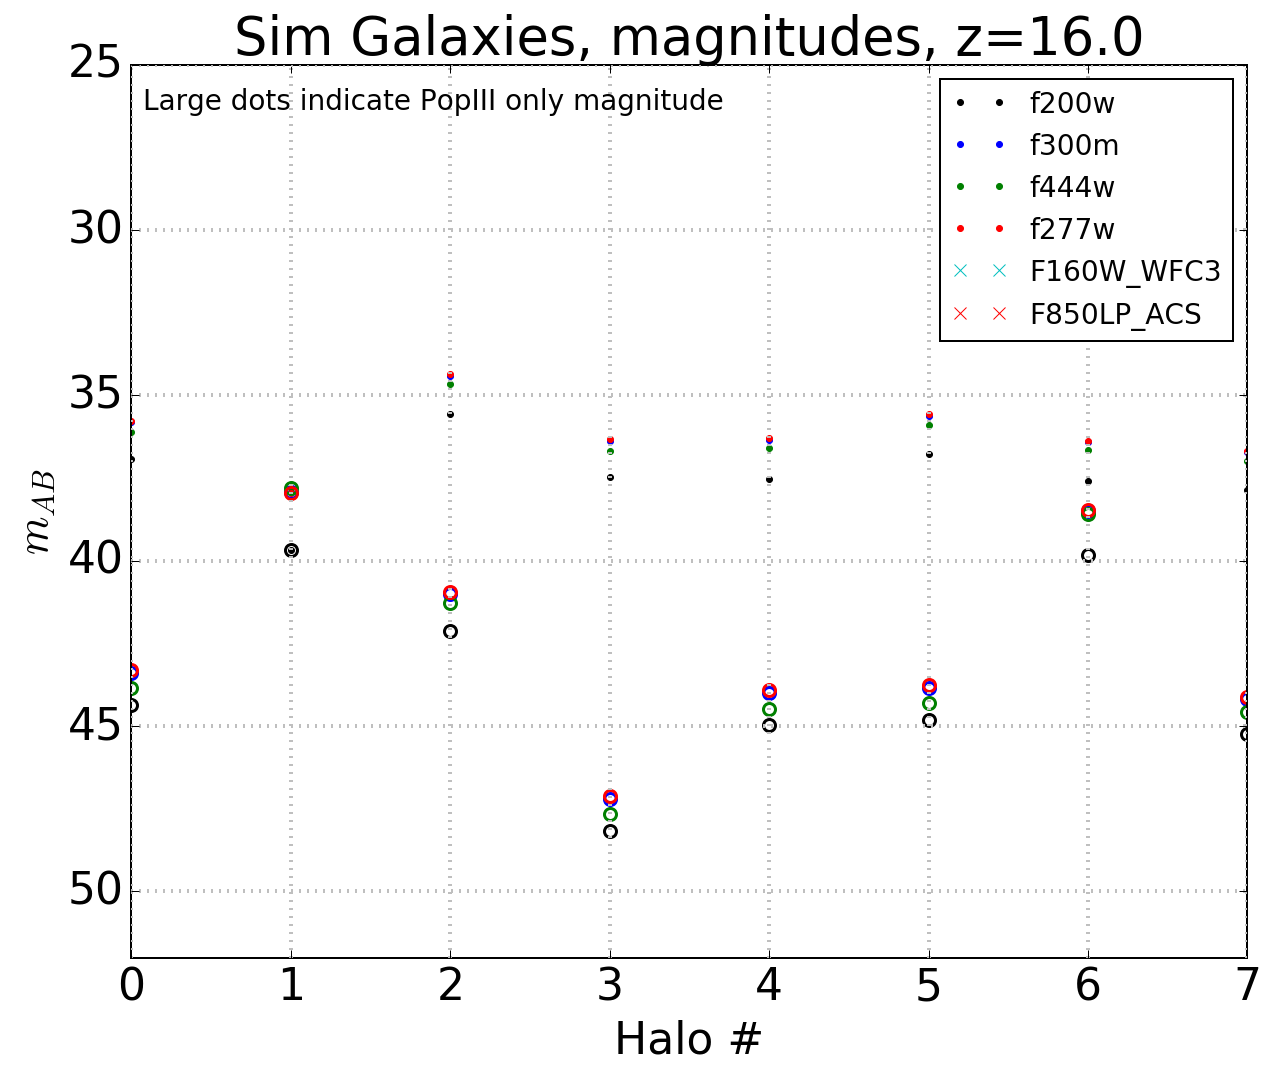

In [13]:
for z in np.sort(thezs):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    ax.set_xscale('linear')
    ax.set_yscale('linear')

    ax.set_title('Sim Galaxies, magnitudes, z={}'.format(z))
    ax.plot(mag(fluxes[z]['f200w']),'k.')
    ax.plot(mag(fluxes[z]['f300m']),'b.')
    ax.plot(mag(fluxes[z]['f444w']),'g.')
    ax.plot(mag(fluxes[z]['f277w']),'r.')
    ax.plot(mag(fluxes[z]['F160W_WFC3']),'cx')
    ax.plot(mag(fluxes[z]['F850LP_ACS']),'rx')

    ax.set_ylim([25,52])
    ax.set_xlabel('Halo #')
    ax.set_ylabel(r'$m_{AB}$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

    ax.legend(['f200w','f300m','f444w','f277w','F160W_WFC3','F850LP_ACS'], 
              loc='upper right', fontsize=14 )
    ax.annotate('Large dots indicate PopIII only magnitude', xycoords='axes fraction',
                textcoords='axes fraction', xy=(.5,.5), xytext=(.01,.95),size=14)
    ax.plot(mag(fluxes[z]['f200w_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='k')
    ax.plot(mag(fluxes[z]['f300m_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='b')
    ax.plot(mag(fluxes[z]['f444w_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='g')
    ax.plot(mag(fluxes[z]['f277w_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='r')
    ax.plot(mag(fluxes[z]['F160W_WFC3_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='r')
    ax.plot(mag(fluxes[z]['F850LP_ACS_P3']),'o',markeredgewidth=1.5,markerfacecolor='None',markeredgecolor='r')

    plt.gca().invert_yaxis()
    plt.savefig("haloMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

0

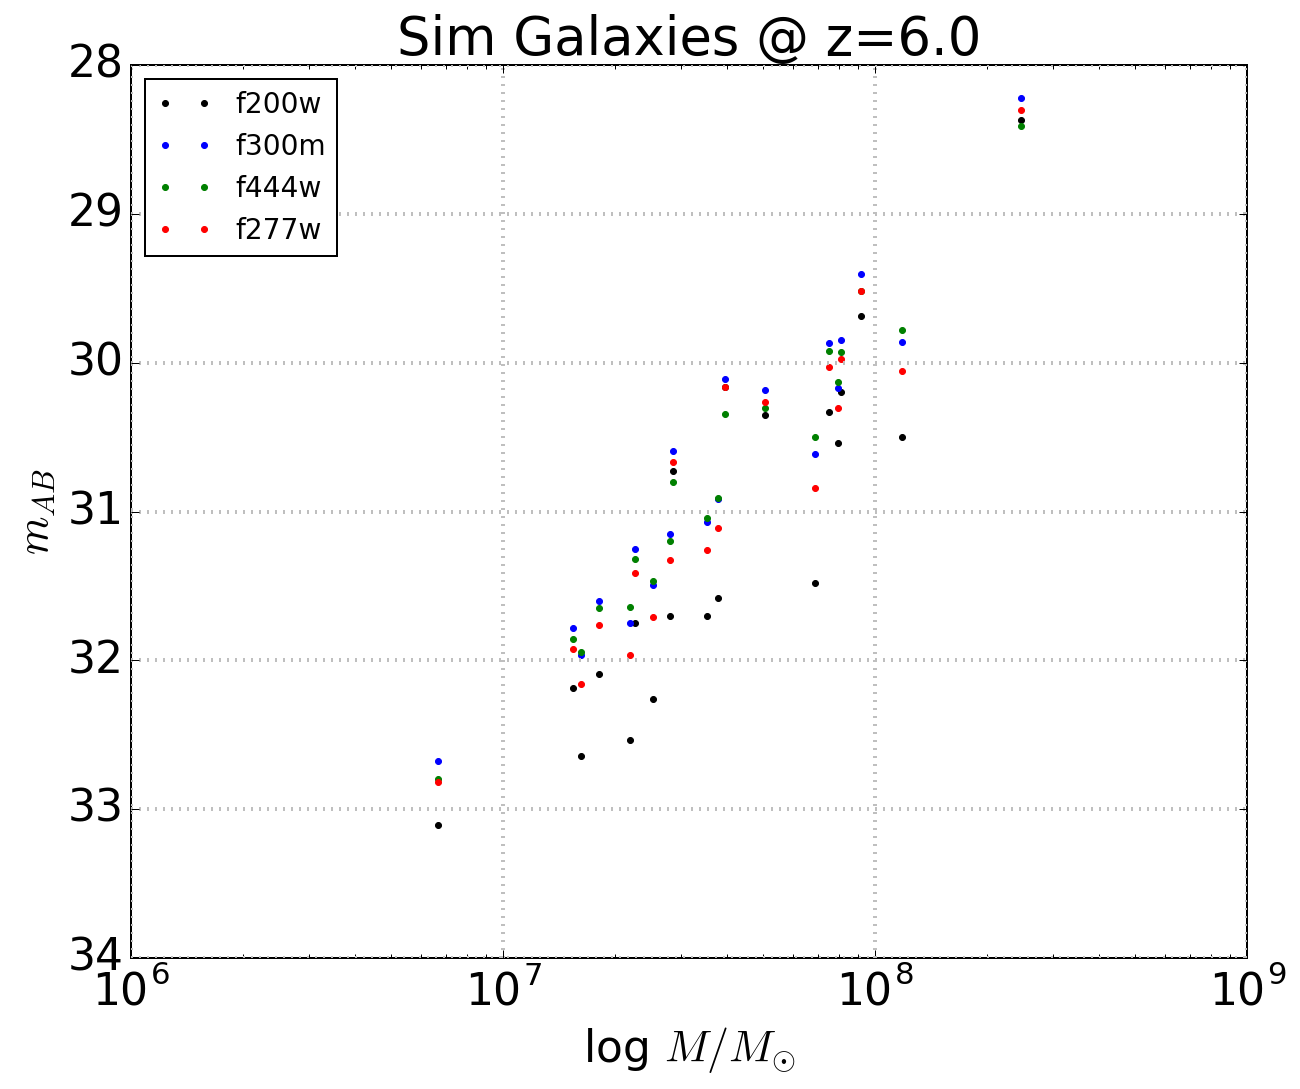

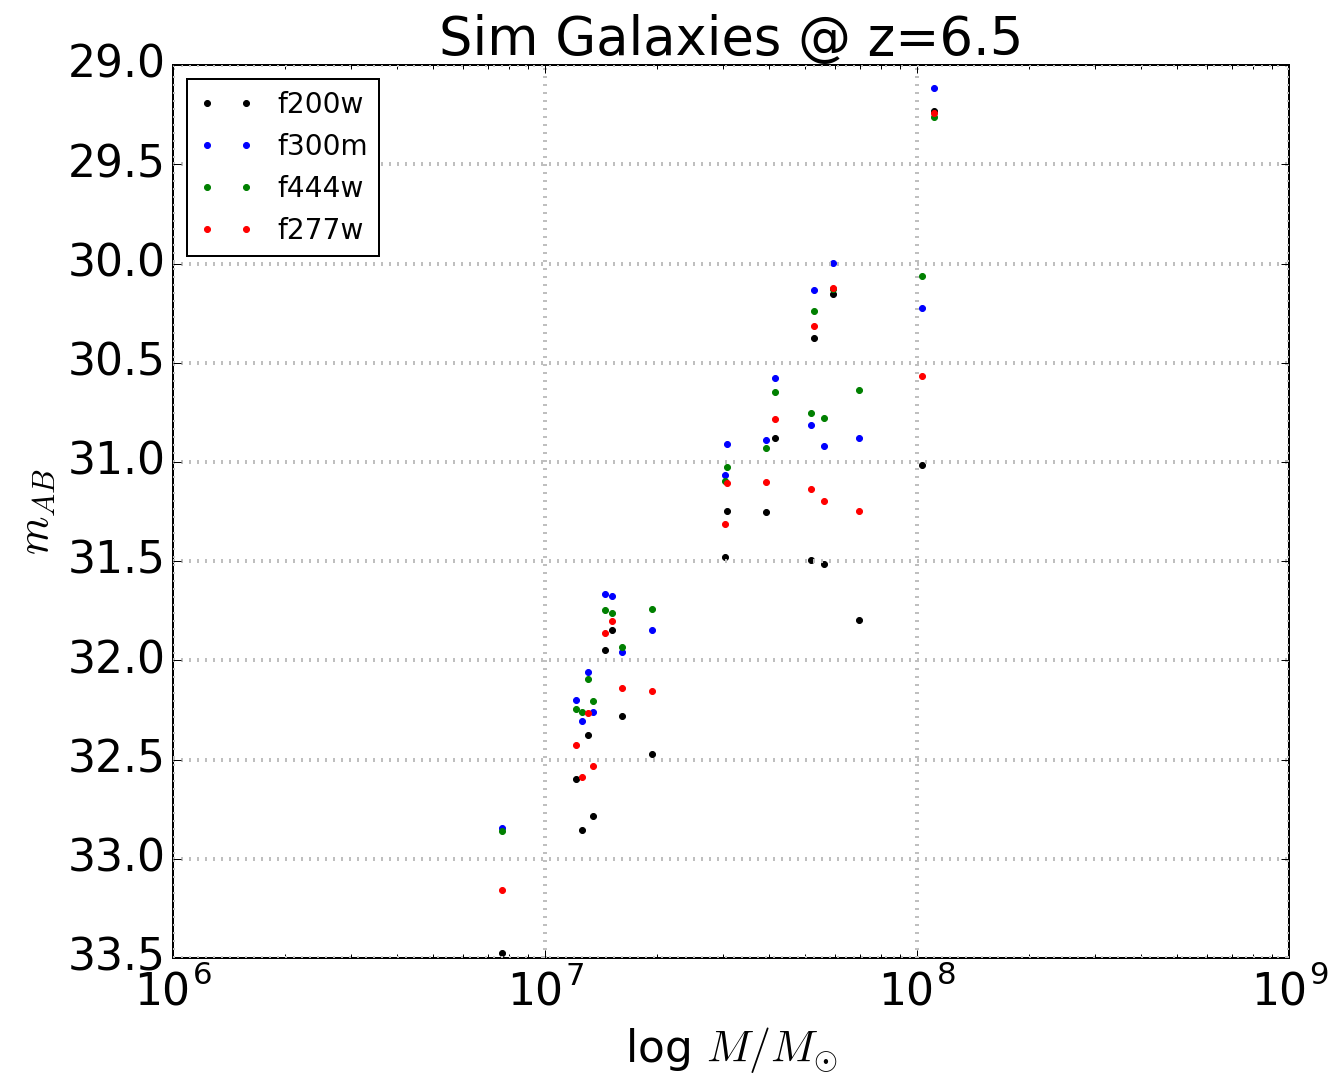

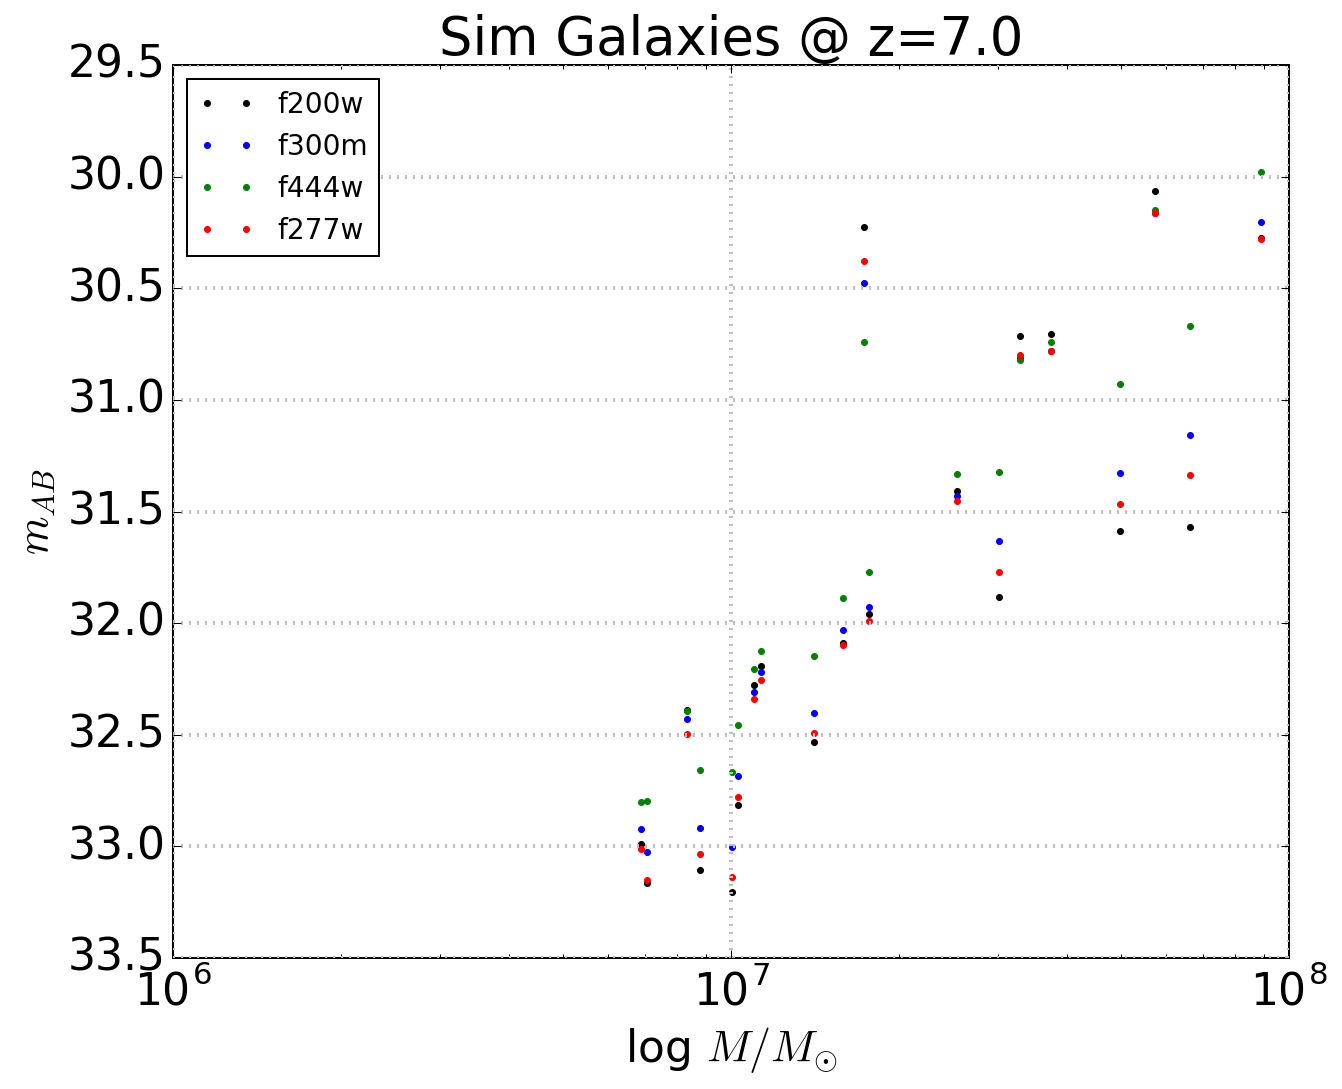

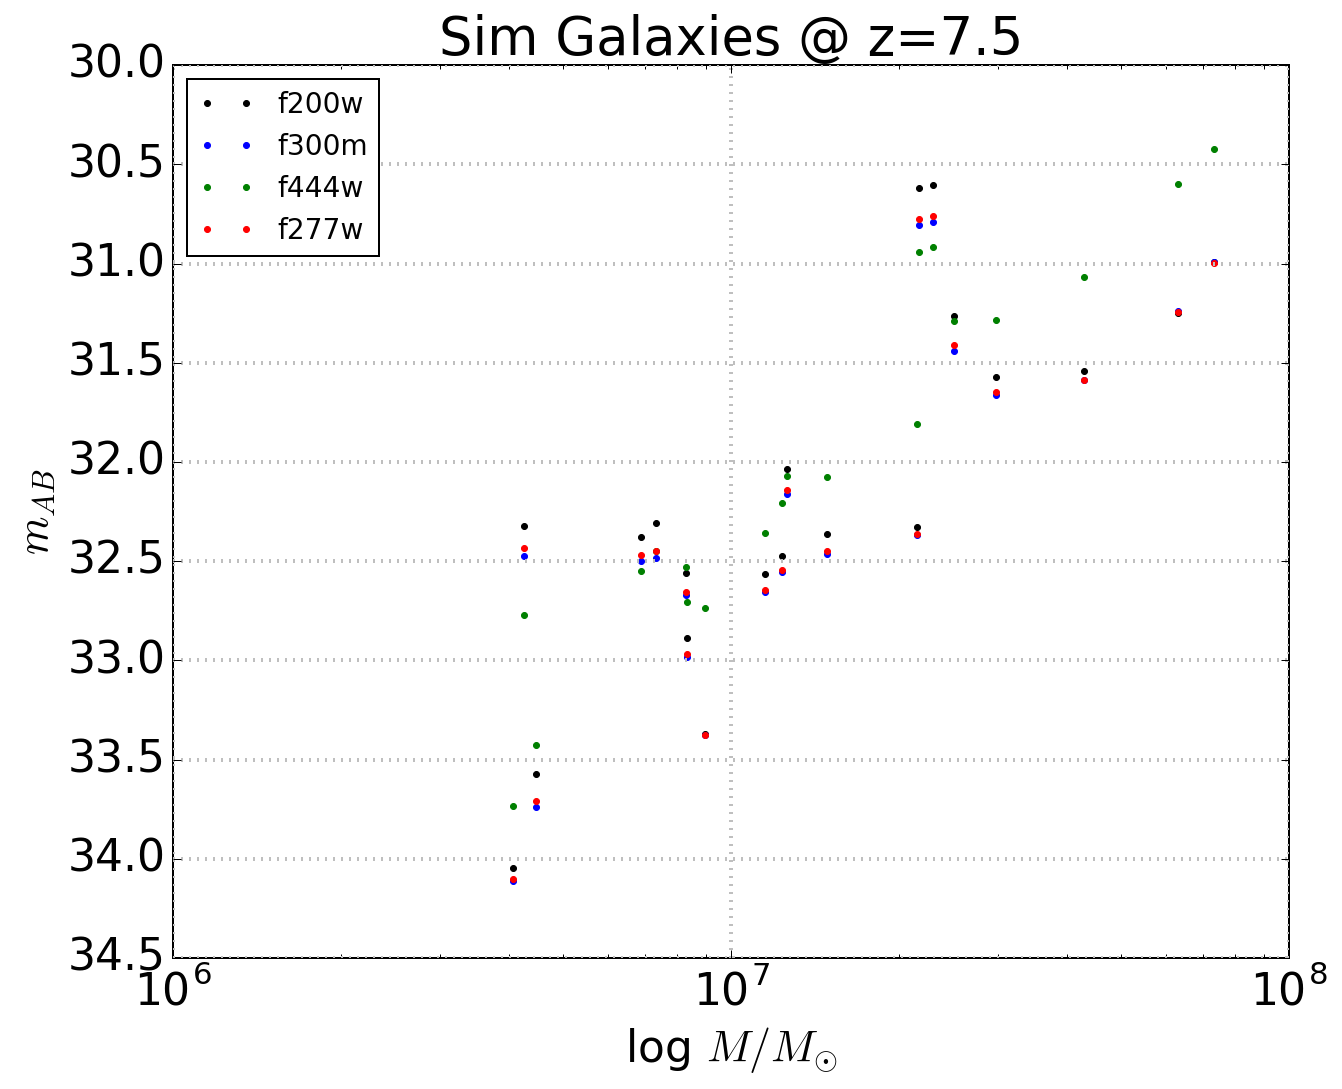

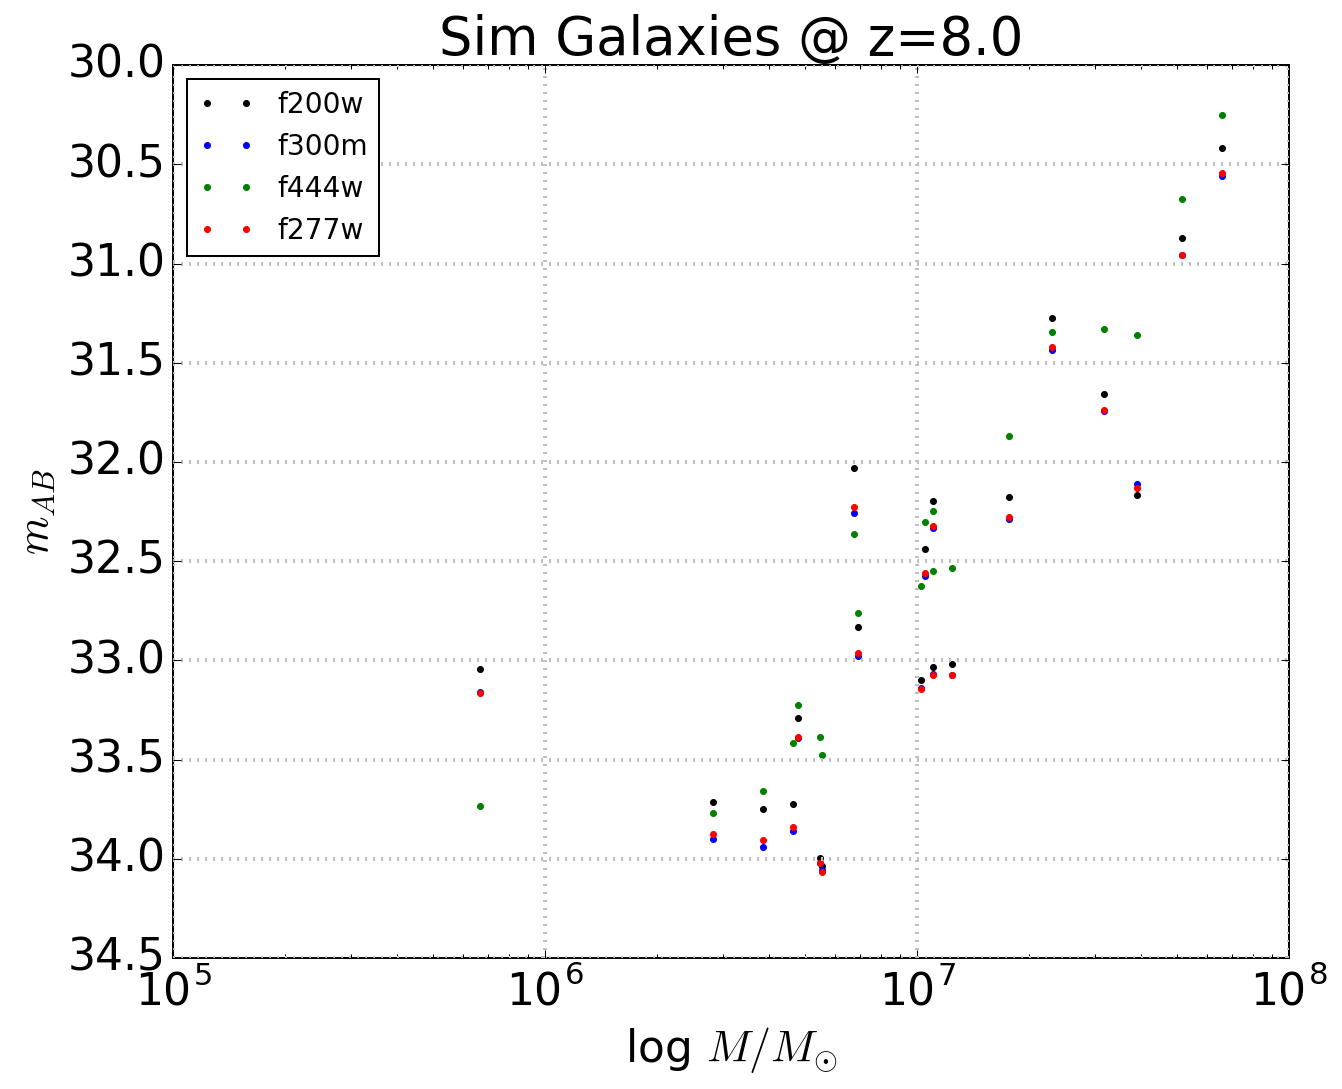

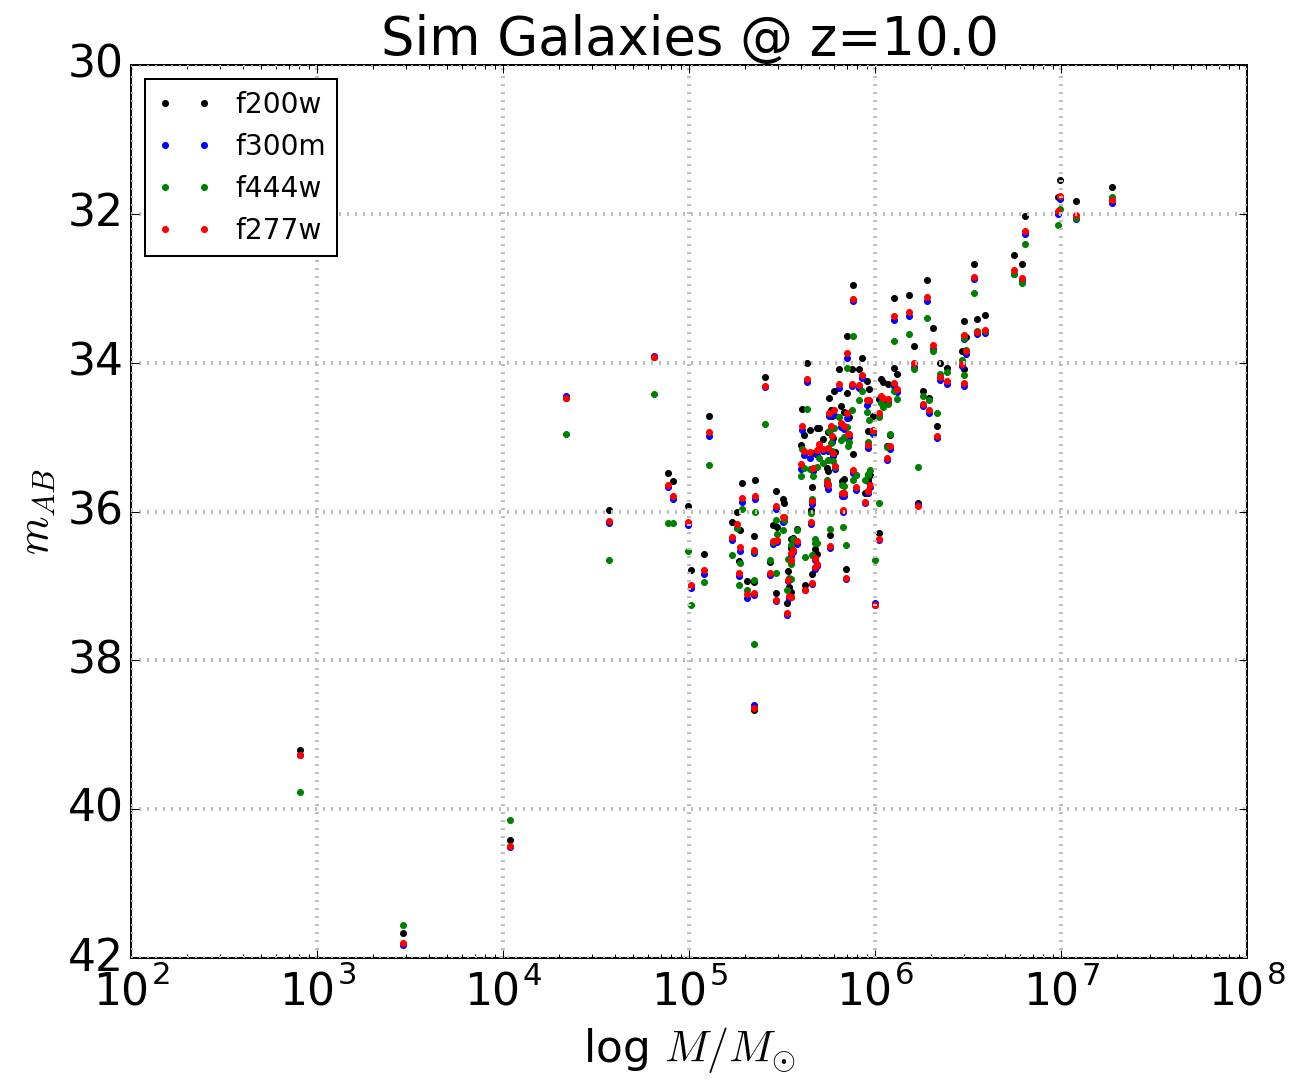

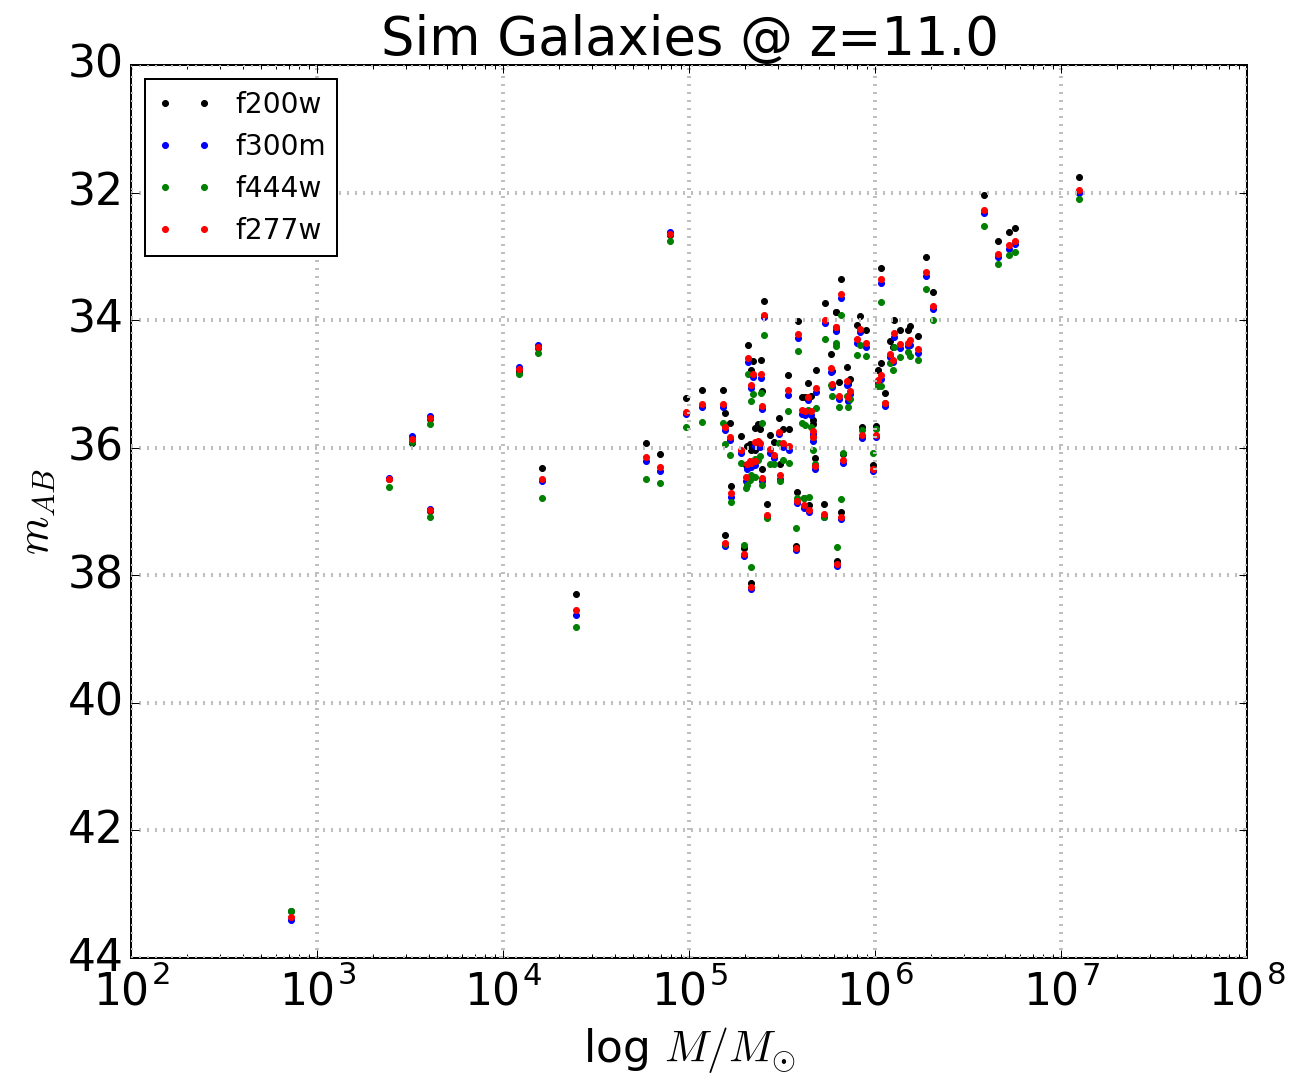

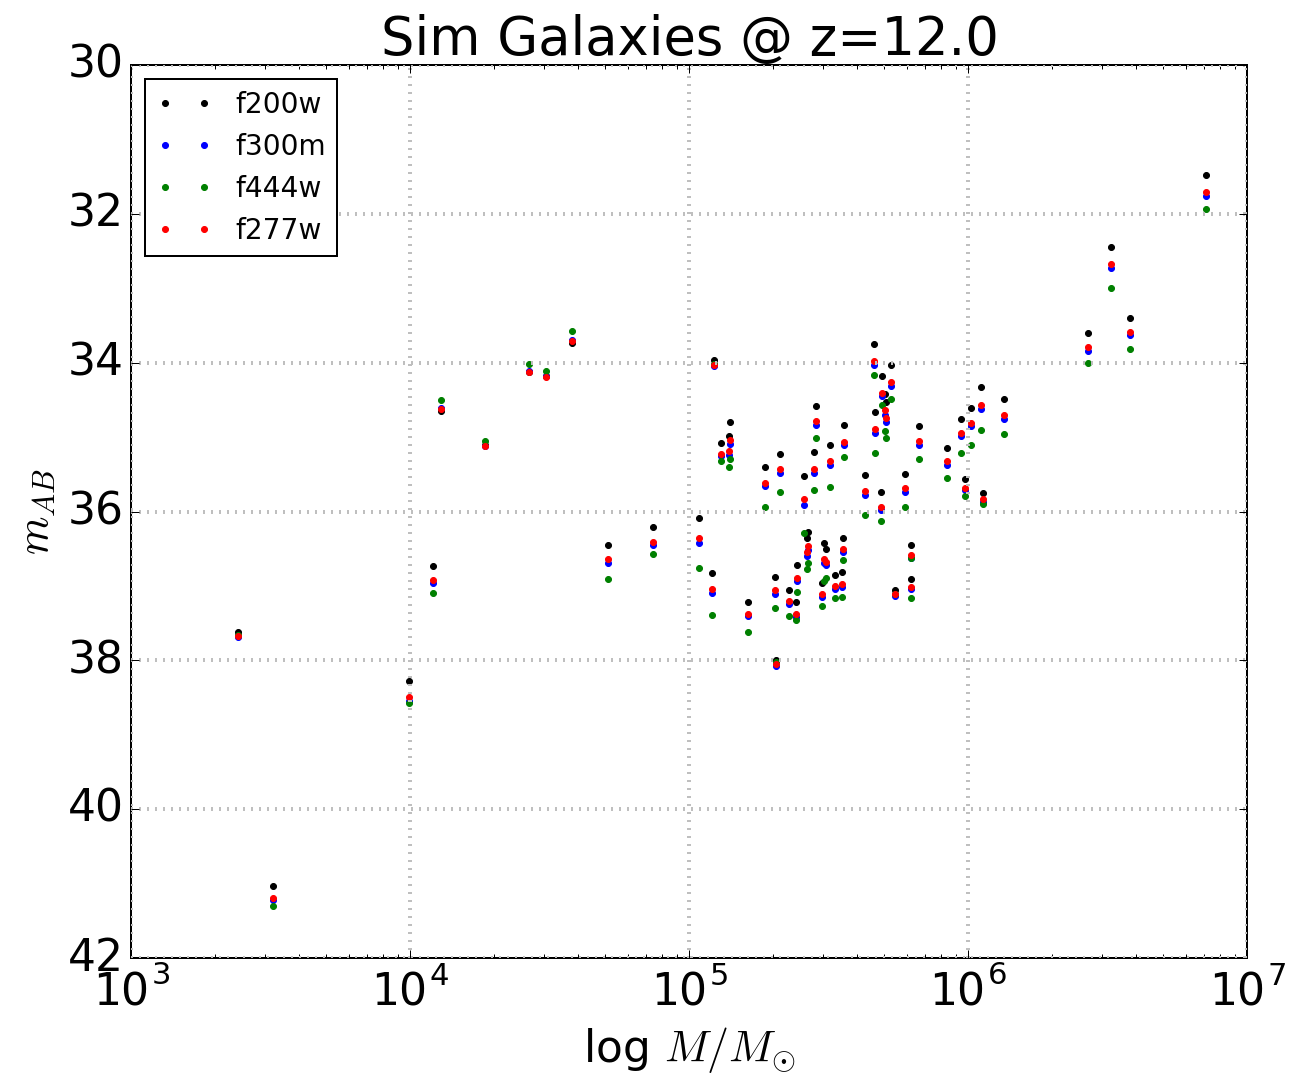

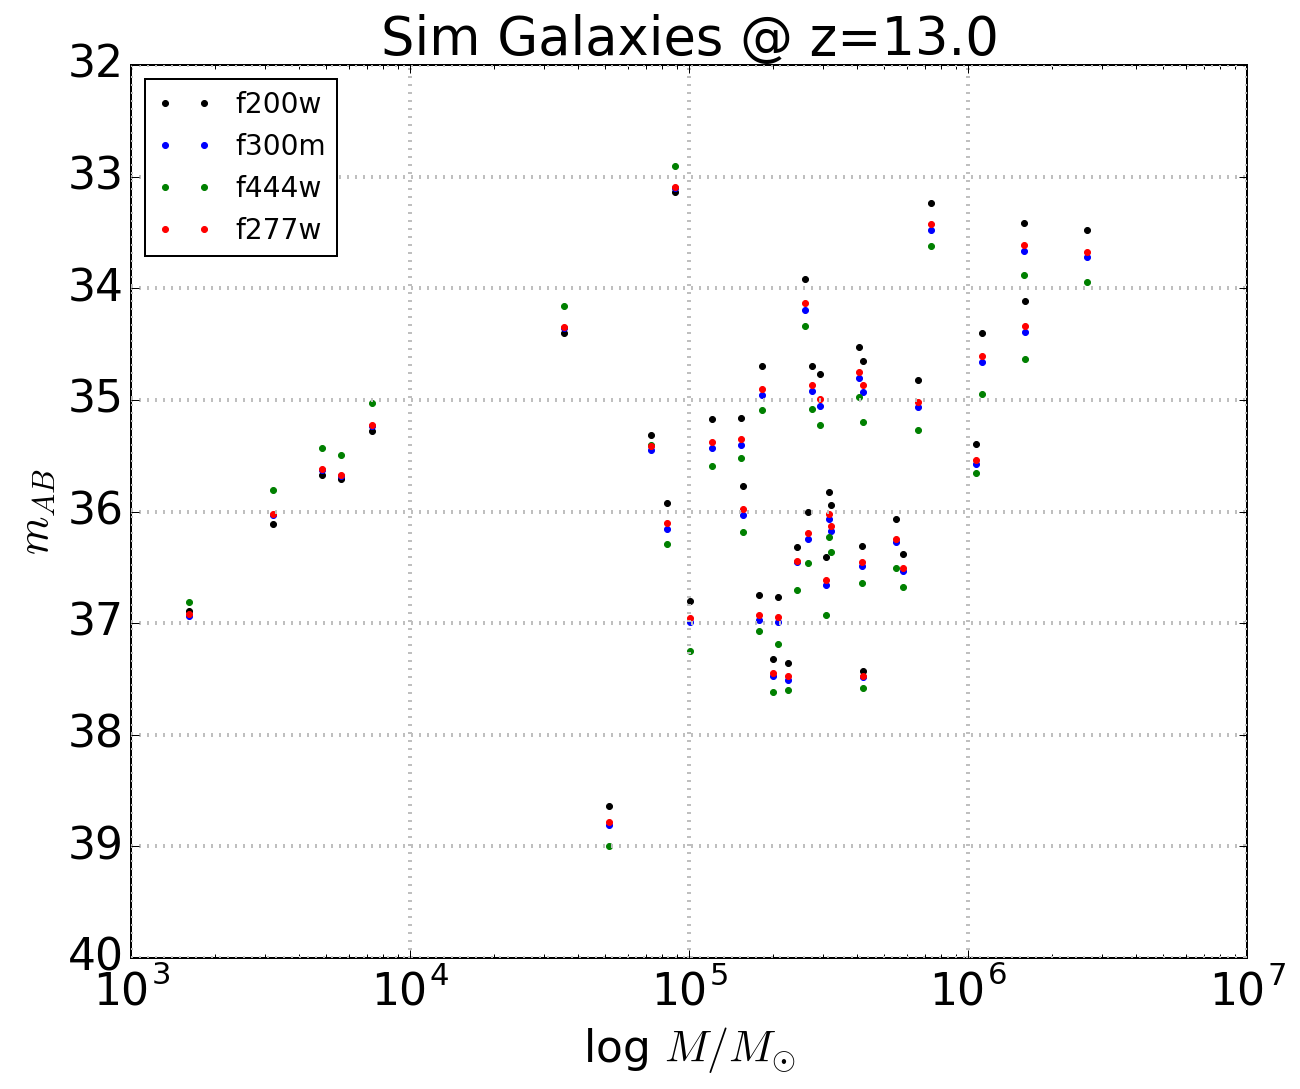

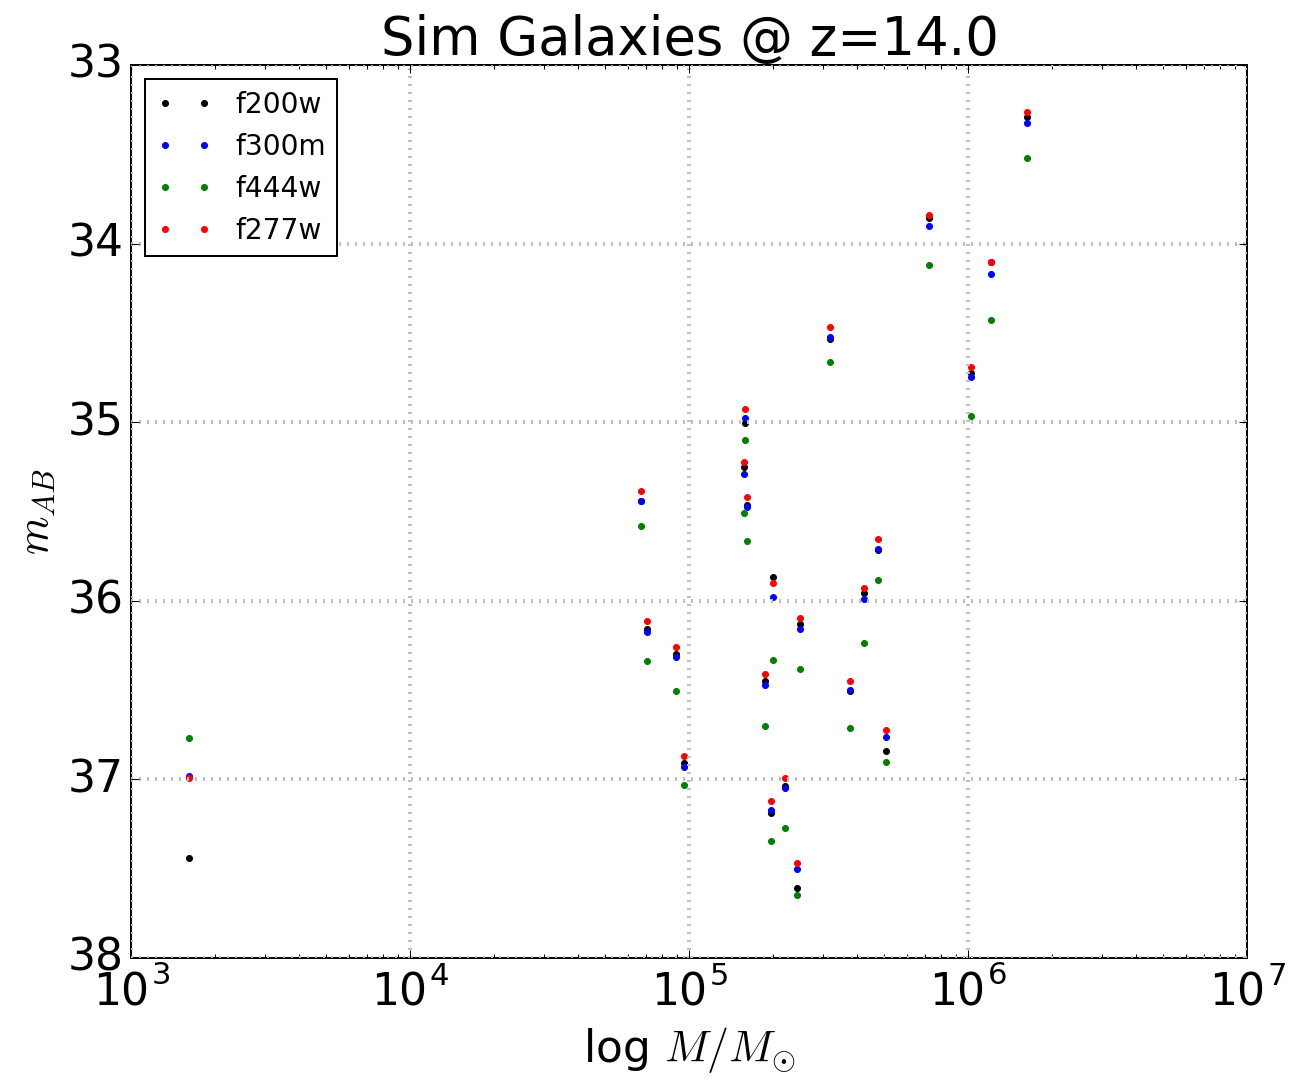

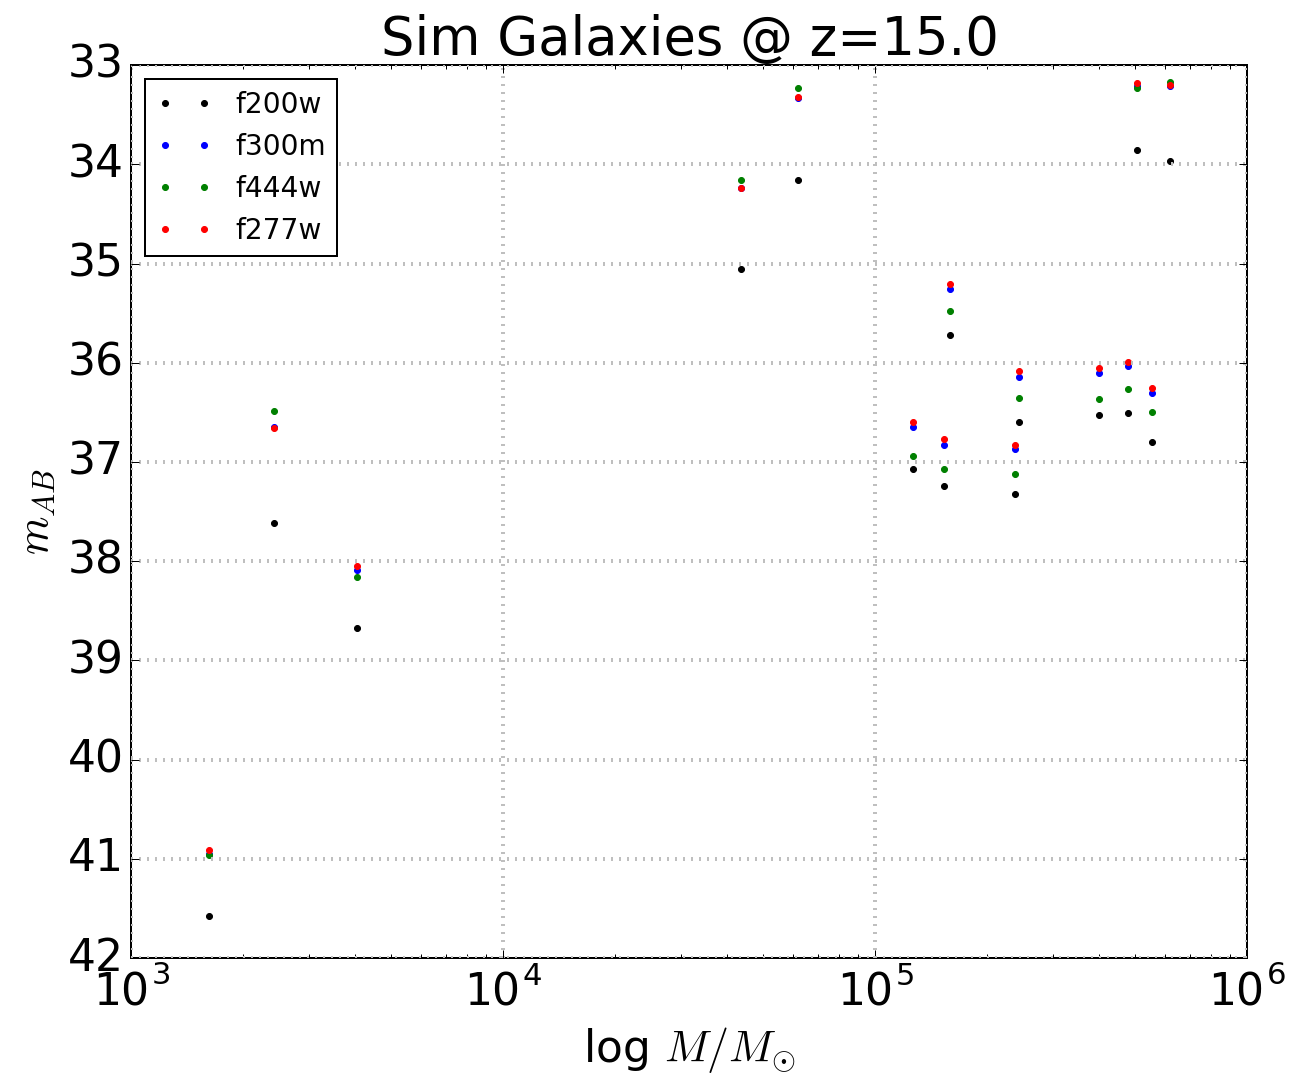

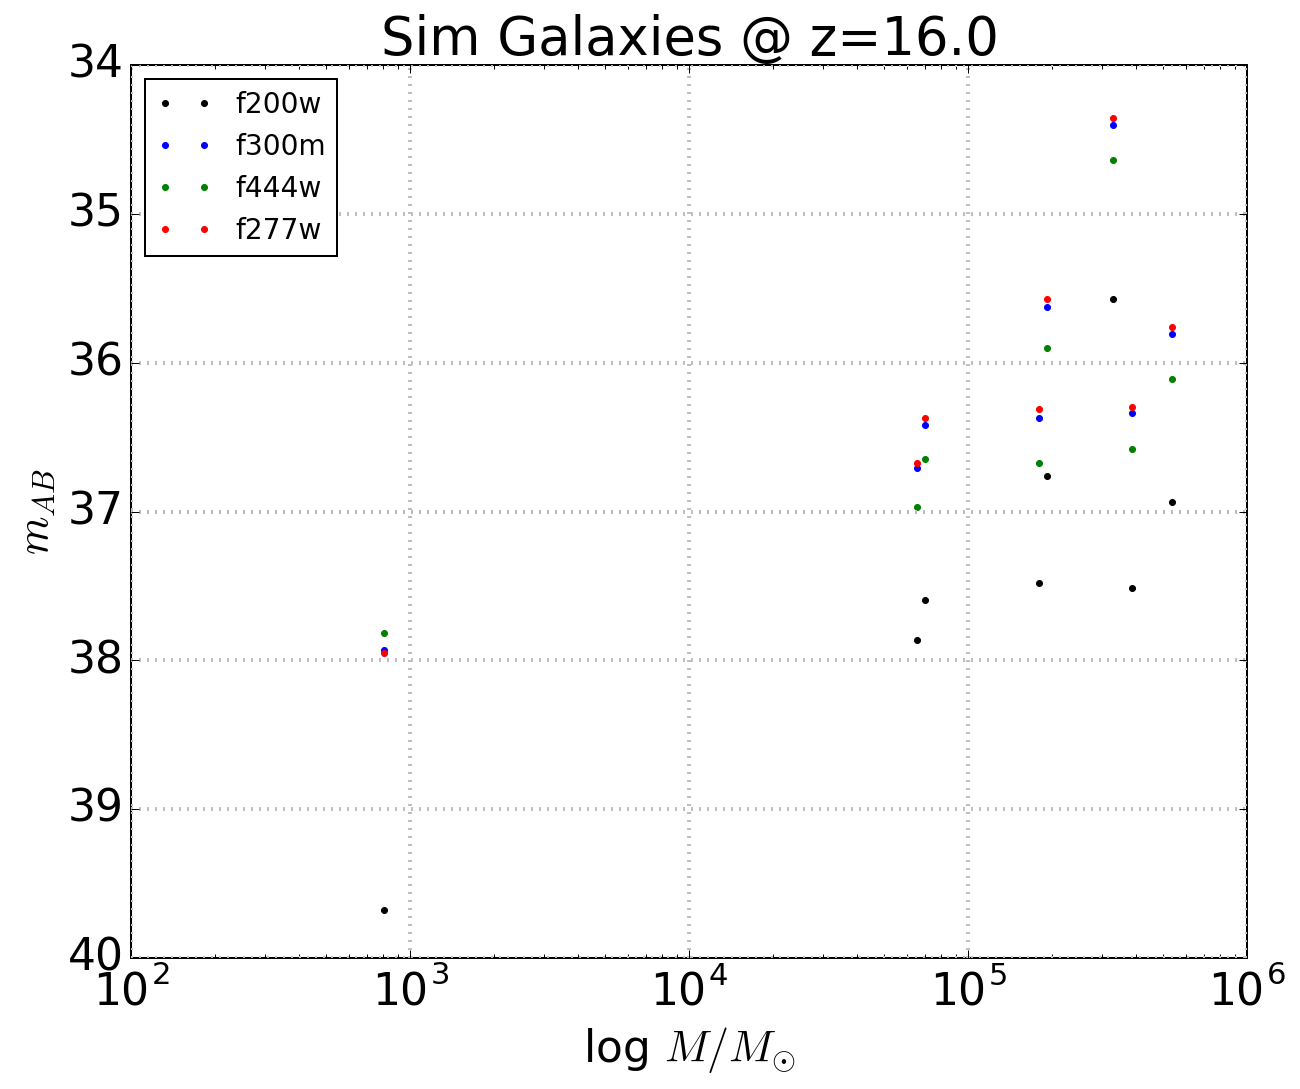

In [61]:
for z in np.sort(thezs):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    ax.set_xscale('log')
    ax.set_yscale('linear')

    ax.set_title('Sim Galaxies @ z={}'.format(z))
    ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['f200w']),'k.')
    ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['f300m']),'b.')
    ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['f444w']),'g.')
    ax.plot(fluxes[z]['MM_sun'],mag(fluxes[z]['f277w']),'r.')

#     ax.set_ylim([25,38])
    ax.set_xlabel('log $M/M_{\odot}$')
    ax.set_ylabel(r'$m_{AB}$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

    ax.legend(['f200w','f300m','f444w','f277w'], 
              loc='upper left', fontsize=14 )

    plt.gca().invert_yaxis()
    plt.savefig("haloMassVsMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

0

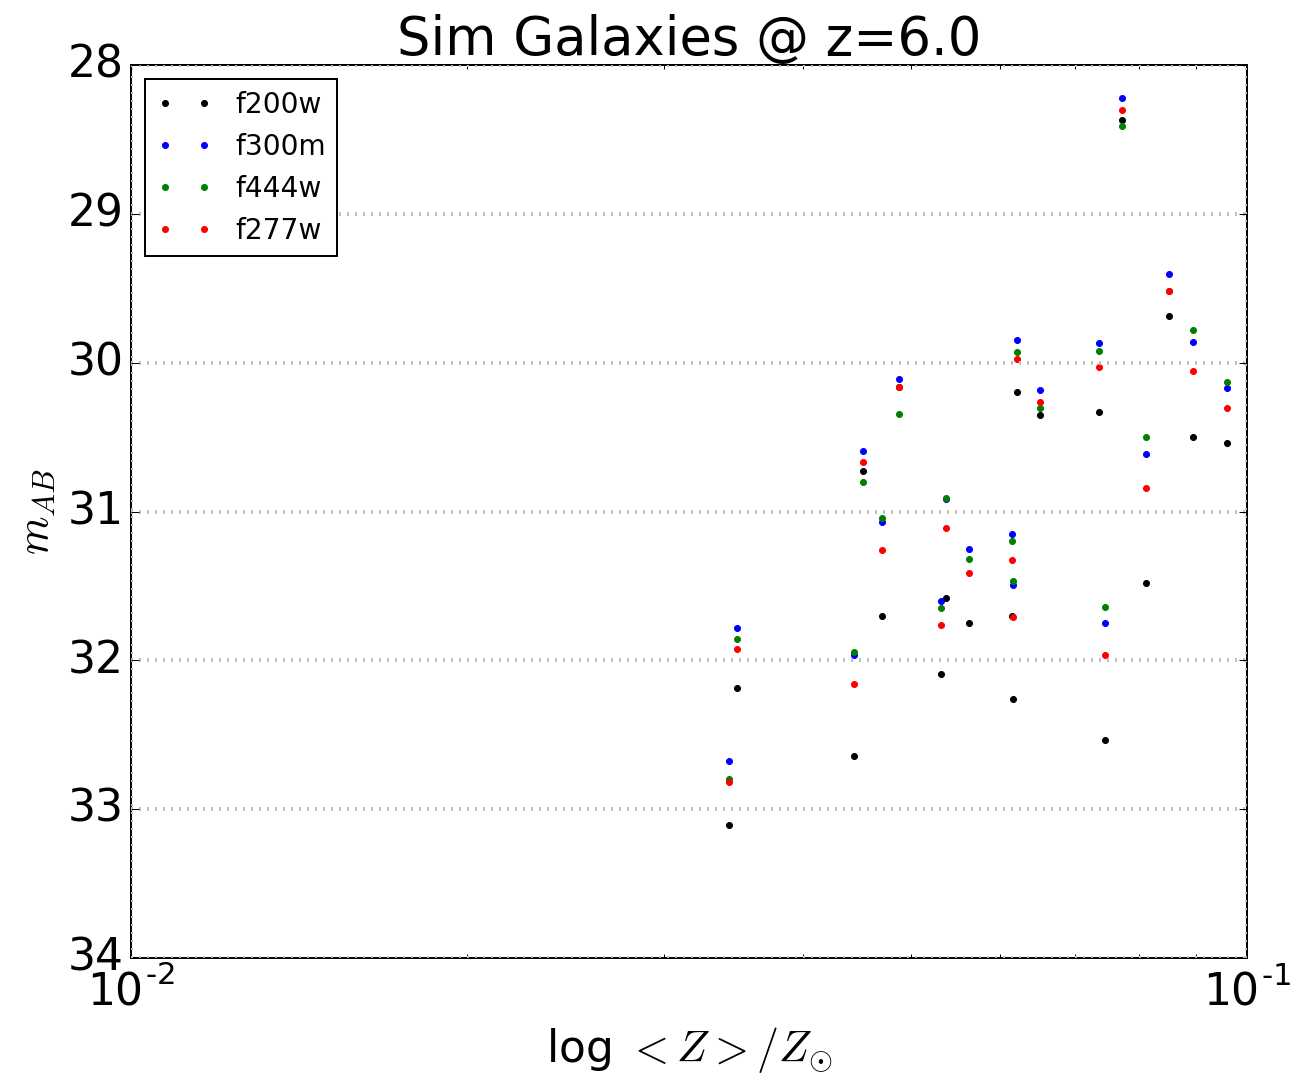

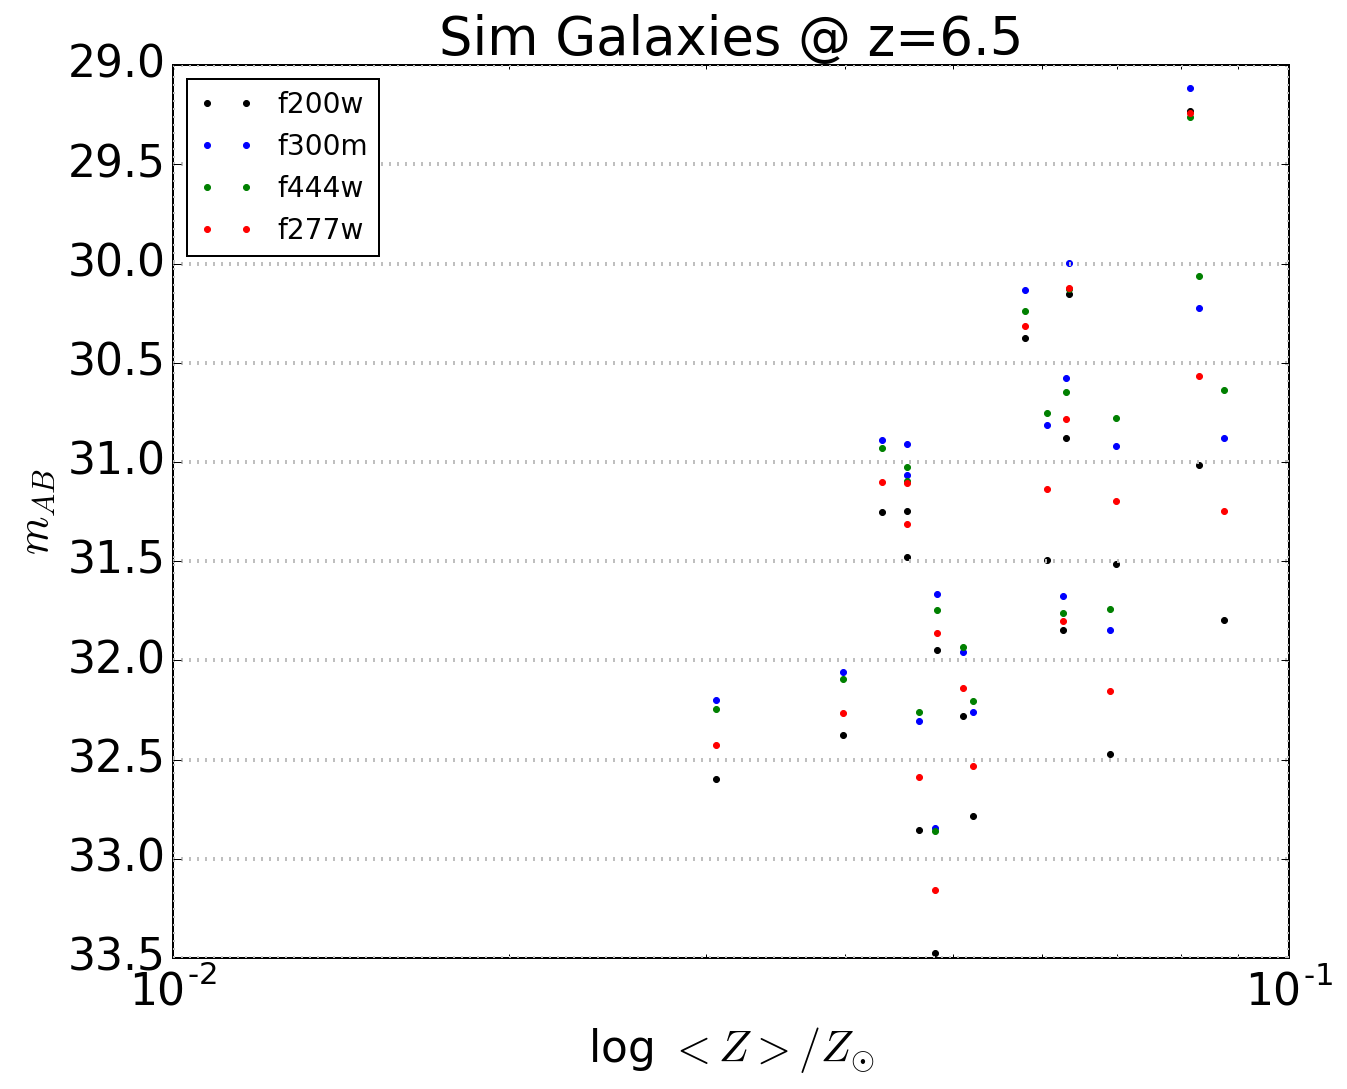

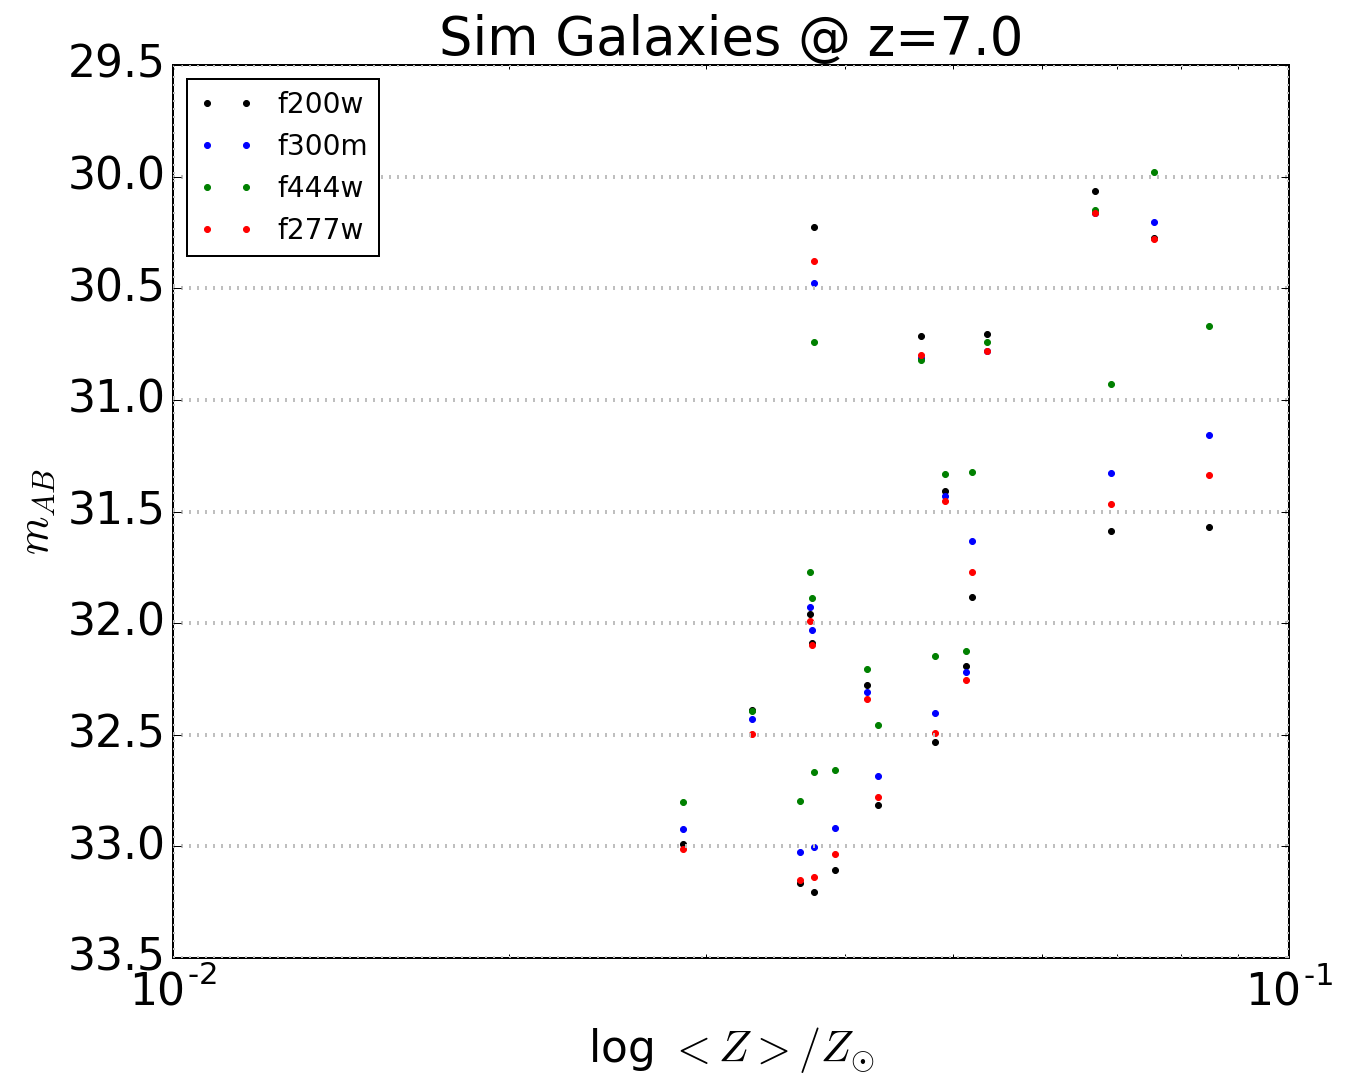

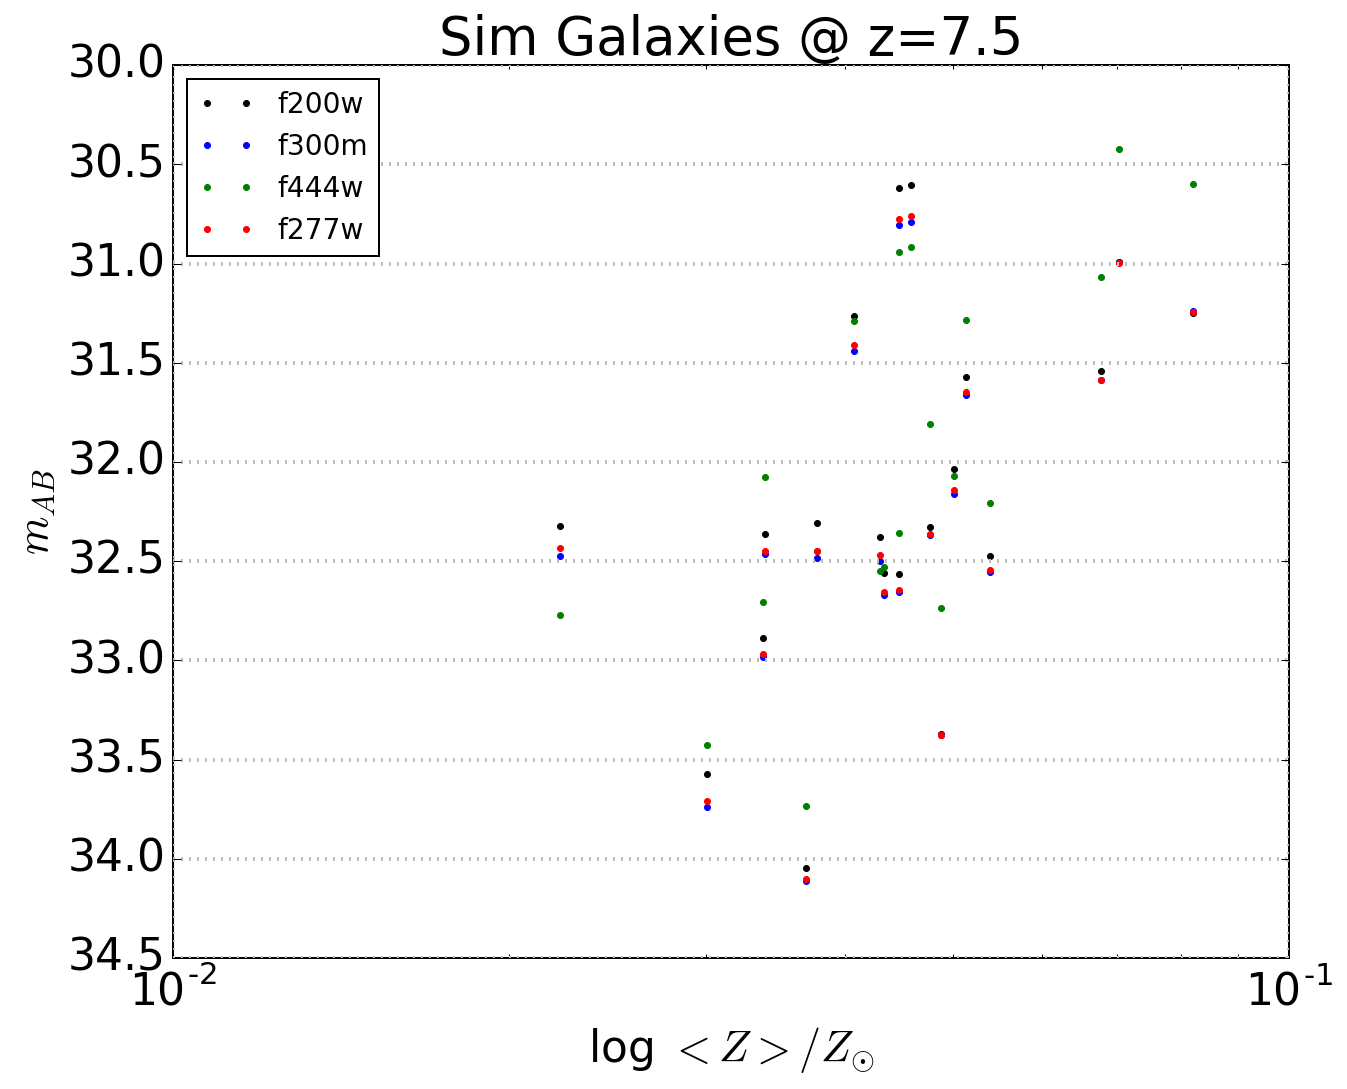

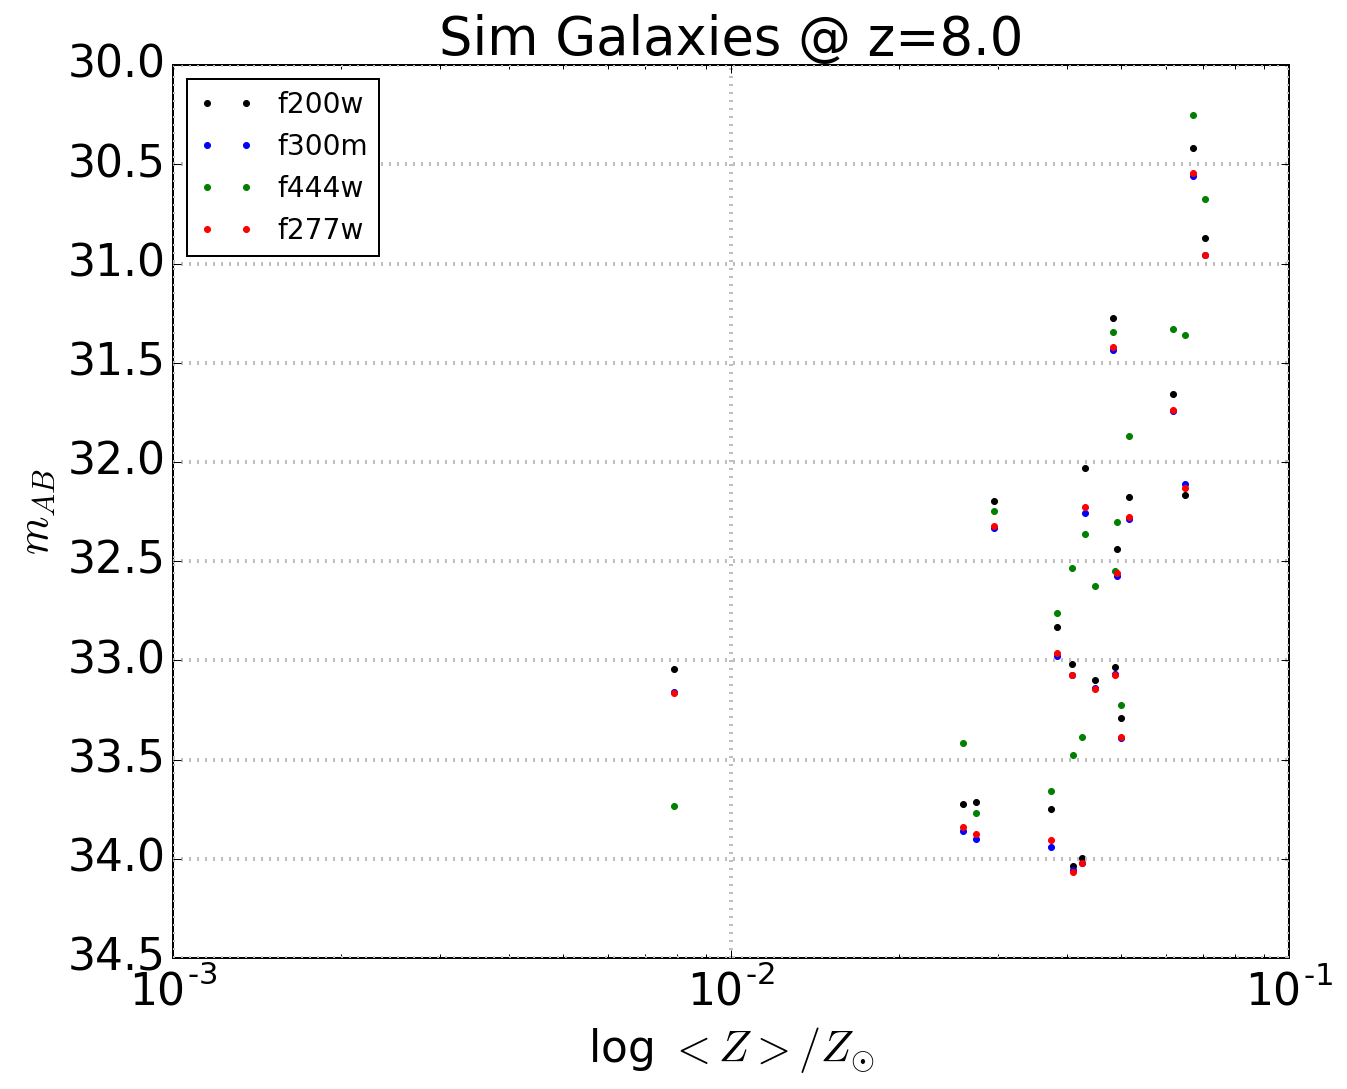

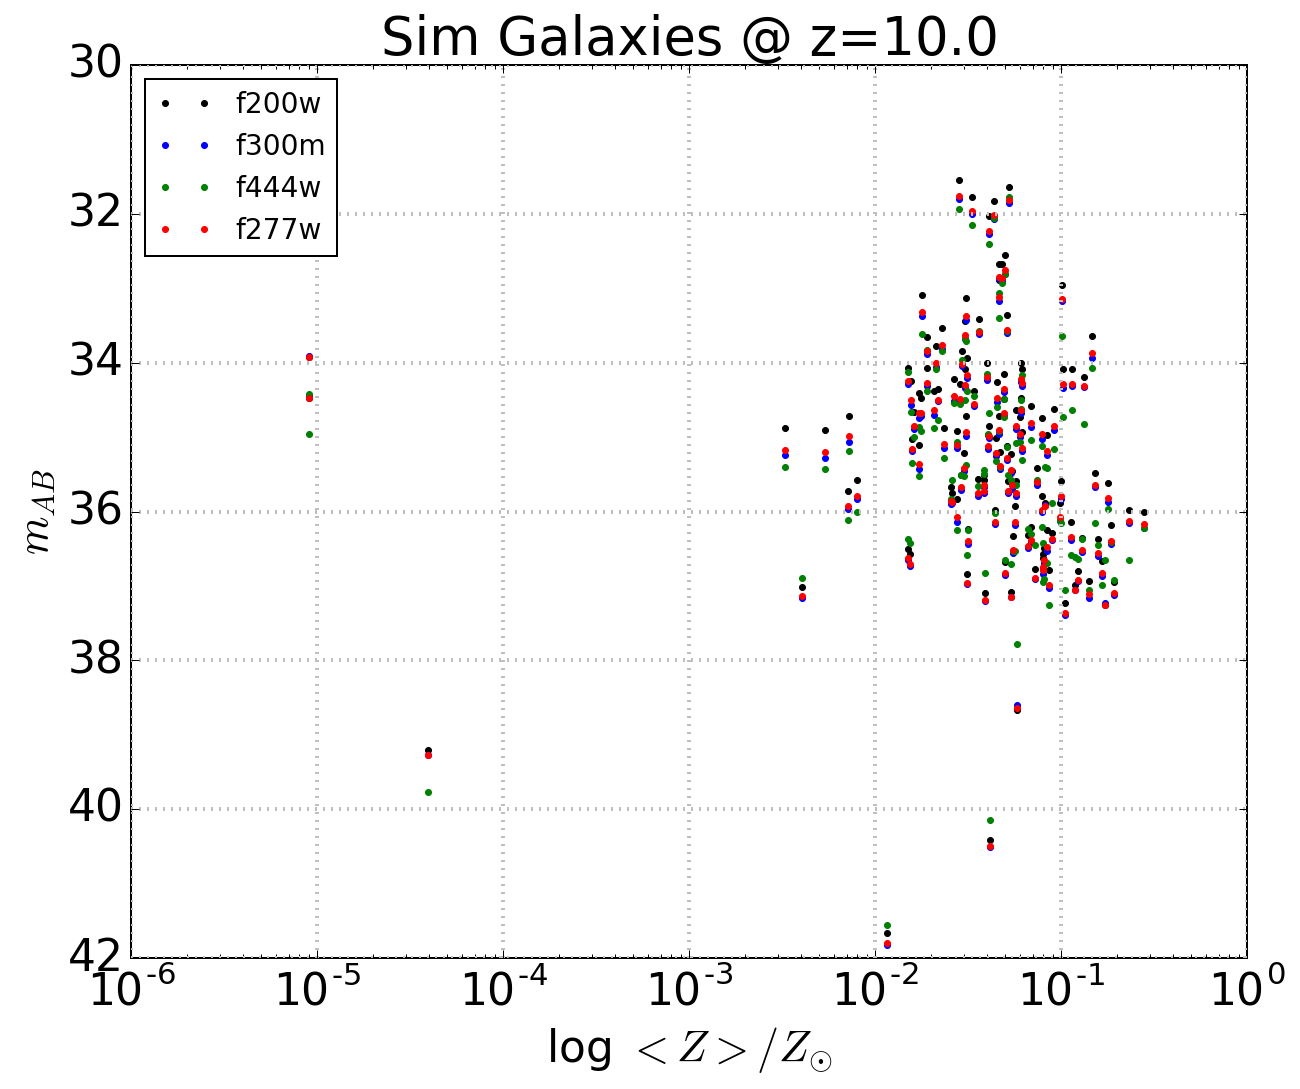

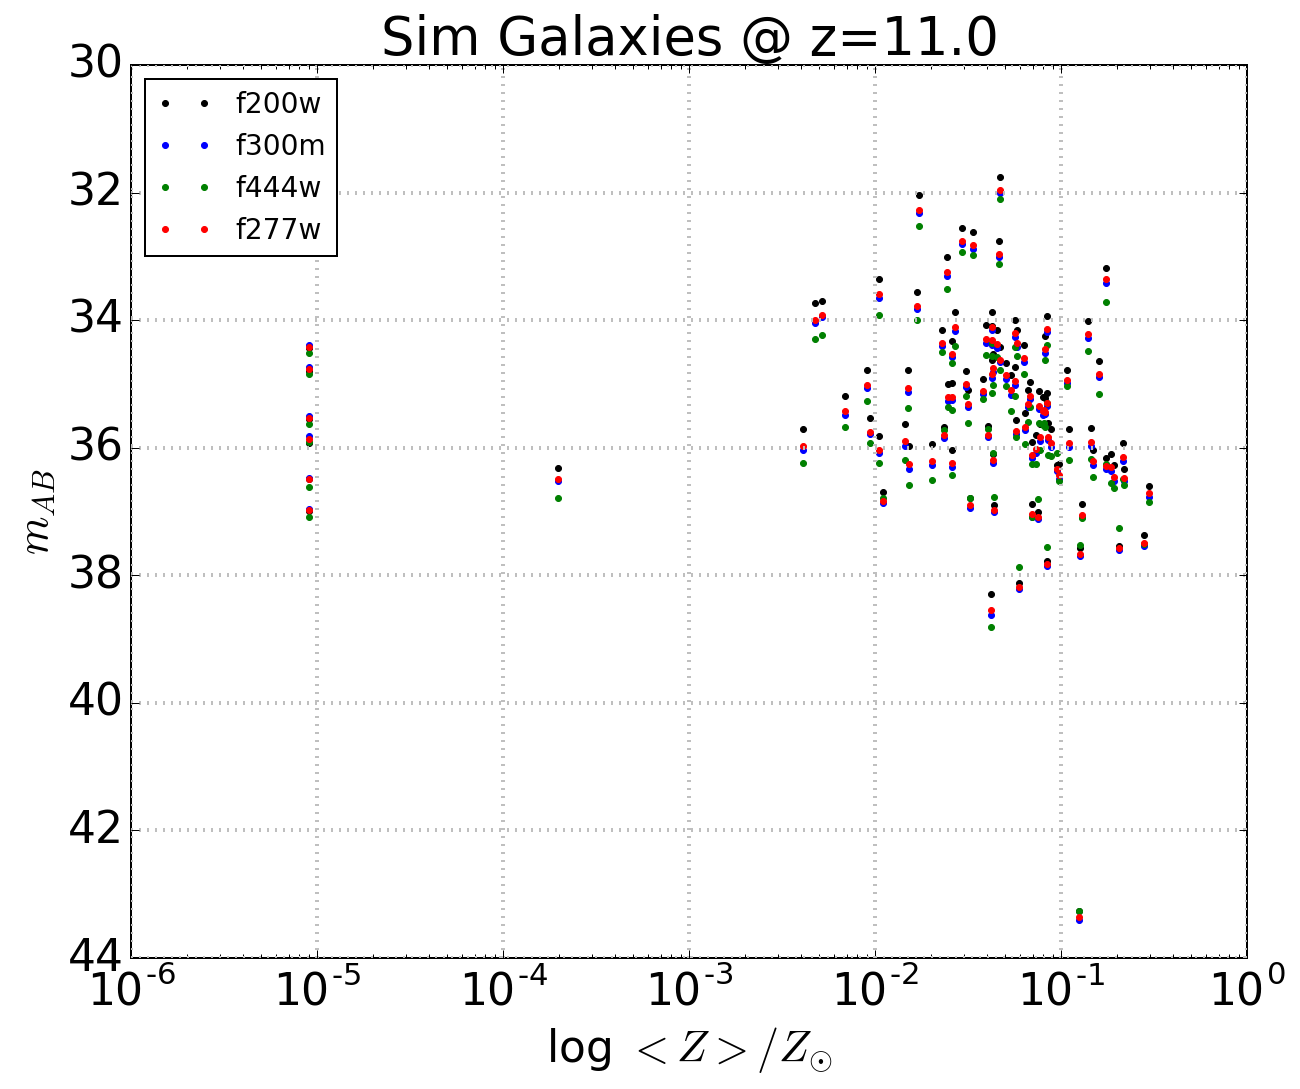

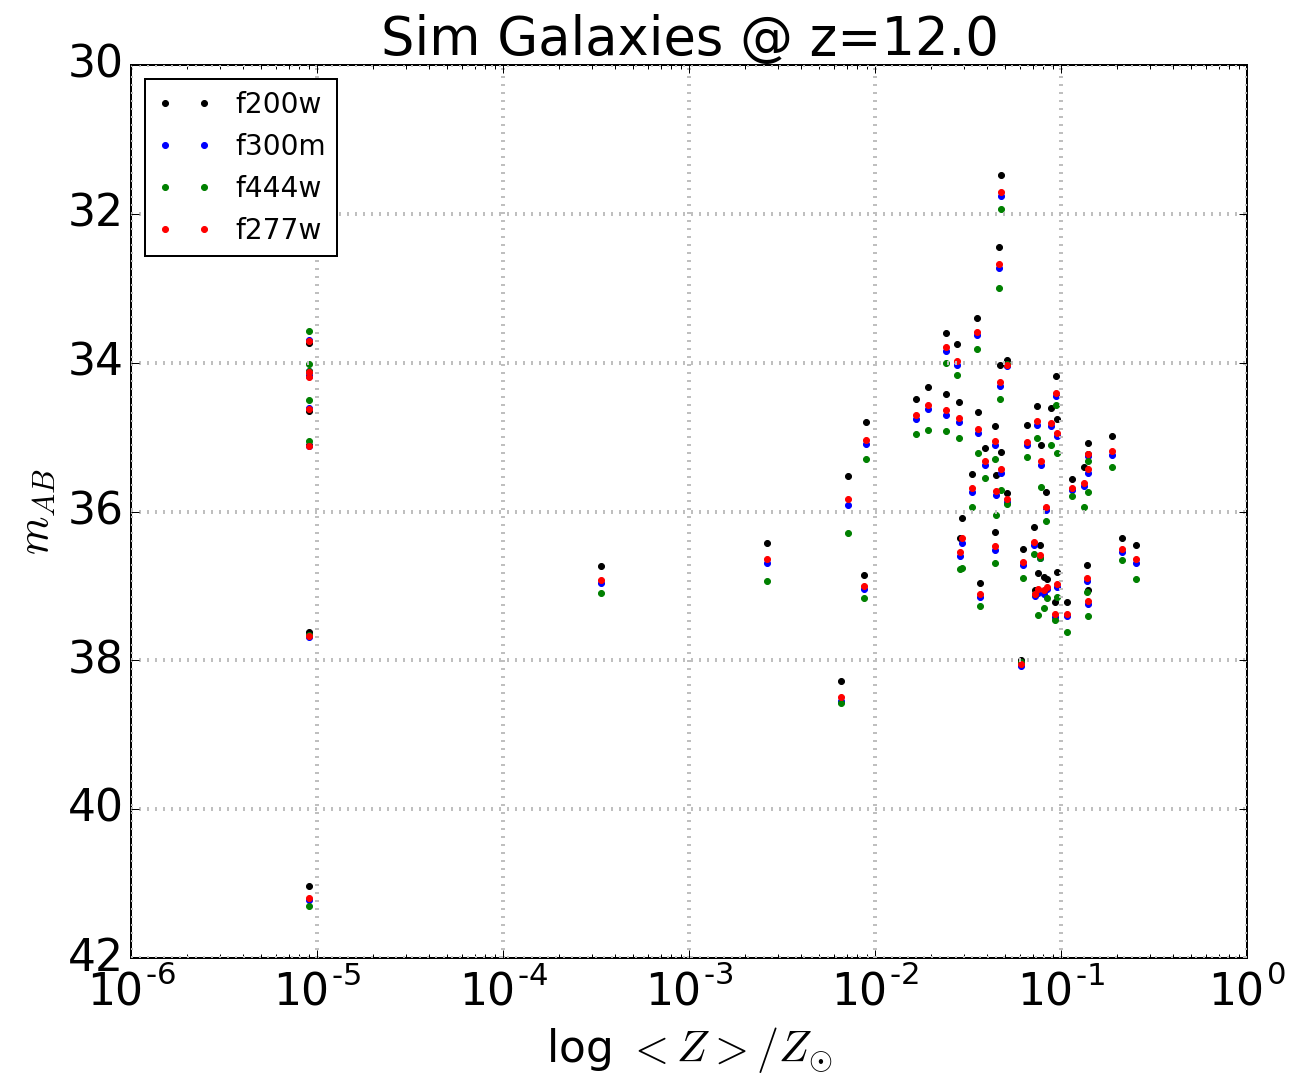

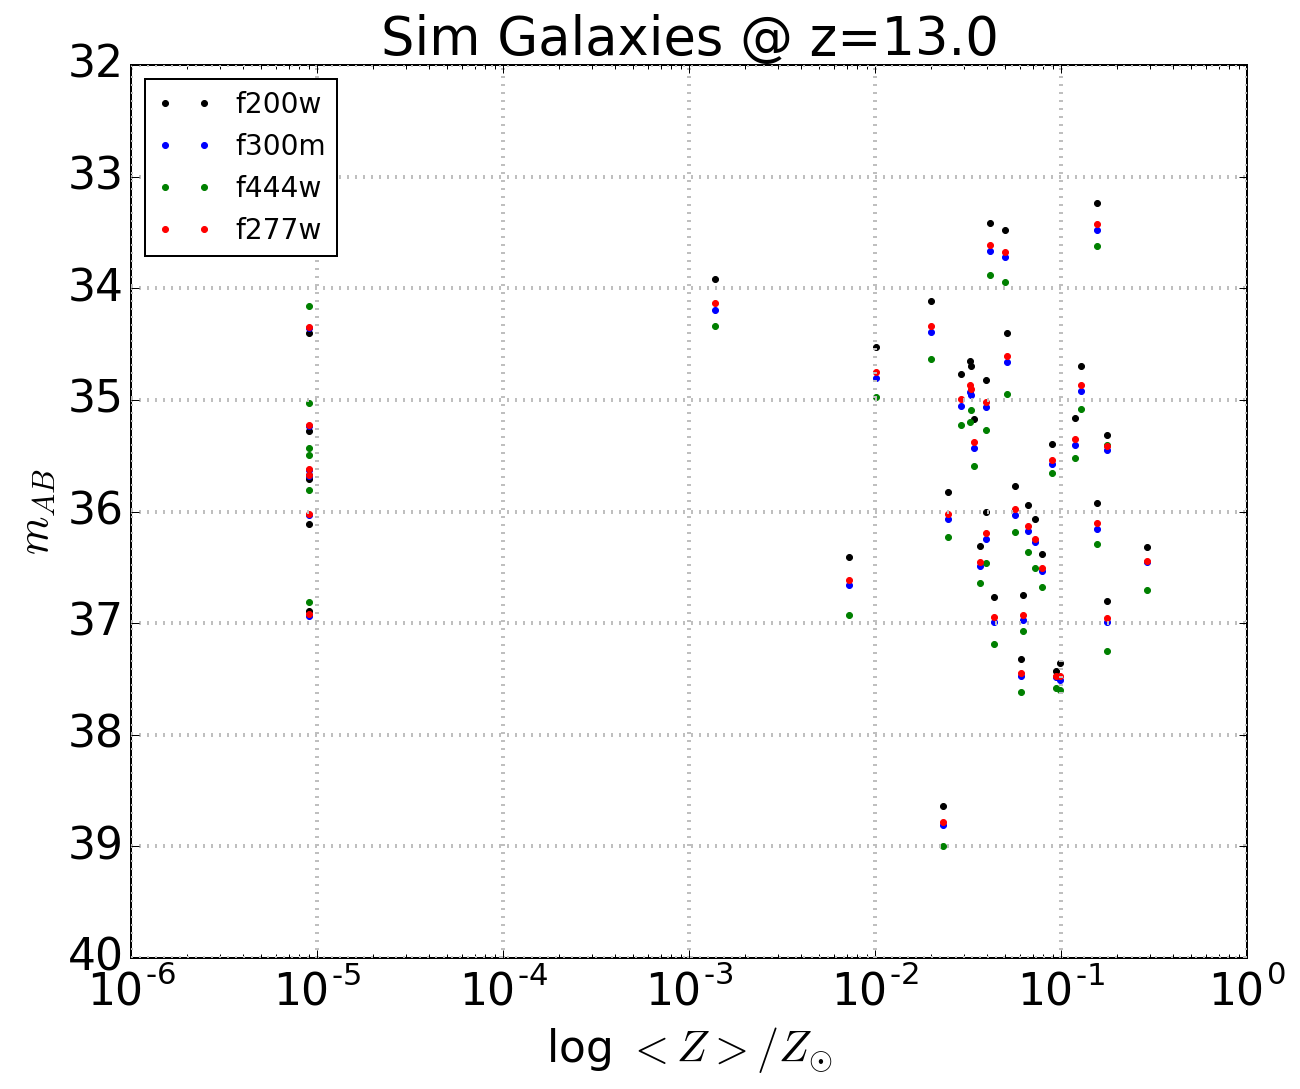

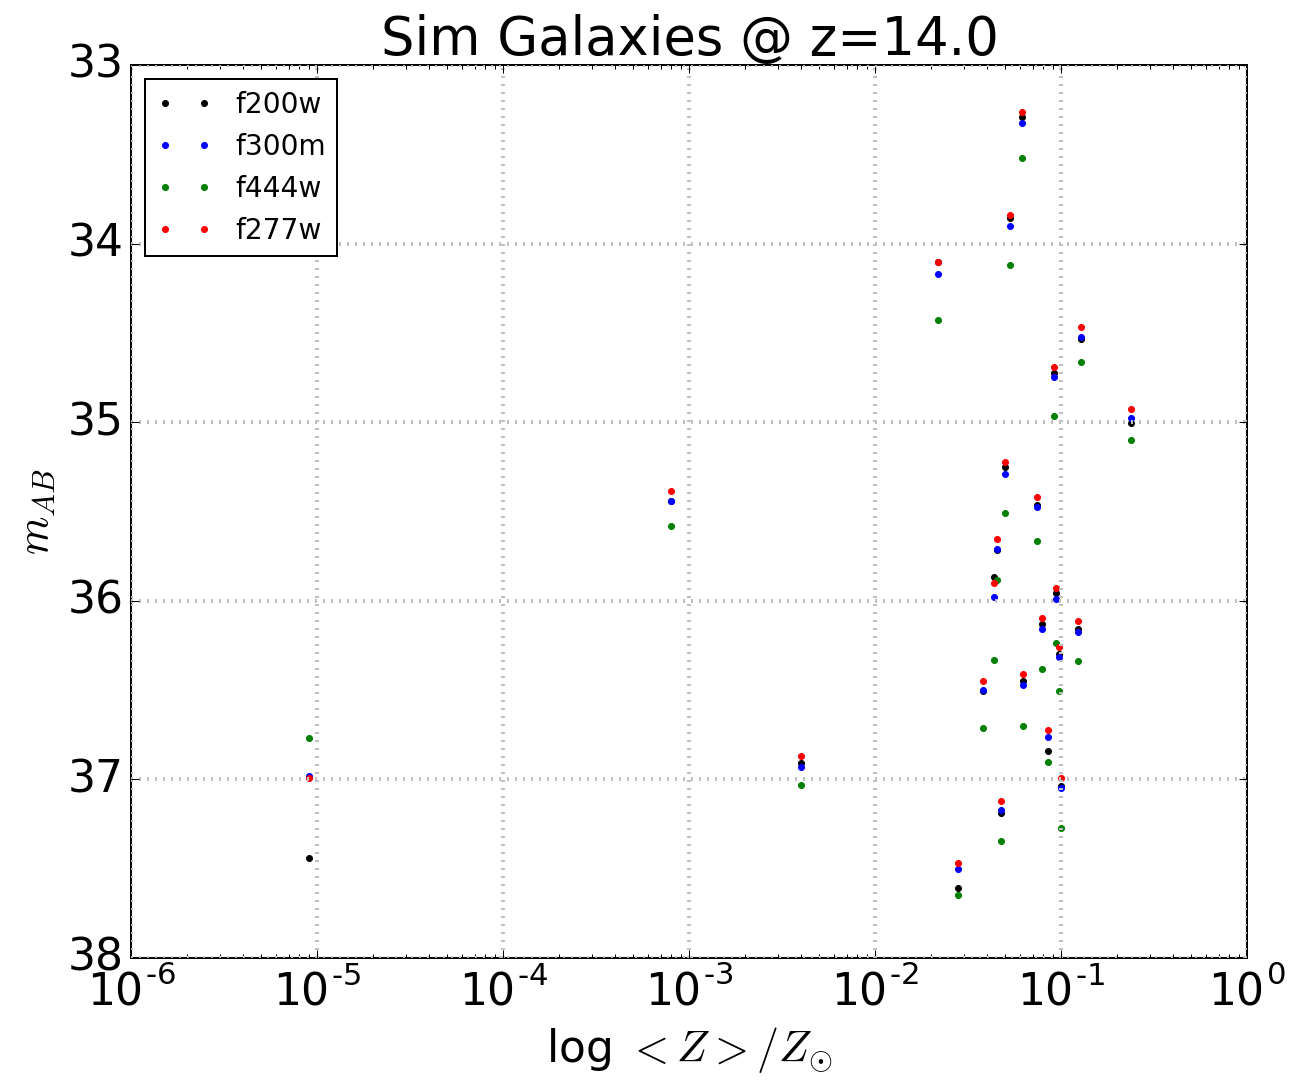

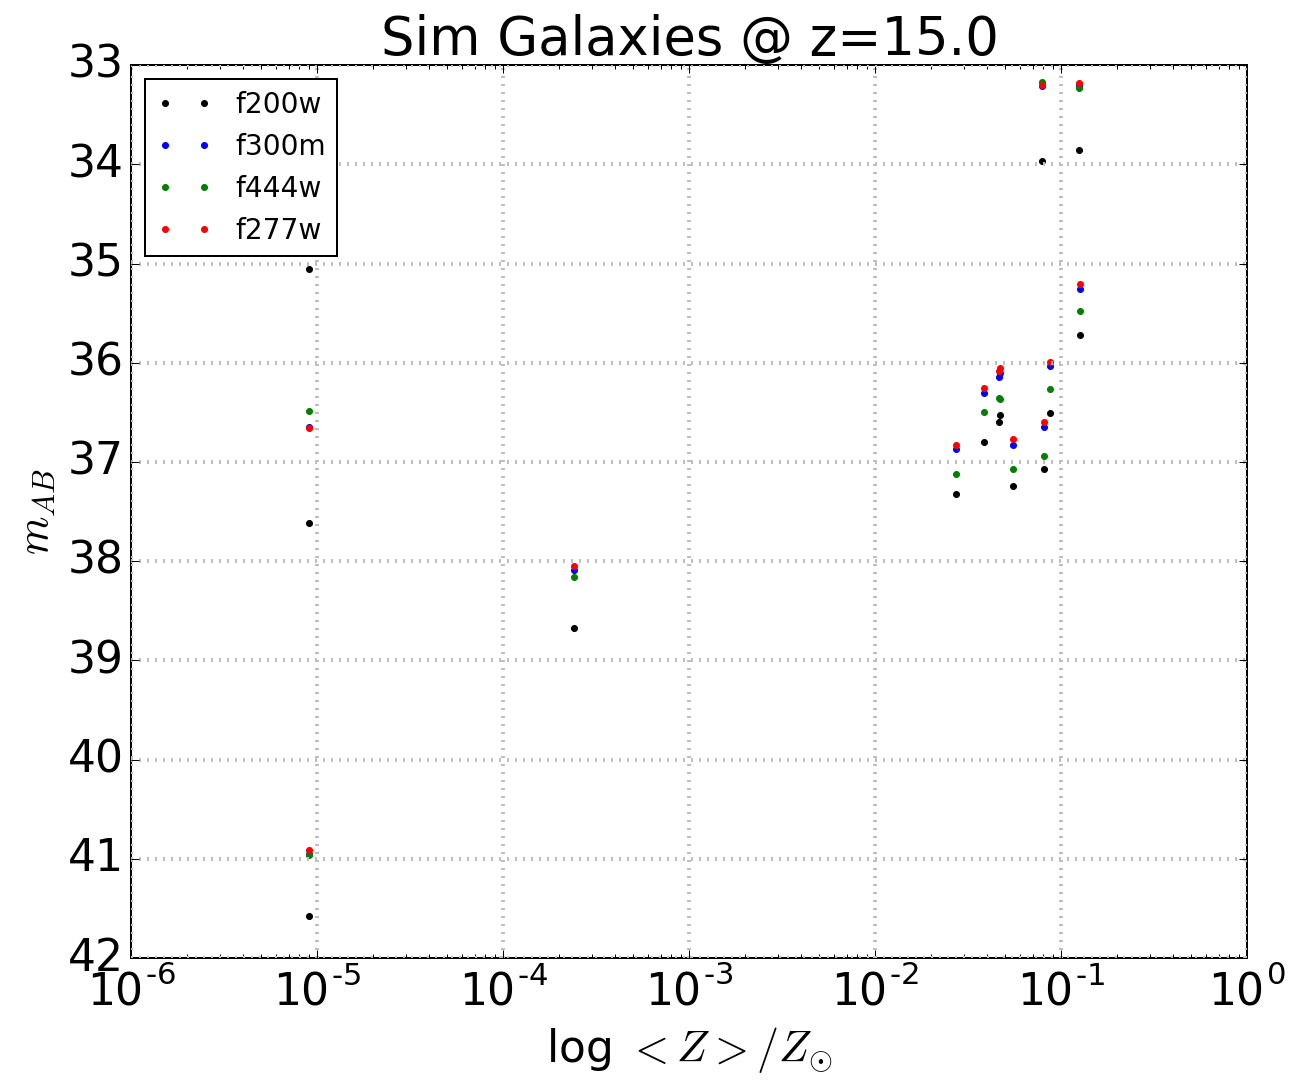

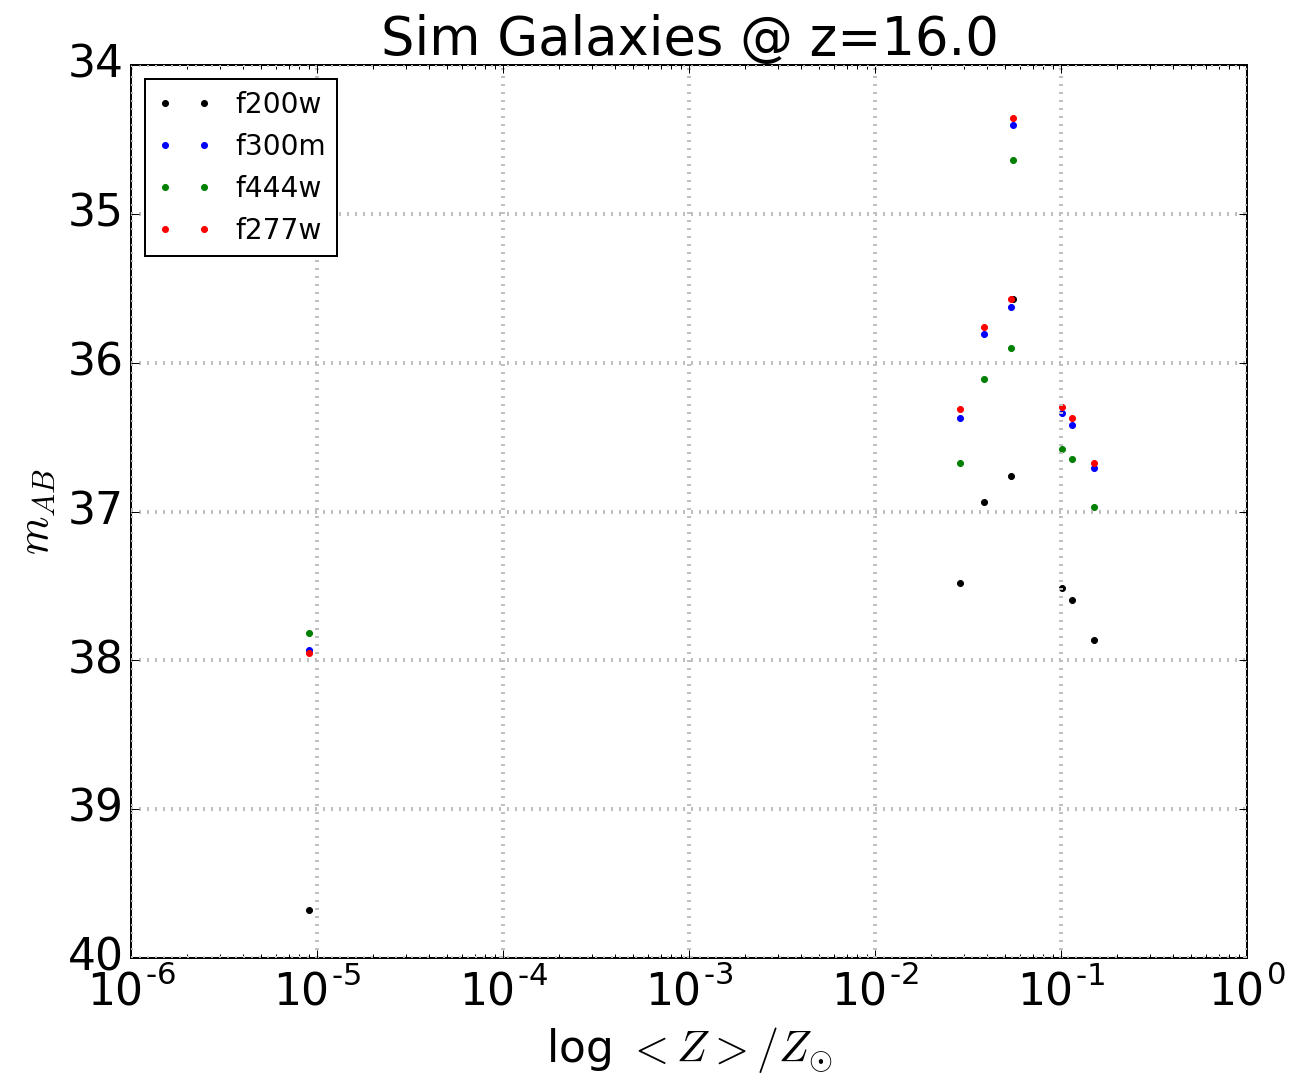

In [62]:
for z in np.sort(thezs):
    
    galAveZ = fluxes[z]['ZZ_sun']
    galAveZ[galAveZ<1e-5] = 0.9e-5 # Map all <Z> < Z_crit to value just below Z_crit... 
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    ax.set_xscale('log')
    ax.set_yscale('linear')

    ax.set_title('Sim Galaxies @ z={}'.format(z))
    ax.plot(galAveZ,mag(fluxes[z]['f200w']),'k.')
    ax.plot(galAveZ,mag(fluxes[z]['f300m']),'b.')
    ax.plot(galAveZ,mag(fluxes[z]['f444w']),'g.')
    ax.plot(galAveZ,mag(fluxes[z]['f277w']),'r.')

#     ax.set_ylim([25,38])
    ax.set_xlabel('log $<Z>/Z_{\odot}$')
    ax.set_ylabel(r'$m_{AB}$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

    ax.legend(['f200w','f300m','f444w','f277w'], 
              loc='upper left', fontsize=14 )

    plt.gca().invert_yaxis()
    plt.savefig("haloZVsMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

Convert to Abs Mag - factor = -46.76
Convert to Abs Mag - factor = -46.89
Convert to Abs Mag - factor = -47.00
Convert to Abs Mag - factor = -47.11
Convert to Abs Mag - factor = -47.21
Convert to Abs Mag - factor = -47.31
Convert to Abs Mag - factor = -47.39
Convert to Abs Mag - factor = -47.48
Convert to Abs Mag - factor = -47.55
Convert to Abs Mag - factor = -47.69
Convert to Abs Mag - factor = -47.82


ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10c9cfb70> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

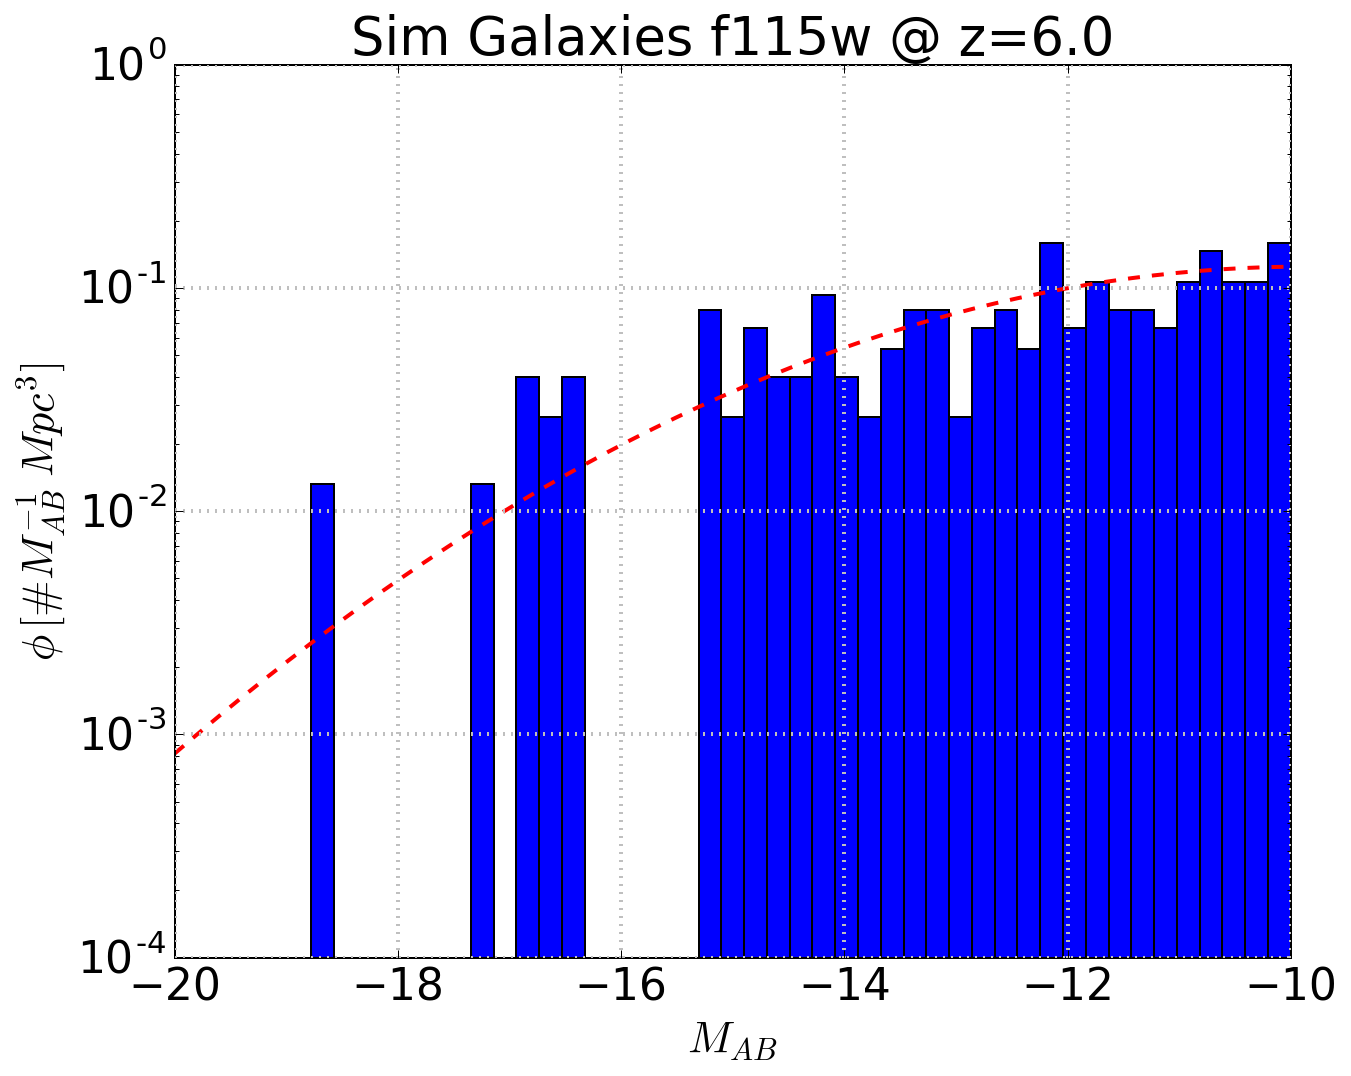

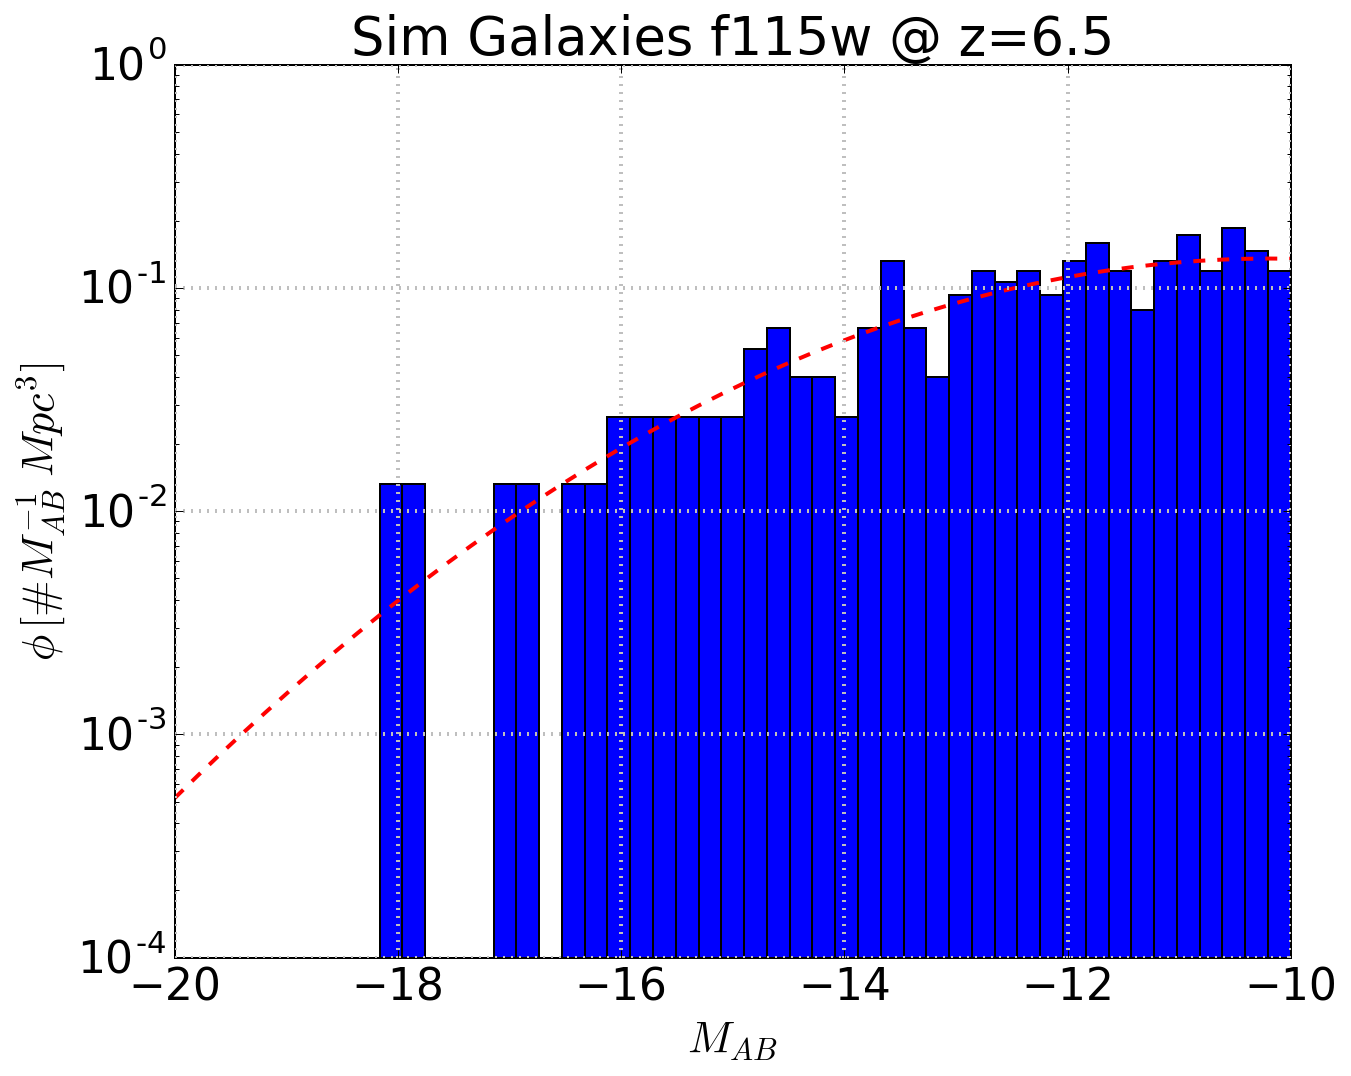

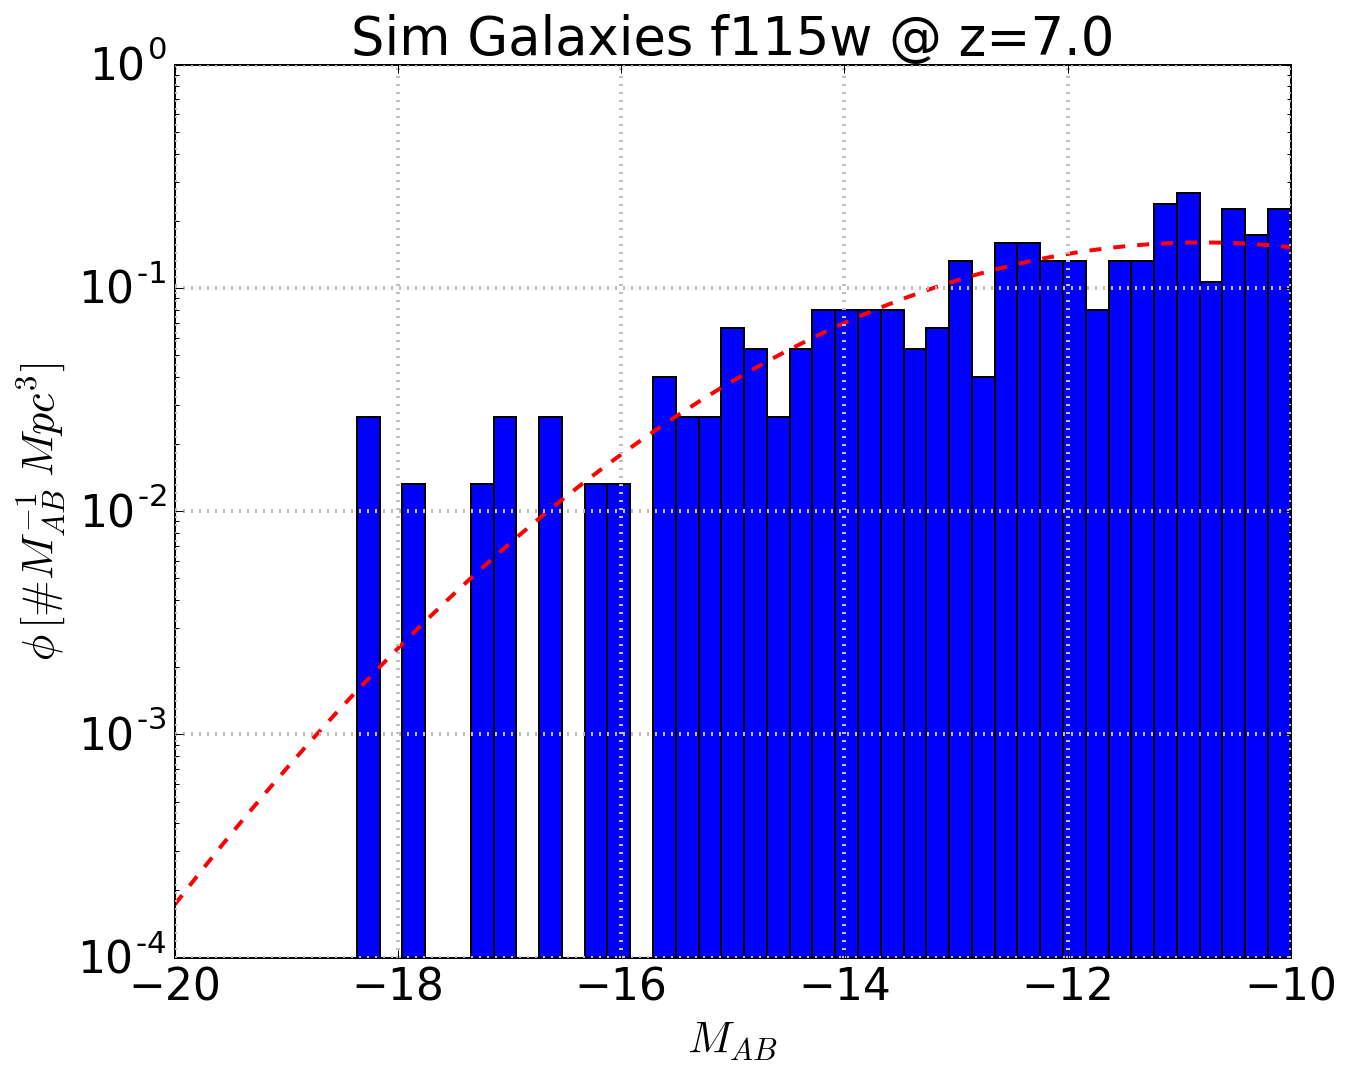

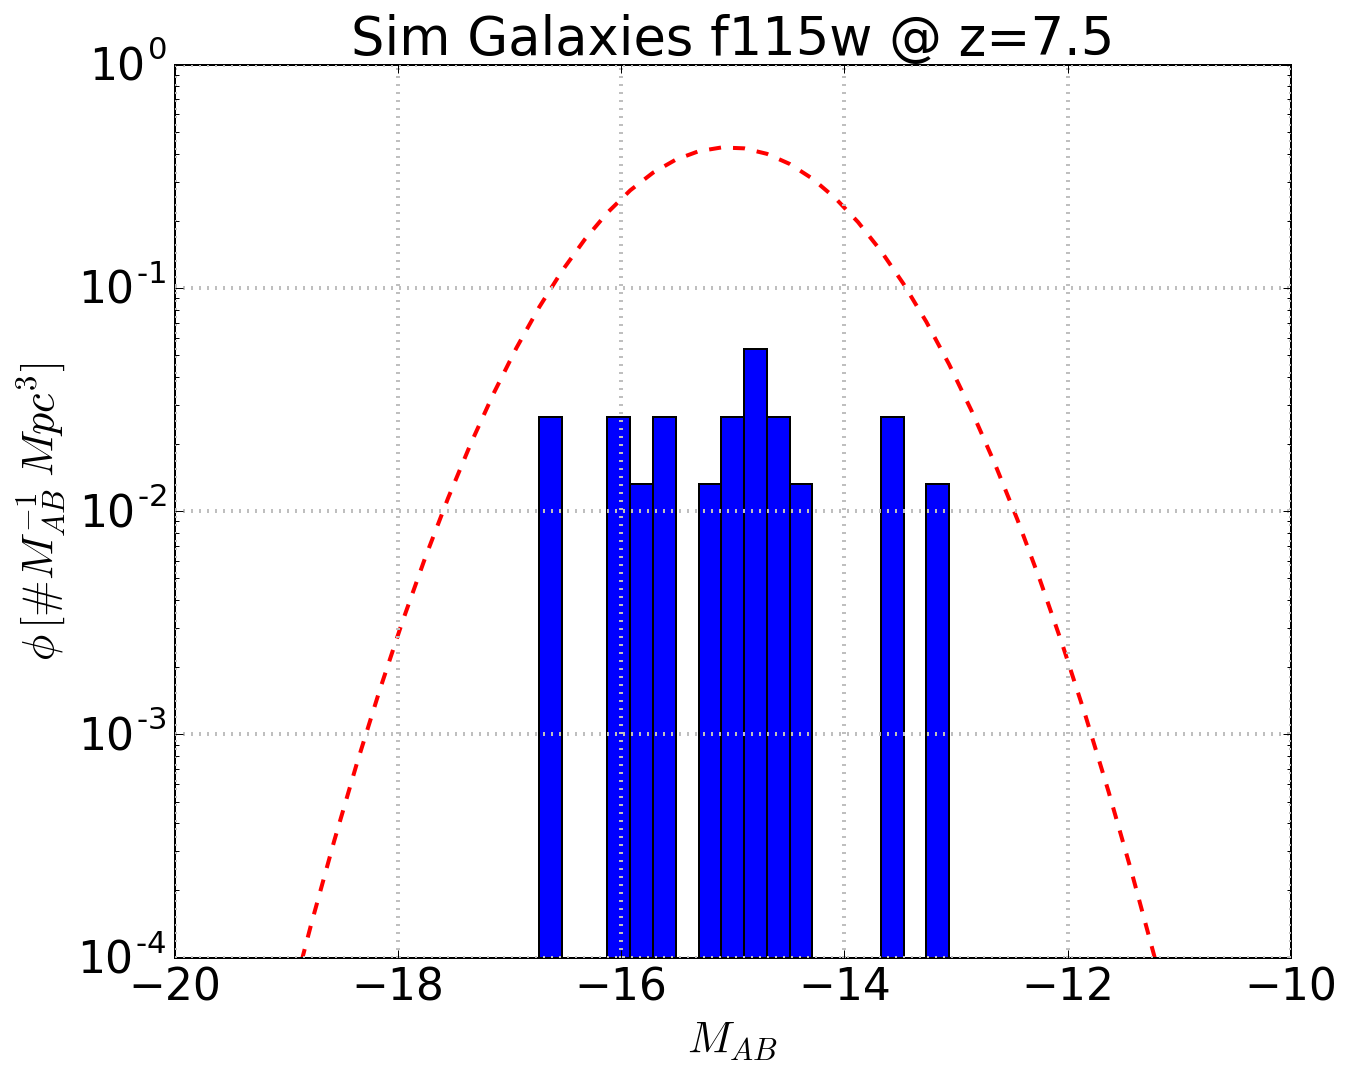

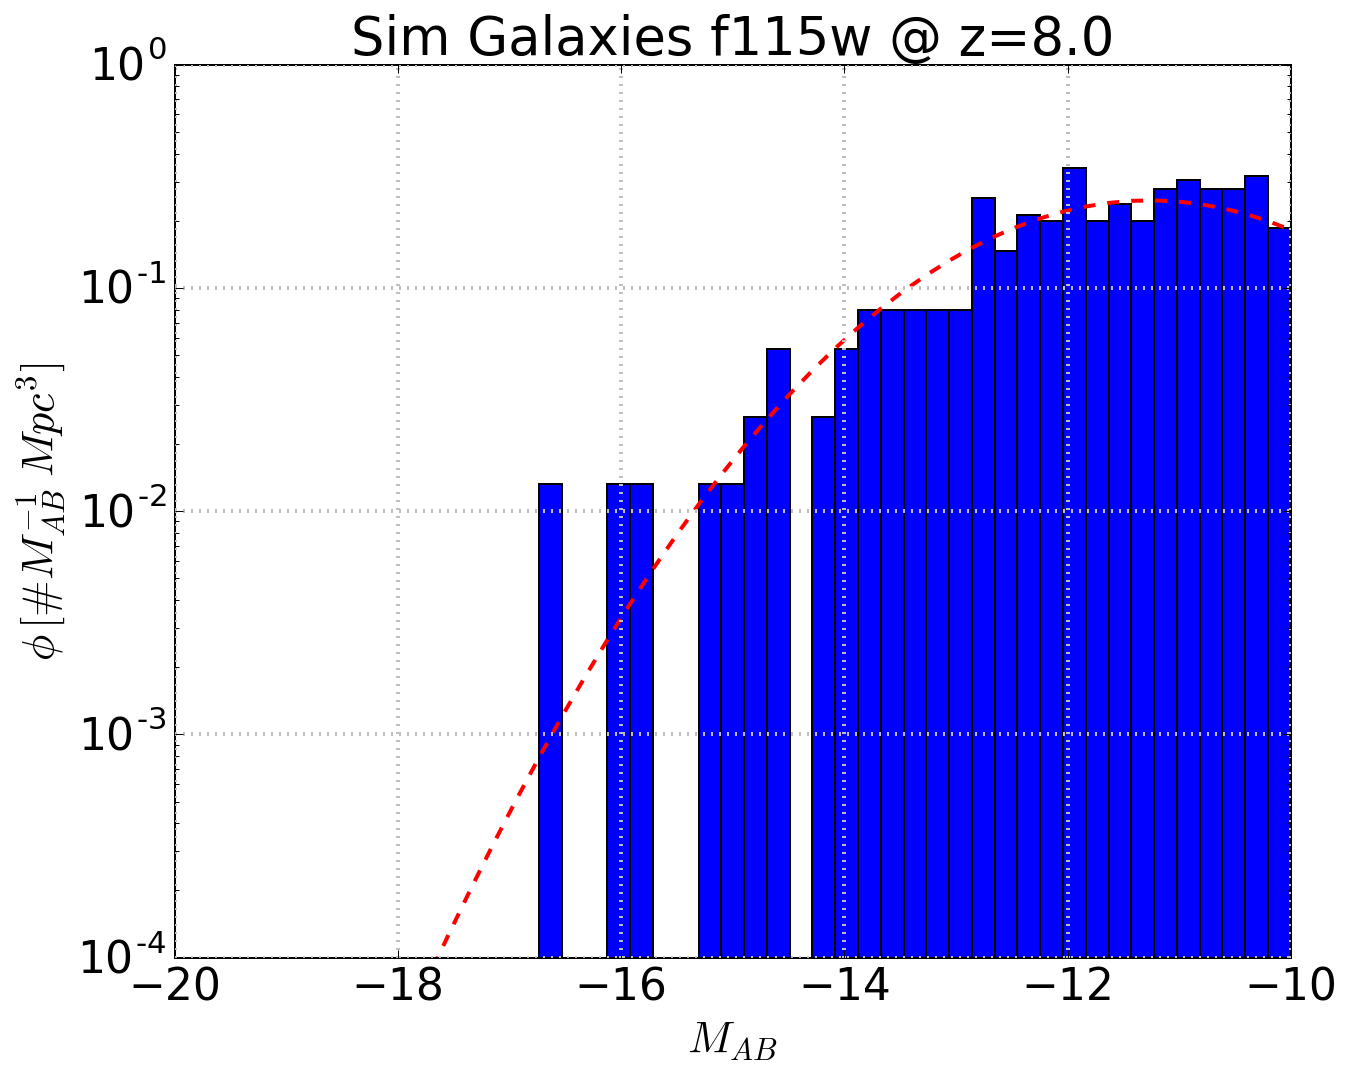

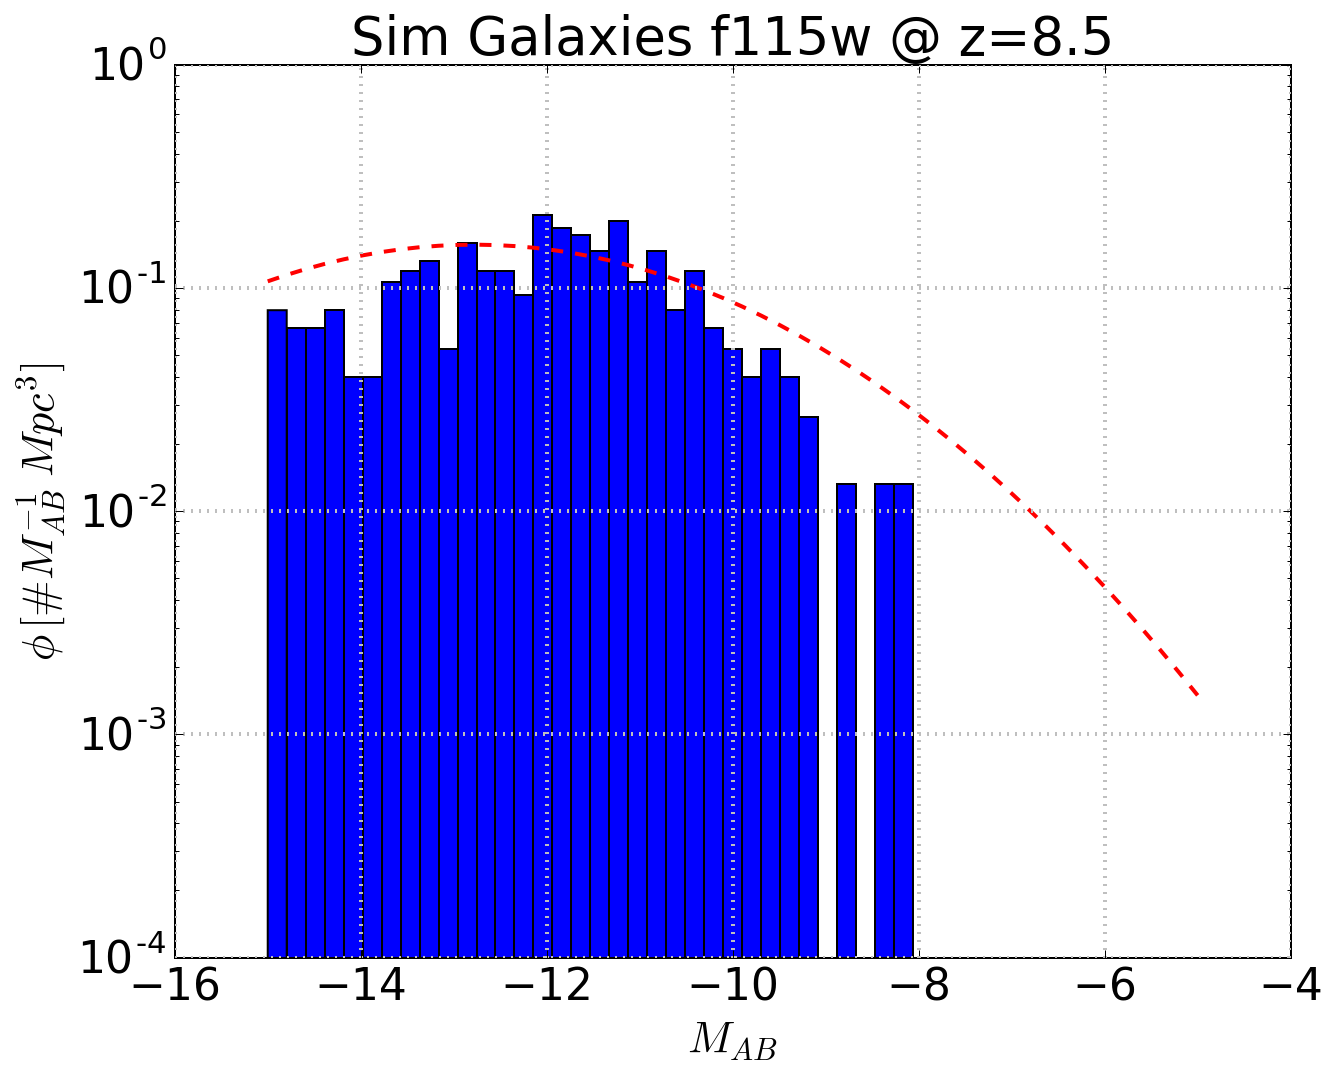

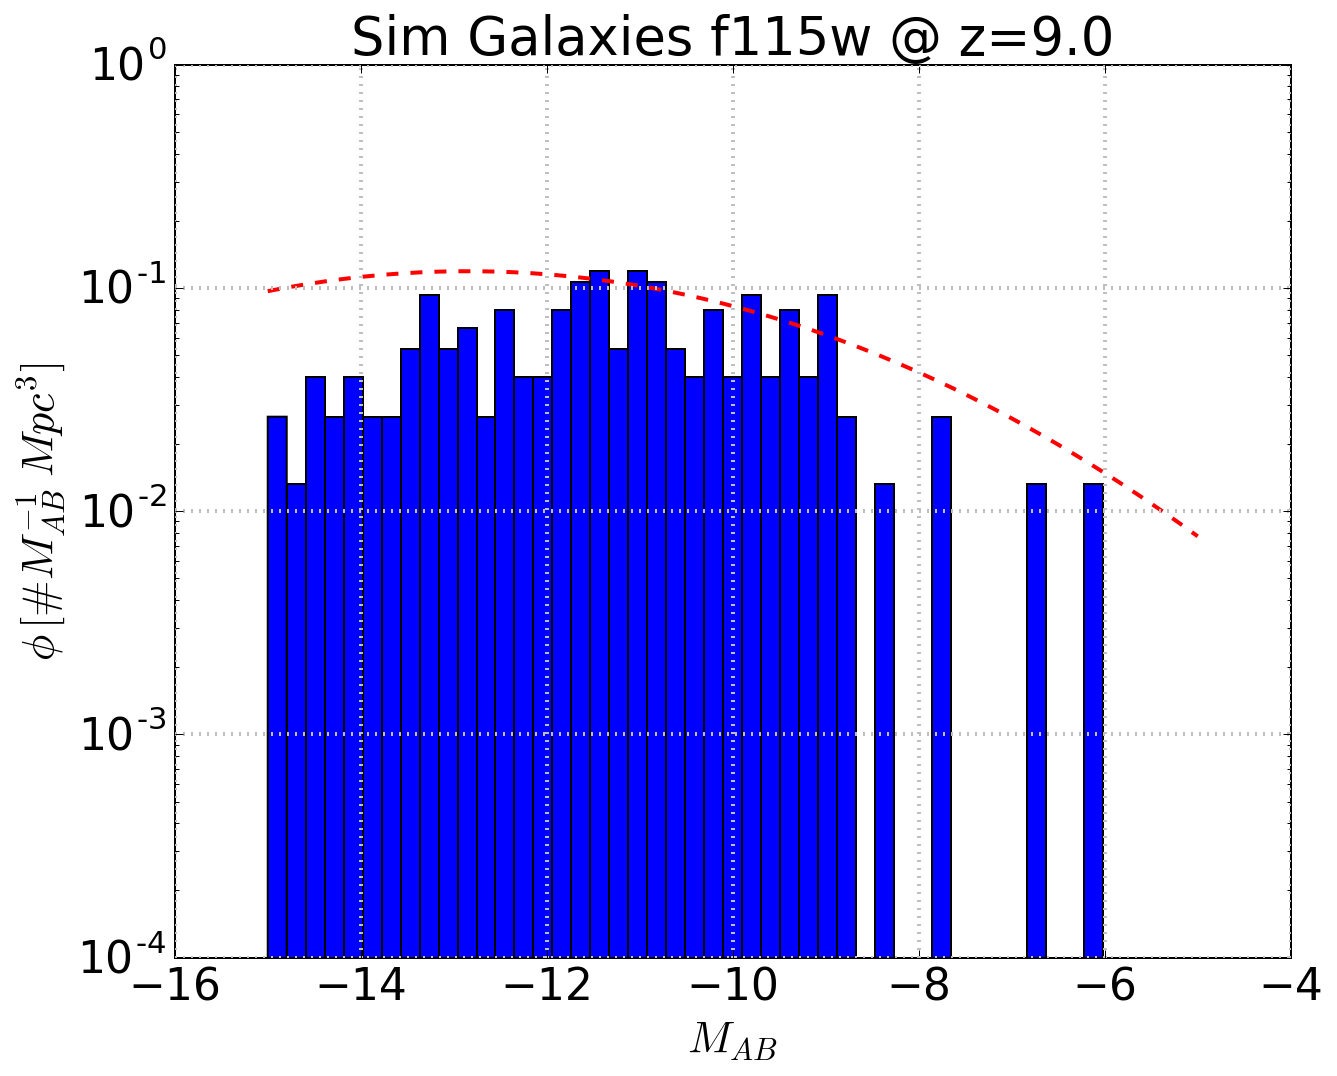

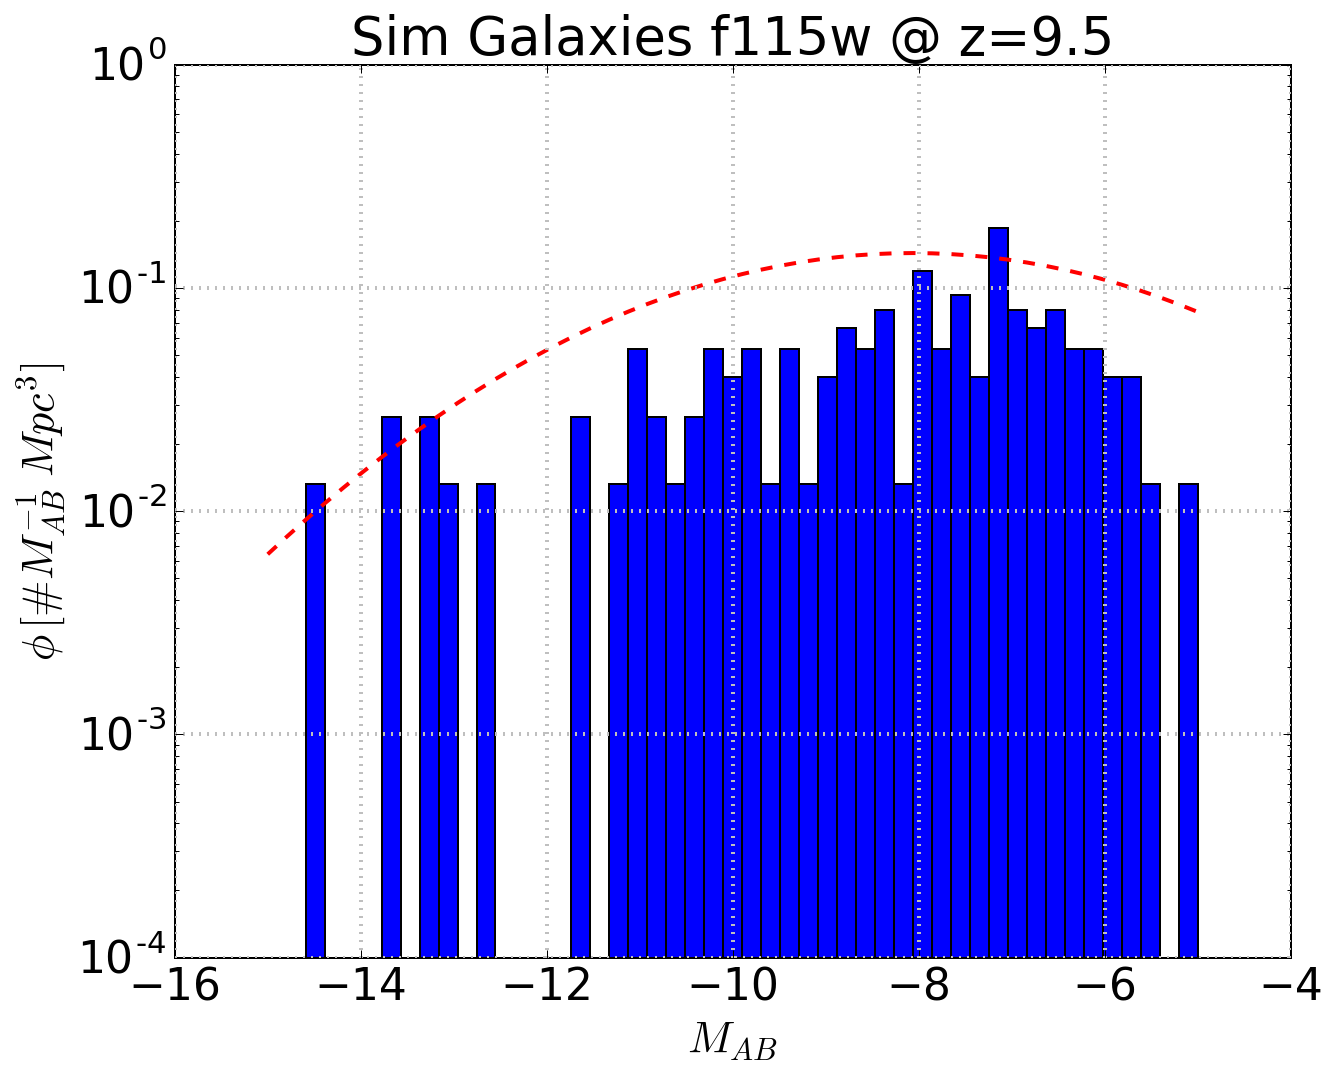

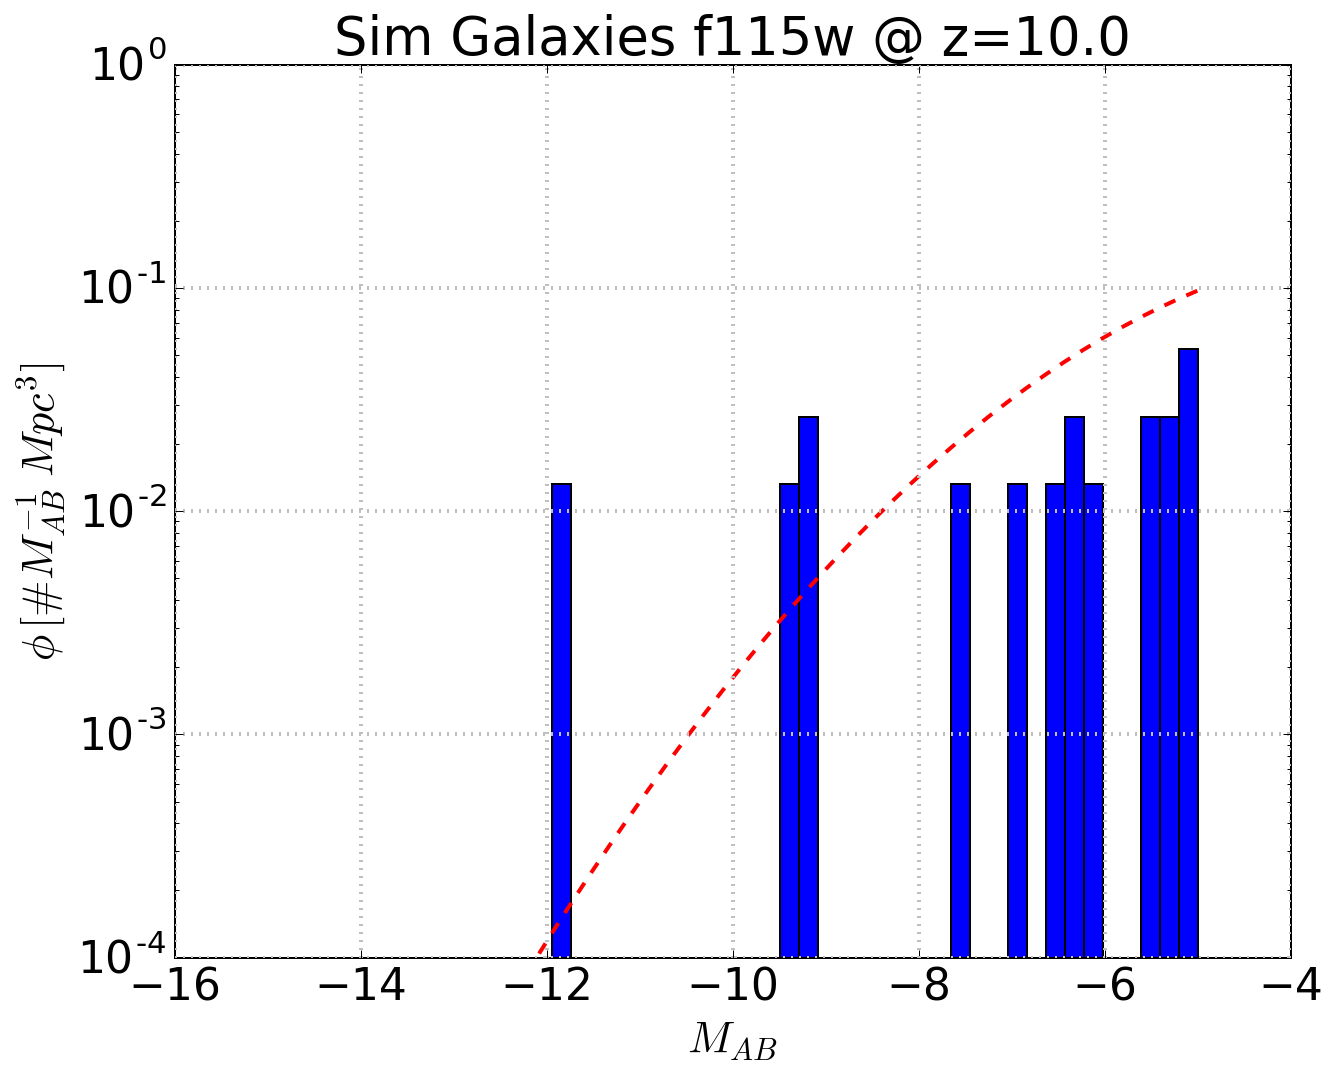

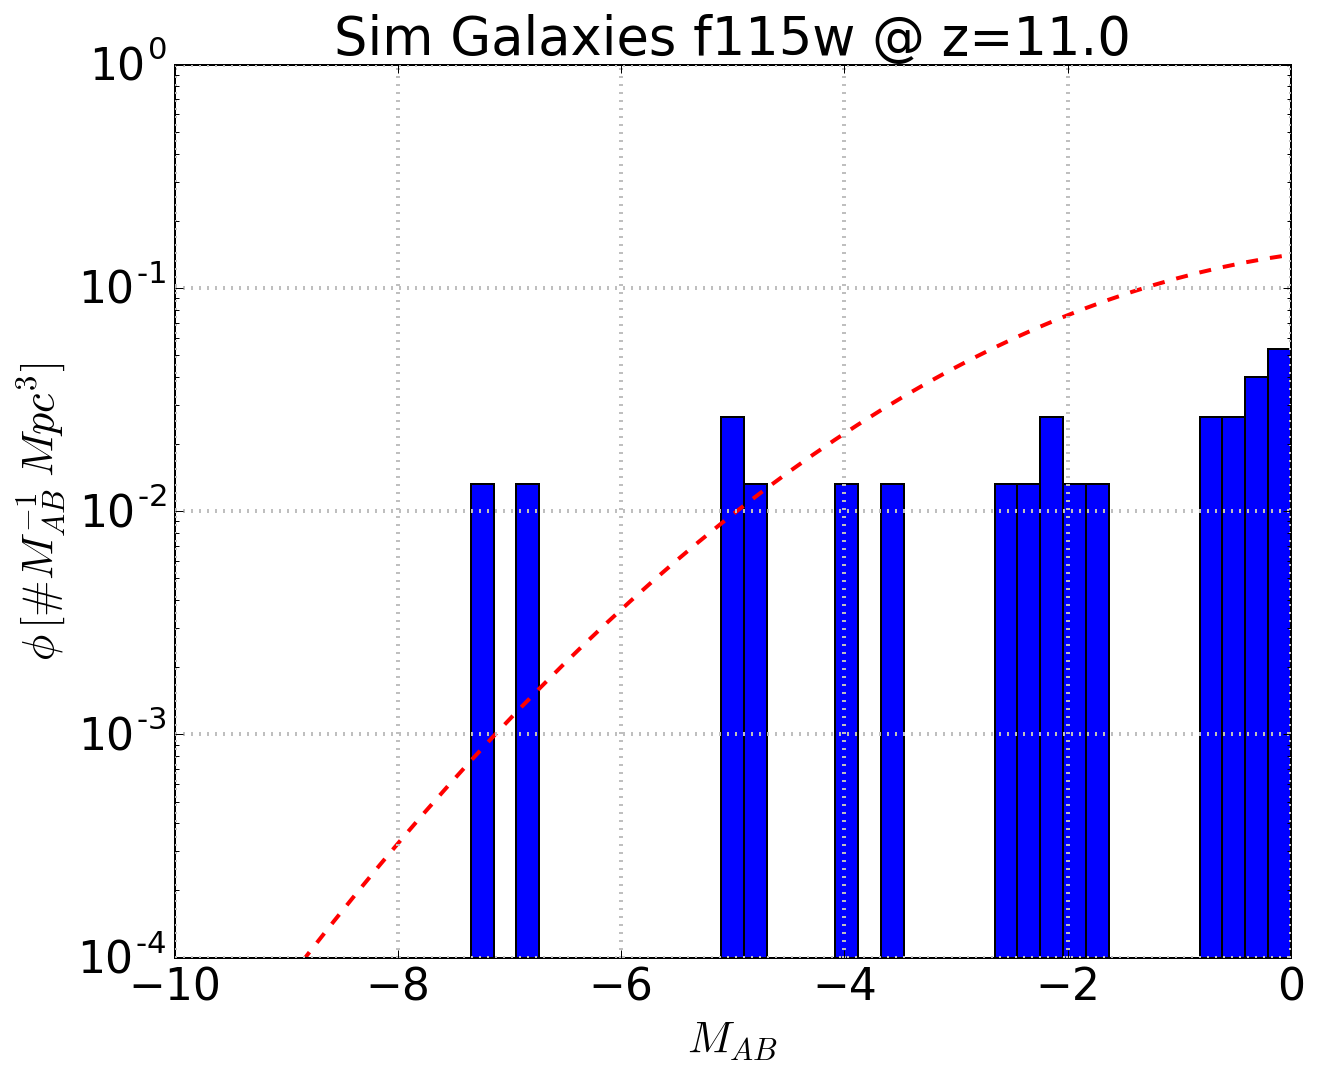

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [105]:
import matplotlib.mlab as mlab
from scipy.stats import norm

simVol = (3.0/0.71)**3
for z in np.sort(thezs):
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()

    if z < 8.5:
        magBins = np.linspace(-20,-10) 
    elif z < 11:
        magBins = np.linspace(-15,-5) 
    else:
        magBins = np.linspace(-10,0) 

    # Convert observed magnitude to Absolute ...
    convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
    
    print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
    # This filter makes sense to compare to Finkelstein at z=6 .. since 11,500 / (1+z) ~ 1600A. Finkelstein @ 1500A
    n, bins, patches = ax.hist(mag(fluxes[z]['f115w'])+convertToM, bins=magBins, log=True,
                               weights=[1.0/simVol for i in fluxes[z]['f115w']]) 

    # best fit of data
    (mu, sigma) = norm.fit(mag(fluxes[z]['f115w'])+convertToM,log=True)
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=2)

    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_ylim([1e-4,1])

    ax.set_title('Sim Galaxies f115w @ z={}'.format(z))
    ax.set_xlabel('$M_{AB}$')
    ax.set_ylabel(r'$\phi\, [\# M_{AB}^{-1}\; Mpc^3]$')
    ax.grid(color='0.75', linestyle=':', linewidth=2)

#     ax.legend(['f200w','f300m','f444w','f277w'], 
#               loc='upper left', fontsize=14 )

#     plt.gca().invert_xaxis()
    plt.savefig("haloZVsMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
    gc.collect()
gc.collect()

In [19]:
# Going from obs mag to Abs Mag at z = 6 ... 
# comoving distance to z=6/10pc ... squared... times (1+z)
-2.5* np.log10((8450e6/10)**2 * (7))

-46.747028644784109

Convert to Abs Mag - factor = -47.82


159576

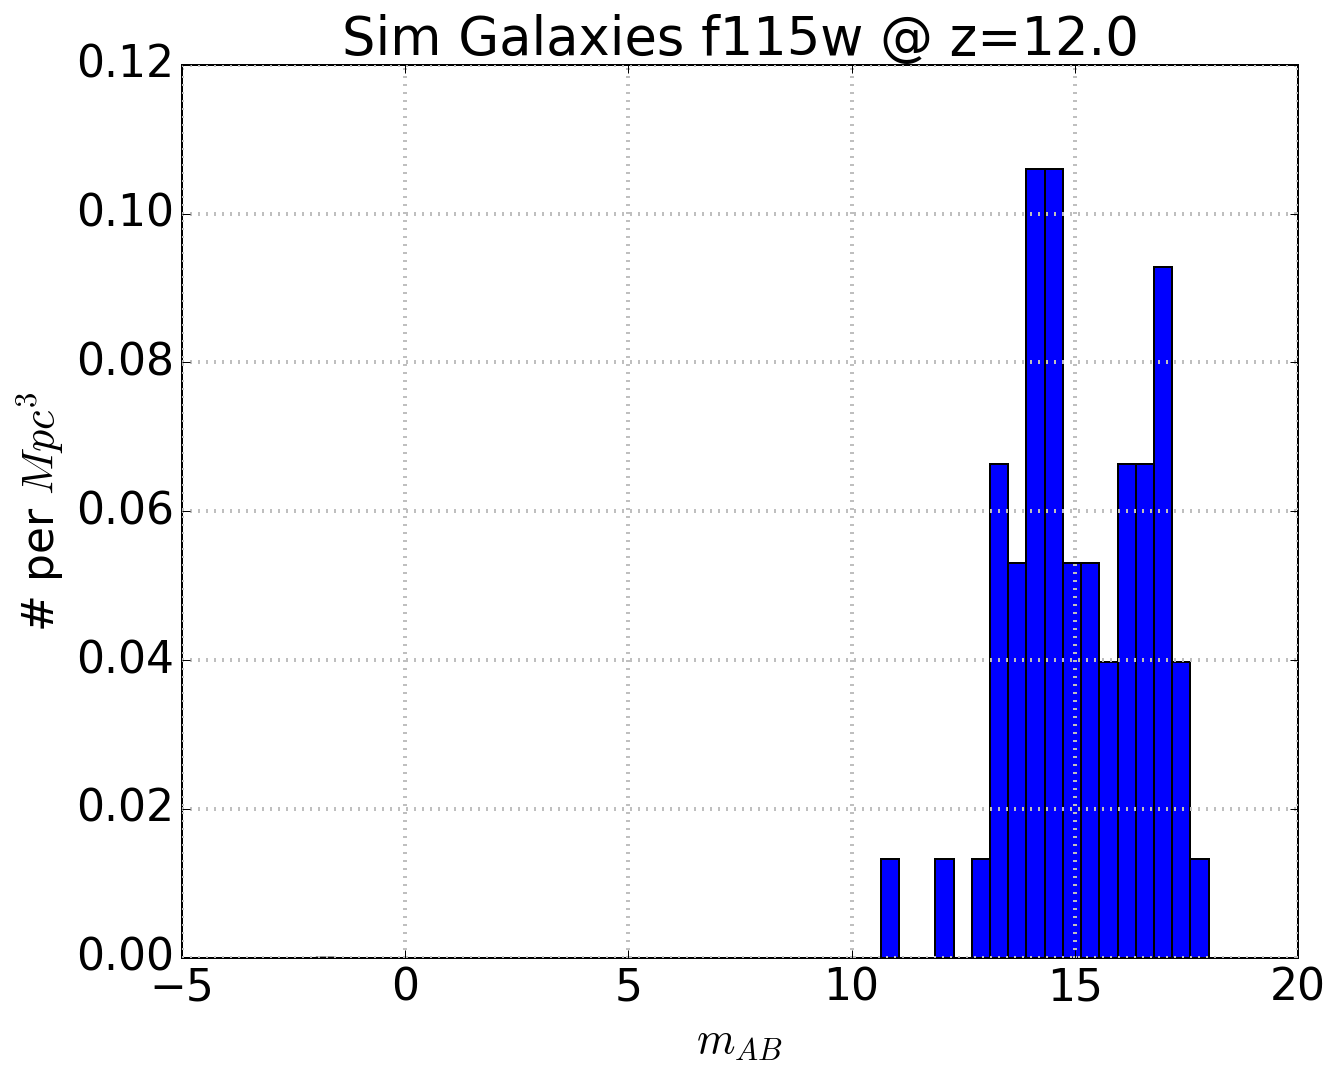

In [28]:
z=12.0

fig = plt.figure(figsize=(10,8))
ax = plt.axes()

if z < 8.5:
    magBins = np.linspace(-20,-11) 
elif z < 10:
    magBins = np.linspace(-13,-5) 
else:
    magBins = np.linspace(-2,18) 

convertToM = -2.5*np.log10((cosmo.comoving_distance(z)/(10 * u.pc))**2 * (1+z))
print("Convert to Abs Mag - factor = {:.2f}".format(convertToM))
# This filter makes sense to compare to Finkelstein at z=6 .. since 11,500 / (1+z) ~ 1600A. Finkelstein @ 1500A
n, bins, patches = ax.hist(mag(fluxes[z]['f115w'])+convertToM,bins=magBins, 
                           weights=[1.0/simVol for i in fluxes[z]['f115w']]) 

ax.set_xscale('linear')
ax.set_yscale('linear')

ax.set_title('Sim Galaxies f115w @ z={}'.format(z))

#     ax.set_ylim([25,38])
ax.set_xlabel('$M_{AB}$')
ax.set_ylabel(r'# per $Mpc^3$')
ax.grid(color='0.75', linestyle=':', linewidth=2)

#     ax.legend(['f200w','f300m','f444w','f277w'], 
#               loc='upper left', fontsize=14 )

#     plt.gca().invert_xaxis()
plt.savefig("haloZVsMag_{:.1f}.pdf".format(z),dpi=fig.dpi,bbox_inches='tight')
gc.collect()
